### == Project Initialization ==

In [3]:
# --- Define the project root directory ---
from pathlib import Path
from datetime import datetime

# Create a marker file indicating the project root
Path(".project-root").touch(exist_ok=True)

# Print for verification
print("Project root set to:", Path.cwd())


Project root set to: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project


In [4]:
# --- Define project paths ---

from pathlib import Path

# Locate the project root directory
PROJ_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define main subdirectories
DATA = PROJ_ROOT / "data"
RAW = DATA / "raw_data"
INTERIM = DATA / "interim"
PROCESSED = DATA / "processed"
ARTIFACTS = PROJ_ROOT / "artifacts"
REPORTS = PROJ_ROOT / "reports"

# Create directories if they do not already exist
for p in [RAW, INTERIM, PROCESSED, ARTIFACTS, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

# Print for verification
print("Project root:", PROJ_ROOT)
print("Has .git? ", (PROJ_ROOT / ".git").exists())
print("RAW path:", RAW)


Project root: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project
Has .git?  True
RAW path: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\raw_data


#### == Install & Import dependencies ==

In [5]:
# Install + Import core libraries
!pip install pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=["#DB7093"])
plt.rcParams["figure.figsize"] = (10, 6) 

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_palette("RdPu")  

import warnings, os, re, textwrap, time, json
from collections import Counter
from pathlib import Path
warnings.filterwarnings("ignore")

%matplotlib inline



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# DATA PREP

### == Load raw data & create working copy ==


In [6]:
import os
print("Files in RAW:", os.listdir(RAW))


Files in RAW: ['.ipynb_checkpoints', 'participants_sep23_sep24_raw.csv']


In [7]:
# =========================================
# Load raw file and create initial working file
# =========================================
import os
import pandas as pd
from pathlib import Path

print("Files in RAW:", os.listdir(RAW))

RAW_FILE = RAW / "participants_sep23_sep24_raw.csv"
df = pd.read_csv(RAW_FILE)
print("✅ Loaded RAW:", RAW_FILE.name, "| Shape:", df.shape)

# --- Create the initial working copy ---
work_base = Path("data/interim/participants_work")
work_base.parent.mkdir(parents=True, exist_ok=True)

df.to_pickle(f"{work_base}.pkl")
df.to_csv(f"{work_base}.csv", index=False, encoding="utf-8-sig")

print("\n💾 Initial WORK file created:")
print("   PKL →", work_base.with_suffix(".pkl").resolve())
print("   CSV →", work_base.with_suffix(".csv").resolve())
print("Shape:", df.shape)


Files in RAW: ['.ipynb_checkpoints', 'participants_sep23_sep24_raw.csv']
✅ Loaded RAW: participants_sep23_sep24_raw.csv | Shape: (107300, 237)

💾 Initial WORK file created:
   PKL → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_work.pkl
   CSV → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_work.csv
Shape: (107300, 237)


### == Data Utilities & Change Tracking Tools ==

In [8]:
# Helper functions for working with the data:
# snapshots, quick reports, schema comparison, and cumulative change log

import time, json
from pathlib import Path
import pandas as pd

# Artifacts directory
ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# ===== Cumulative change log =====
change_log = []


def snapshot_cols(df: pd.DataFrame):
    """Capture a snapshot of the current DataFrame: set of columns and row/column counts."""
    return set(df.columns), df.shape[0], df.shape[1]


def report_changes(step_name: str,
                   before_cols: set, after_cols: set,
                   rows_before: int, rows_after: int,
                   print_now: bool = True):
    """Generate a before–after report and append the results to the cumulative change log."""
    added = sorted(list(after_cols - before_cols))
    removed = sorted(list(before_cols - after_cols))
    rec = {
        "שלב": step_name,
        "שורות לפני": rows_before, "שורות אחרי": rows_after, "Δ שורות": rows_after - rows_before,
        "עמודות לפני": len(before_cols), "עמודות אחרי": len(after_cols), "Δ עמודות": len(after_cols) - len(before_cols),
        "נוספו": "; ".join(added) if added else "",
        "הוסרו": "; ".join(removed) if removed else "",
    }
    change_log.append(rec)
    if print_now:
        print(f"=== Before–after: {step_name} ===")
        print(f"Shape before: ({rows_before:,}, {len(before_cols)}) | "
              f"Shape after: ({rows_after:,}, {len(after_cols)})")
        print(f"Columns added ({len(added)}): {added if added else []}")
        print(f"Columns removed ({len(removed)}): {removed if removed else []}")


def save_change_log(path: Path = ARTIFACTS / "change_log.csv"):
    """Save the cumulative change log to a CSV file."""
    if not change_log:
        print("No records in the change log.")
        return
    df_log = pd.DataFrame(change_log)
    df_log.to_csv(path, index=False, encoding="utf-8-sig")
    print(f"[Saved] Change log: {path}")


# ===== Save a snapshot of the data (Parquet/CSV) + schema of dtypes =====
def save_snapshot_df(df: pd.DataFrame, name: str) -> str:
    """Save a snapshot of the DataFrame and its schema (rows, columns, dtypes)."""
    ts = time.strftime("%Y%m%d-%H%M%S")
    base = ARTIFACTS / f"{ts}_{name}"
    try:
        df.to_parquet(f"{base}.parquet", index=False)
        stored = f"{base}.parquet"
    except Exception:
        df.to_csv(f"{base}.csv", index=False, encoding="utf-8")
        stored = f"{base}.csv"
    schema = {
        "name": name,
        "rows": int(len(df)),
        "cols": int(df.shape[1]),
        "dtypes": {c: str(t) for c, t in df.dtypes.items()}
    }
    with open(f"{base}_schema.json", "w", encoding="utf-8") as f:
        json.dump(schema, f, ensure_ascii=False, indent=2)
    print(f"[Saved] {stored} + {base.name}_schema.json")
    return str(base)


# ===== Quick data report =====
def quick_data_report(df: pd.DataFrame, title: str = "Quick data report"):
    """Print a compact summary of the DataFrame structure, dtypes, missingness, and duplicates."""
    print(f"\n=== {title} ===")
    print("Shape:", df.shape)
    print("\n-- Info --")
    df.info()
    print("\n-- Dtypes summary --")
    print(df.dtypes.value_counts())
    print("\n-- Unique values per column (top 10) --")
    nunique = df.nunique(dropna=False).sort_values(ascending=False)
    print(nunique.head(10))
    print("\n-- Missing (top 10) --")
    na = df.isna().sum()
    na = na[na > 0].sort_values(ascending=False)
    print(na.head(10))
    print("\n-- Duplicated rows --", df.duplicated().sum())


# ===== Schema comparison =====
def diff_schema(df_before: pd.DataFrame, df_after: pd.DataFrame,
                title: str = "Schema comparison") -> pd.DataFrame:
    """Compare dtypes before and after a transformation and highlight changes."""
    a = pd.Series({c: str(t) for c, t in df_before.dtypes.items()}, name="before")
    b = pd.Series({c: str(t) for c, t in df_after.dtypes.items()}, name="after")
    allc = sorted(set(a.index) | set(b.index))
    diff = pd.DataFrame({"before": a.reindex(allc), "after": b.reindex(allc)})
    diff["changed"] = diff["before"] != diff["after"]
    print(f"=== {title} ===")
    print(diff[diff["changed"]])
    return diff


### == Remove PII columns (Personally Identifiable Information) == 


In [9]:
list(df.columns)

["מס' סימוכין 360",
 "מס' סימוכין ממשל זמין",
 'סוג טופס',
 'גרסת הטופס',
 'תאריך טופס',
 'ממלא הטופס',
 'תפקיד ממלא הטופס',
 'סמל יישוב',
 'יישוב',
 'מחוז',
 'סוג מוסד',
 'סמל מוסד',
 'שם מענה',
 'סמל מענה',
 'מיקום מענה',
 'כיתה',
 'מפקח מענה',
 'אחראי מענה',
 'מנהל מענה',
 'סטטוס מענה',
 'קבוצת גיל',
 'שם תוכנית',
 'סמל תוכנית',
 'תעודת זהות',
 'מזהה אחר',
 'שם הילד',
 'מגדר',
 'מגדיר עצמו כמשתייך ללהטב"ק',
 'שנת לידה',
 'מסגרת חינוכית',
 'שם המוסד בו לומד הילד',
 'סמל המוסד בו לומד הילד',
 'שכבה',
 'ישוב מגורים',
 'שכונת מגורים',
 'קבוצת אוכלוסיה',
 'עם מי גר הילד',
 'יתום',
 'הילד במסגרת מחוץ לבית',
 'האם הילד אובחן',
 'מגבלות מאובחנת',
 'מוגבלות שאינה מאובחנת',
 'ארץ לידה',
 'הילד עלה בשנים האחרונות',
 'ארץ לידה של האב',
 'האב עלה בשנים האחרונות',
 'ארץ לידה של האם',
 'האם עלתה בשנים האחרונות',
 'סטטוס משפחתי של ההורים',
 'תעסוקת אב',
 'תעסוקת אם',
 'מצוקה כלכלית',
 'מספר ילדים (עד גיל 18)',
 'השכלת אב',
 'השכלת אם',
 'הורה סובל מהתמכרויות',
 'הורה מעורב בהתנהגות עבריינית',
 'הור

In [10]:
## --- Dropping sensitive columns ---

# Snapshot before the operation
df_before = df.copy()

# Columns to remove
drop_cols = [
    "שם המוסד בו לומד הילד", "ממלא הטופס", "מפקח מענה", 
    "אחראי מענה", "מנהל מענה", "שם הילד", 
    "סמל המוסד בו לומד הילד"
]

# Check which columns exist and which do not before dropping
source_cols = set(df_raw.columns) if 'df_raw' in globals() else set(df_before.columns)
present_to_drop = [c for c in drop_cols if c in source_cols]
not_found = [c for c in drop_cols if c not in source_cols]

# Perform the actual drop
df = df.drop(columns=drop_cols, errors="ignore")

# Describe what was actually removed
after_cols = set(df.columns)
actually_dropped = sorted(list(set(df_before.columns) - after_cols))

# Compare schema before/after
diff_schema(df_before, df, title="Schema diff: after dropping sensitive columns")

# Quick report
quick_data_report(df, title="After dropping sensitive columns")

# Short summary
print(f"\nRequested to drop: {len(drop_cols)}")
print(f"Found & requested: {len(present_to_drop)} -> {present_to_drop}")
print(f"Not found: {len(not_found)} -> {not_found}")
print(f"Actually dropped (by diff): {len(actually_dropped)} -> {actually_dropped}")
print("Shape after dropping columns:", df.shape)


# Save + backup with timestamp
df.to_pickle(str(work_base) + ".pkl")
df.to_csv(str(work_base) + ".csv", index=False, encoding="utf-8-sig")

from datetime import datetime
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
df.to_pickle(f"{work_base}_{ts}.pkl")

# Save snapshot for future restoration if needed
save_snapshot_df(df, "after_drop_sensitive")

print("✅ WORK file and backup saved:")
print("   Main PKL →", work_base.with_suffix(".pkl").resolve())
print("   Main CSV →", work_base.with_suffix(".csv").resolve())
print("   Backup   →", f"{work_base}_{ts}.pkl")
print("Shape:", df.shape)


=== Schema diff: after dropping sensitive columns ===
                         before after  changed
אחראי מענה               object   NaN     True
ממלא הטופס               object   NaN     True
מנהל מענה                object   NaN     True
מפקח מענה                object   NaN     True
סמל המוסד בו לומד הילד  float64   NaN     True
שם הילד                  object   NaN     True
שם המוסד בו לומד הילד    object   NaN     True

=== After dropping sensitive columns ===
Shape: (107300, 230)

-- Info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107300 entries, 0 to 107299
Columns: 230 entries, מס' סימוכין 360 to מורכבות הורים
dtypes: bool(8), float64(29), int64(4), object(189)
memory usage: 182.6+ MB

-- Dtypes summary --
object     189
float64     29
bool         8
int64        4
Name: count, dtype: int64

-- Unique values per column (top 10) --
מס' סימוכין 360          97714
תאריך טופס               88241
תעודת זהות               66956
תחום שהילד מגלה הצלחה    11643
מיקום מענה   

### == Standardizing Column Names ==

In [11]:
from collections import Counter

# Snapshot before renaming
df_before = df.copy()

# Rename columns using a dictionary

RENAMES = {
    """מס' סימוכין 360""": "ref_id_360",
    """מס' סימוכין ממשל זמין""": "gov_ref_id",
    """סוג טופס""": "form_type",
    """גרסת הטופס""": "form_version",
    """תאריך טופס""": "form_date",
    """תפקיד ממלא הטופס""": "form_filler_role",
    """סמל יישוב""": "yeshuv_code",
    """יישוב""": "yeshuv_name",
    """מחוז""": "machoz",
    """סוג מוסד""": "institution_type",
    """סמל מוסד""": "institution_code",
    """שם מענה""": "service_name",
    """סמל מענה""": "service_code",
    """מיקום מענה""": "service_location",
    """כיתה""": "grade",
    """סטטוס מענה""": "service_status",
    """קבוצת גיל""": "age_group",
    """שם תוכנית""": "program_name",
    """סמל תוכנית""": "program_code",
    """תעודת זהות""": "id_number",
    """מזהה אחר""": "alt_identifier",
    """מגדר""": "sex",
    """מגדיר עצמו כמשתייך ללהטב"ק""": "lgbtq_self_id",
    """שנת לידה""": "birth_year",
    """מסגרת חינוכית""": "edu_framework",
    """שכבה""": "school_level",
    """ישוב מגורים""": "residence_locality",
    """שכונת מגורים""": "residence_neighborhood",
    """קבוצת אוכלוסיה""": "population_group",
    """עם מי גר הילד""": "child_living_arrangement",
    """יתום""": "orphan_status",
    """הילד במסגרת מחוץ לבית""": "out_of_home_placement",
    """האם הילד אובחן""": "diagnosed_disability_flag",
    """מגבלות מאובחנת""": "diagnosed_disability_type",
    """מוגבלות שאינה מאובחנת""": "undiagnosed_disability_flag",
    """ארץ לידה""": "child_birth_country",
    """הילד עלה בשנים האחרונות""": "child_recent_immigrant",
    """ארץ לידה של האב""": "father_birth_country",
    """האב עלה בשנים האחרונות""": "father_recent_immigrant",
    """ארץ לידה של האם""": "mother_birth_country",
    """האם עלתה בשנים האחרונות""": "mother_recent_immigrant",
    """סטטוס משפחתי של ההורים""": "parents_marital_status",
    """תעסוקת אב""": "father_employment",
    """תעסוקת אם""": "mother_employment",
    """מצוקה כלכלית""": "economic_distress",
    """מספר ילדים (עד גיל 18)""": "num_children_u18",
    """השכלת אב""": "father_education",
    """השכלת אם""": "mother_education",
    """הורה סובל מהתמכרויות""": "parent_addictions_flag",
    """הורה מעורב בהתנהגות עבריינית""": "parent_criminal_involvement",
    """הורה עם מוגבלות""": "parent_disability_flag",
    """מוגבלות הורה""": "parent_disability_type",
    """האב מקבל התערבות סדירה במסגרת המענה""": "father_receives_intervention",
    """האם מקבלת התערבות סדירה במסגרת המענה""": "mother_receives_intervention",
    """המשפחה מוכרת ברווחה""": "welfare_known_family",
    """חד הורי""": "single_parent",
    """ילד מקבל שירותים/מענים נוספים""": "child_additional_services",
    """שם השירות""": "other_service_name",
    """הגורם המטפל""": "treating_agency",
    """מקבל שירות – ילד""": "receives_service_child",
    """מקבל שירות - הורים""": "receives_service_parents",
    """שפה""": "subject_language",
    """חשבון""": "subject_math",
    """אנגלית""": "subject_english",
    """מדעים""": "subject_science",
    """שרות""": "service_general",
    """פרטני""": "individual_session",
    """מספר פעמים בשבוע (בי"ס)""": "school_service_freq_week",
    """מספר שעות כל פעם""": "school_service_hours_per_session",
    """מזהה מענה בית ספרי""": "school_service_id",
    """שירות קהילתי""": "community_service_flag",
    """מספר פעמים בשבוע (בקהילה)""": "community_service_freq_week",
    """מספר שעות למפגש""": "community_service_hours_per_session",
    """מזהה מענה קהילתי""": "community_service_id",
    """יודע שהילד מוכר/מטופל באגף הרווחה""": "aware_child_welfare_involvement",
    """האם הילד עבר ועדת השמה""": "placement_committee_flag",
    """ת. הצטרפות""": "join_date",
    """ת. עזיבה""": "leave_date",

    # --- Risk indicators (RS = Risk State header, RI = Risk Indicator item) ---
    """100001_קשיים בטיפול הפיזי""": "RS1_physical_care_difficulties",
    """1_הערך את הקשיים בטיפול הפיזי בילד/נער""": "rs1_physical_care_difficulty",
    """2_הילד/הנער אינו מביא אוכל לבית הספר ו/או מתלונן על רעב.""": "ri1_1_food_insecurity",
    """3_הילד/נער לבוש בבגדים בלויים / שאינם מתאימים לעונה ו/או למידותיו?""": "ri1_2_inadequate_clothing",
    """4_הילד/הנער אינו נקי באופן חריג.""": "ri1_3_poor_hygiene",
    """6_הילד/הנער חי בבית שבו תנאי התברואה והתחזוקה מסכנים אותו או לא תקינים.""": "ri1_4_poor_sanitation_home_star",

    """100010_ההורים מתקשים לדאוג לשירותים הנחוצים לילדיהם""": "RS2_parents_cant_arrange_services",
    """100063_קשיים בטיפול הרפואי, שיקומי והתפתחותי""": "rs2_medical_rehab_dev_care_diff",
    """23_הורי הילד/נער אינם דואגים לטיפול רפואי/ שיקומי/ התפתחותי עבור הילד לרבות קבלת עזרים שיקומיים נלווים (כגון: מכשירי שמיעה,""": "ri2_1_parents_not_providing_care",

    """100002_קשיים במידת ההשגחה""": "RS3_supervision_difficulties",
    """7_הערך את הקשיים במידת ההשגחה על הילד/נער""": "rs3_rate_supervision_difficulty",
    """8_הילד/נער נמצא שעות רבות ללא השגחה מתאימה: אין סידור של מבוגר משגיח, נמצא אצל מבוגרים רבים לא קבועים, נשאר עם מי שאינו יכ""": "ri3_1_unsupervised_hours",
    """9_הילד/נער משוטט שעות רבות בחוץ ללא השגחה שלא על פי גילו""": "ri3_2_wanders_unsupervised_star",
    """131_הילד/הנער מעורב בתאונות בית/סביבה רבות מעבר למקובל בגילו.""": "ri3_3_many_accidents",

    """100007_קשיים בקשר הרגשי בין הילדים להוריהם""": "RS4_parent_child_relationship_difficulties",
    """10_הערך את הקשיים בקשר הרגשי בין הילד/נער לבין הוריו""": "rs4_rate_emotional_bond_difficulty",
    """12_הורי הילד/נער נמנעים מאינטרקציה איתו / נמנעים מגילויי חיבה כלפיו (לא נוגעים, לא מחבקים, לא אומרים שהם אוהבים אותו).""": "ri4_1_parents_avoid_interaction_star",
    """13_הורי הילד/הנער מתקשים להרגיע אותו כאשר הוא במצוקה.""": "ri4_2_parents_cant_soothe",
    """15_ישנו נתק בין אחד ההורים או שניהם לבין הילד/הנער.""": "ri4_3_parent_child_cutoff_star",

    """100009_קשיים בהתמודדות ההורים עם התנהגות הילדים ובהצבת גבולות""": "RS5_parenting_boundaries_difficulties",
    """17_הערך את יכולת ההורים להתמודד עם התנהגות הילד/הנער ולהציב לו גבולות.""": "rs5_parenting_capacity_limits",
    """18_ההורים מתקשים להציב לילד/נער גבולות ואינם מתמודדים עם התנהגותו""": "ri5_1_difficulty_setting_limits",
    """19_הורי הילד/הנער מתקשים להציב לו דרישות המתאימות לגילו ולהתפתחותו (מבצעים עבורו דברים שעליו לבצע לבד, מציבים לו דרישות מוג""": "ri5_2_inappropriate_expectations",
    """20_הורי הילד/הנער אינם עקביים בהתנהגותם כלפיו.""": "ri5_3_inconsistent_parenting",

    
    """100006_עדות להתנהגויות מסכנות במשפחה ו/או בסביבה הקרובה""": "RS6_exposure_to_risky_behaviors",
    """59_הערך את המידה שבה הילד/נער עד להתנהגויות מסכנות במשפחה ו/או בסביבה הקרובה""": "rs6_exposed_to_risky_behaviors",
    """60_הילד/נער עד לאלימות""": "ri6_1_exposed_to_violence_star",
    """61_הילד/נער עד לפעילויות בלתי חוקיות""": "ri6_2_exposed_to_illegal_activity_star",
    """138_הילד/נער עד להתנהגות מינית בלתי הולמת וכדומה (למשל, עד לקיום יחסי מין, לצפייה בפורנו וכדומה)""": "ri6_3_exposed_to_inappropriate_sexuality_star",
    """139_הילד/נער עד לשימוש בחומרים פסיכו-אקטיביים (סמים ואלכוהול)""": "ri6_4_exposed_to_psychoactive_substances_star",

    """100012_חשד לפגיעה או עדות לפגיעה מינית בתוך המשפחה""": "RS7_suspected_intrafamilial_sexual_abuse",
    """62_הערך את המידה שבה הילד/נער נפגע או עד לפגיעות מיניות בתוך המשפחה""": "rs7_sexual_abuse_or_exposure_in_family",
    """140_הילד/הנער עבר או עובר פגיעה מינית במסגרת המשפחה (מגע מיני / צילום או חשיפה של הילד/הנער לתכנים מיניים לא מותאמים/ פורנוג""": "ri7_1_child_abused_sexually_in_family_star",
    """141_הילד/נער עד לפגיעות מיניות כלפי בני משפחה אחרים.""": "ri7_2_witnessed_sexual_abuse_in_family_star",

    """100020_חשד/פגיעה פיזית או רגשית במשפחה""": "RS8_suspected_physical_or_emotional_abuse",
    """66_הערך את המידה בה הילד/הנער סובל מפגיעה פיזית או רגשית במשפחה.""": "rs8_physical_or_emotional_maltreatment",
    """67_הילד/נער נפגע פיזית במסגרת המשפחה (יצירת כאב עי צביטות, מכות, שריטות, כוויות, חניקה).""": "ri8_1_physical_injury_in_family_star",
    """69_הוריו של הילד/נער מענישים אותו ענישה קשה (מענישים בחומרה גם על מעידות קטנות/נועלים בשירותים או בארון/מונעים מזון או מרחי""": "ri8_2_harsh_or_humiliating_discipline_star",
    """14_הורי הילד/נער מאיימים או מפחידים אותו /משפילים אותו/מביעים כלפיו דחייה""": "ri8_3_threats_or_humiliation_star",
    """154_הורי הילד/נער פוגעים בו רגשית/נפשית אחרת (מנצלים אותו/ מדיחים אותו לעבריינות/ מבודדים אותו מקשרים חברתיים).""": "ri8_4_other_psychological_harm_star",
    """16_הורי הילד/הנער מערבים אותו במריבות ביניהם או בינם לבין מבוגרים אחרים.""": "ri8_5_involved_in_parent_conflicts",

    """100014_חשד/פגיעה מינית על ידי אדם מחוץ למשפחה""": "RS9_suspected_extra_familial_sexual_abuse",
    """64_הילד/נער עבר או עובר פגיעה מינית על ידי אדם מחוץ למשפחה (כפייה של מגע מיני, מגע מיני ללא כפייה, חשיפה של הילד/הנער לפורנ""": "rs9_1_sexual_abuse_by_non_family_star",
    """100023_חשד/פגיעה פיזית ע"י מבוגרים מחוץ למשפחה(במסגרת חינוכית/טיפולית או בקהילה)""": "RS10_suspected_external_physical_abuse",
    """70_הילד/נער נפגע פיזית ע"י מבוגרים ממנו (במסגרת חינוכית/טיפולית או בקהילה).""": "rs10_1_physical_harm_by_adults_outside_star",

    """100053_חשד/פגיעה רגשית/ניצול כלכלי ע"י מבוגרים מחוץ למשפחה (במסגרת חינוכית/טיפולית או בקהילה).""": "RS11_external_emotional_or_economic_abuse",
    """142_הילד/נער נפגע רגשית/ מנוצל כלכלית ע"י מבוגרים ממנו מחוץ למשפחה (במסגרת חינוכית/טיפולית או בקהילה).""": "rs11_1_external_emotional_economic_harm_star",

    """100008_קושי בתמיכה הורית בלימודים ובהתפתחות""": "RS12_parental_support_learning_difficulty",
    """100064_קשיים במידת אספקת העשרה והתנסויות התומכות בהתפתחות ולמידה""": "rs12_enrichment_support_difficulties",
    """132_הערך באיזו מידה הורי הילד/נער מתקשים לספק לו העשרה בהתאם לגילו ולסייע לו בהתמודדות עם המטלות ההתפתחותיות""": "rs12_1_difficulty_providing_enrichment",

    """100065_קשיים בקשר בין ההורים למסגרת החינוכית""": "RS13_parent_school_engagement_difficulties",
    """24_הערך באיזו מידה הורי הילד/נער אינם בקשר עם המסגרת החינוכית (לא מגיעים לפגישות, יש קושי לצור עימם קשר וכד)""": "rs13_1_parents_not_in_contact_school",

    """100024_קשיים בהשתתפות הילד במסגרת או בתפקוד הלימודי""": "RS14_participation_or_academic_difficulties",
    """100021_קושי בנוכחות במסגרת""": "RS14_attendance_difficulty",
    """28_הערך את הקשיים בתפקוד הלימודי של הילד/נער""": "rs14_academic_functioning_difficulties",
    """122_הילד מפריע בגן יותר מהמקובל, לא מקבל סמכות, מתעלם מהוראות הצוות.""": "ri_gr14_1_disruptive_in_kindergarten",
    """123_הילד נמנע ממעורבות בפעילות.""": "ri_gr14_2_avoids_participation",
    """119_הילד מגיע באיחור למסגרות ללא סיבה.""": "ri_gr14_4_tardy_without_reason",
    """118_הילד נעדר ללא סיבה.""": "ri_gr14_5_absent_without_reason",
    """29_הילד/הנער אינו מעורב או מעורב חלקית או מעורב באופן בלתי רציף בנעשה במסגרת.""": "ri14_1_partial_or_irregular_engagement",
    """30_הילד/הנער מתקשה להתרכז ו/או מגלה אי-שקט כשנדרש להתרכז.""": "ri14_2_inattention_hyperactivity",
    """31_הילד/הנער אינו עומד במטלות באופן רציף וחריג (אינו מכין שיעורי בית, אינו מביא ציוד לימודי וכדומה).""": "ri14_3_not_meeting_tasks",
    """32_הילד/הנער מפריע בכיתה יותר מהמקובל/לא מקבל את סמכות המורה או מתעלם מהוראותיו.""": "ri14_4_class_disruption_noncompliance",
    """27_הילד/הנער מגיע באיחור למסגרות ללא סיבה.""": "ri14_5_tardy_no_reason",
    """26_הילד/הנער נעדר ללא סיבה.""": "ri14_6_absent_no_reason",

    """100025_פערים בהתפתחות הפיזית/קוגנטיבית או בהישגים הלימודיים""": "RS15_developmental_or_achievement_gaps",
    """33_הערך את הפערים בהישגיו הלימודיים של הילד/נער""": "rs15_academic_gaps",
    """125_יש פער בולט בין מיומנויותיו המוטוריות הגסות ו/או העדינות של הילד לבין המיומנויות המוטוריות של הילדים בקבוצת השווים""": "ri_gr15_1_motor_skill_gap",
    """126_יש פער בולט בין מיומנויותיו השפתיות של הילד לבין המיומנויות השפתיות של הילדים בקבוצת השווים""": "ri_gr15_2_language_skill_gap",
    """34_הילד/הנער נכשל בכמה מקצועות לימוד.""": "ri15_1_failing_multiple_subjects",
    """35_ההישגים של הילד/הנער נמוכים מרמת הכיתה בה הוא נמצא ומהמצופה לגילו ומצבו ההתפתחותי.""": "ri15_2_achievement_below_grade",

    """100015_מידת הדחייה החברתית והבריונות שחווה הילד/נער""": "RS16_social_rejection_bullying",
    """49_הערך את מידת הדחייה החברתית והבריונות שחווה הילד/נער""": "rs16_social_rejection_bullying_level",
    """51_הילד/הנער סובל מהתעללויות ומהצקות פיזיות או מילוליות מילדים/נערים אחרים, כולל במדיות החברתיות.""": "ri16_1_peer_victimization_star",
    """52_הילד/הנער מבודד חברתית או סובל מחרם חברתי כיתתי במשך הלימודים""": "ri16_2_social_isolation_boycott_star",

    """100011_מידת ההסתגרות, הניכור והבדידות""": "RS17_withdrawal_alienation_loneliness",
    """46_הערך את מידת ההסתגרות, הניכור והבדידות של הילד/נער""": "rs17_withdrawal_alienation",
    """47_הילד/הנער מסתגר ונמנע מאינטראקציה עם בני גילו.""": "ri17_1_withdraws_avoids_peers_star",
    """50_הילד/הנער מדווח על מצבים קיצוניים של בדידות וניכור.""": "ri17_2_extreme_loneliness_star",
    """53_הילד/נער אומר שהוא לבד/ שכולם נגדו / שאף אחד אינו עוזר לו.""": "ri17_3_everyone_against_me_star",
    """127_הילד מתקשה להסתגל למסגרת לאורך זמן לעומת בני גילו (אינו מתגבר על פרידה מההורים/יושב כל היום עם התיק על הגב/לא פנוי לפעיל""": "ri_gr17_3_difficulty_adjusting_framework",

    """100004_מפגינים התנהגות תוקפנית כלפי ילדים אחרים""": "RS18_aggression_toward_peers",
    """54_הערך את מידת התוקפנות של הילד/נער כלפי ילדים אחרים""": "rs18_aggression_level_peers",
    """56_הילד/הנער נוהג באלימות פיזית כלפי ילדים אחרים / מקרבן ילדים או מסית אחרים לקרבן אותם.""": "ri18_1_physical_violence_peers_star",
    """55_הילד/נער נוהג בתוקפנות מילולית כלפי ילדים/נערים אחרים כולל במדיות חברתיות""": "ri18_2_verbal_aggression_peers_star",

    """100013_ביטויים התנהגותיים למצוקה הרגשית""": "RS19_behavioral_signs_emotional_distress",
    """36_הערך את הביטויים ההתנהגותיים למצוקה הרגשית""": "rs19_behavioral_signs_distress",
    """37_הילד/הנער משנה מצבי רוח ללא סיבה הנראית לעין.""": "ri19_1_mood_swings",
    """39_הילד/נער אפאתי ואינו מגיב לגירויים חיצוניים""": "ri19_2_apathy_unresponsive_star",
    """40_הילד/נער בוכה בכי בלתי נשלט/מבטא חרדות ופחדים יותר מהמקובל""": "ri19_3_excessive_crying_anxiety_star",
    """48_הילד/נער נמנע מיצירת קשר עם מבוגרים, לא נענה לניסיונות ליצור עימו קשר""": "ri19_4_avoids_contact_adults_star",
    """134_הילד/הנער פוגע ומזיק לעצמו (פגיעה בגוף כגון חתכים, תלישת שערות, חבלות ופציעות מכוונות, גירוד עד כדי דימום).""": "ri19_5_self_harm_star",

    """100003_ביטויים פיזיולוגיים של מצוקה רגשית""": "RS20_physiological_signs_distress",
    """41_הערך את הביטויים הפיזיולוגיים למצוקה הרגשית""": "rs20_physiological_signs",
    """42_הילד/הנער אינו שולט בצרכיו ללא סיבה אורגנית ידועה.""": "ri20_1_enuresis_encopresis_nonorganic",
    """43_לילד/נער קשיים באכילה ללא סיבה אורגנית אורגנית (בררנות או המנעות יתר / אכילת יתר/ /אגירת מזון/ אכילה בסתר)""": "ri20_2_eating_difficulties_nonorganic",
    """44_לילד/נער יש בעיות שינה ללא סיבה אורגנית ידועה (שינה במשך שעות רבות ביום באופן חריג לגילו/ שינה מוטרדת וקשיי הירדמות).""": "ri20_3_sleep_problems_nonorganic",

    """100005_מביעים/מפגינים חוסר ערך עצמי, עניין ויכולת הנעה""": "RS21_low_self_worth_interest_motivation",
    """45_הערך את מידת חוסר הערך העצמי, העניין וההנעה""": "rs21_low_self_worth_interest_motivation",
    """135_הילד/הנער מביע חוסר אמון ביכולתו לעשות דברים ולהצליח, מתייאש מהר או נמנע מהתנסויות רגילות לגילו.""": "ri21_1_low_self_efficacy",
    """136_הילד/נער מפגין חוסר עניין והיעדר עיסוקים משמעותיים בשעות הפנאי.""": "ri21_2_lack_of_interest_leisure",

    """100066_ביטויים של אלימות ותוקפנות""": "RS22_violence_aggression",
    """155_הערך את ביטויי האלימות והתוקפנות של הילד/נער""": "rs22_severe_tantrums",
    """156_לילד/נער יש התפרצויות זעם קשות""": "ri22_1_aggression_toward_adults_star",
    """57_הילד/הנער נוהג בתוקפנות פיזית או מילולית כלפי הוריו או כלפי מבוגרים  אחרים.""": "ri22_2_violence_against_parents_star",
    """58_הילד/נער פוגע או נוהג באלימות כלפי בעלי חיים""": "ri22_3_violence_against_animals_star",

    """100068_ביטוי מחשבות אובדניות או ביצוע ניסיונות אובדניים""": "RS23_suicidal_ideation_attempts",
    """75_הילד/נער מבטא מחשבות אובדניות או ביצע ניסיונות אובדניים""": "rs23_1_suicidal_ideation_attempts_star",

    """100016_מפגינים התנהגויות סיכון ופגיעה עצמית""": "RS24_risk_behaviors_self_harm",
    """100067_מפגינים התנהגויות מסכנות ומסתכנות""": "RS24_risky_behaviors",
    """158_הערך את המידה שבה הילד/הנער מפגין התנהגויות מסכנות ומסתכנות.""": "rs24_degree_risky_behaviors",
    """143_הילד מגלה התנהגויות מסכנות חריגות (מטפס למקומות גבוהים/נוגע במכשירי חשמל/רץ לכביש).""": "rs_gr24_1_extreme_risky_behaviors_star",
    """73_הילד/הנער בורח מהבית או ישן במקומות מסוכנים (ברחוב, במבנים נטושים וכדומה).""": "ri24_1_runs_from_home_sleeps_unsafely_star",
    """157_הילד/נער משחק משחקים מסכני חיים (רולטת כביש, אתגרים ברשתות החברתיות)""": "ri24_2_life_threatening_games_star",

    """100017_מידת מעורבות הילד/נער בהתנהגויות עוברות חוק""": "RS25_illegal_behavior_involvement",
    """77_הערך את מידת המעורבות של הילד/הנער בהתנהגות עוברת חוק""": "rs25_illegal_behavior_level",
    """78_הילד/הנער עוסק בפעילות בלתי חוקית (גניבה, חבלה ברכוש, סחר/העברת סמים).""": "ri25_1_illegal_activity_star",
    """79_הילד/הנער מתחבר לגורמים עבריינים או לקבוצות עבריינות/כנופיות.""": "ri25_2_associates_with_offenders_star",
    """80_הילד/הנער נוהג להמר או לבקר במועדוני הימורים.""": "ri25_3_gambling_behavior_star",

    """100018_מגלים סימנים של שימוש באלכוהול""": "RS26_alcohol_use",
    """81_הילד/הנער משתמש באלכוהול.""": "rs26_1_alcohol_use_star",

    """100019_מגלים סימנים של שימוש בסמים""": "RS27_drug_use",
    """82_הילד/הנער משתמש בסמים.""": "rs27_1_drug_use_star",

    """100026_מגלים התנהגות מינית לא מותאמת""": "RS28_inappropriate_sexual_behavior",
    """83_הילד/נער מגלה התנהגות מינית לא מותאמת""": "rs28_inappropriate_sexual_behavior",
    """84_האם יש חשד שהילד/הנער מגלה התנהגות מינית מסוכנת או מסתכנת (הריונות, הפלות חוזרות, צפיה או יצירה של חומרים פורנוגרפים, קש""": "ri28_1_suspected_risky_sexual_behavior_star",
    """85_הילד/הנער מנצל או פוגע מינית.""": "ri28_2_sexual_perpetration_star",

    # --- Strengths indicators (ST = Strengths) ---
    """159_שיקול דעת (למשל: זיהוי והימנעות ממצבים מסוכנים/ קבלת החלטות באופן שקול/ ביצוע פעולות תוך מודעות להשלכות ולתוצאות שלהן)""": "st1_judgement",
    """160_התמדה ונחישות (למשל: יכולת התמודדות עם מצבים מתסכלים/ משמעת עצמית / נכונות להשקיע מאמצים)""": "st2_persistence",
    """161_אופטימיות (למשל: בעל הסתכלות חיובית על החיים / מחזיק בתמונת עתיד מיטבית הכוללת דימוי עצמי חיובי, שאיפות וחלומות)""": "st3_optimism",
    """162_כישורי למידה, סקרנות וחקרנות (למשל: תפיסה מהירה, יכולת להכליל, להסיק מסקנות וליצור קישורים בין תחומי ידע שונים/ יכולת לי""": "st4_learning_skills_curiosity",
    """163_תחומי עניין וכישרונות מיוחדים (למשל: אומנות, ספורט, יכולות טכניות ועוד...)""": "st5_interests_talents",
    """180_פרט:""": "@_comment_free_text",
    """164_תושייה ועצמאות (למשל: יכולת להתמודד ולהשיג מטרות בדרכים מגוונות, יכולת להיחלץ ממצבים ולפתור בעיות בכוחות עצמו/יכולת ניהו""": "st6_resourcefulness_independence",
    """165_ערך עצמי חיובי ותחושת מסוגלות (למשל: תפיסה אוהדת של העצמי/ ביטחון בעצמו וביכולותיו""": "st7_self_worth_self_efficacy",
    """166_זיהוי וביטוי רגשות (למשל: יכולת לשיים מגוון רגשות/ להביע מגוון רגשות על פני מנעד רחב)""": "st8_emotion_identification_expression",
    """167_לקיחת אחריות (למשל: נכונות לקיים הבטחות, יכולת לקבל ביקורת על התנהגותו/ יכולת להודות בטעות/ יכולת ניהול עצמי)   """: "st9_responsibility_taking",
    """168_הבנה והפנמה של נורמות חברתיות (למשל: היענות להנחיות ולכללים/ הבנה של סיטואציות חברתיות/ יכולת לקבל סמכות מבוגר)  """: "st10_social_norms_internalization",
    """169_הסתגלות וגמישות (למשל: התמודדות במצבים מורכבים או מצבי לחץ ויכולת להתאושש מהם ולתפקד בהתאם / פתרון מצבים בדרכים יצירתיות""": "st11_adaptability_flexibility",
    """170_יכולת אמפתית (למשל: הבעת חמלה, דאגה ואיכפתיות לאחר/ הצעת עזרה ו/או ניסיון לנחם ילד אחר/ גילוי הבנה לרגשות של אחרים/ הבעת""": "st12_empathy",
    """171_יכולת שיתוף פעולה (יכולת לפעול עם אחרים לקידום מטרה משותפת/ תקשורת בתוך קבוצה/יכולת עבודה בצוות)""": "st13_cooperation",
    """172_קיום קשרי חברות (למשל: יש לו לפחות חבר אחד קרוב/ יוזמה של אינטראקציות חברתיות עם בני גילו / היענות בחיוב לגילויי חיבה וק""": "st14_friendships",
    """173_יכולת לבקש ולקבל עזרה (למשל: פנייה לקבלת עזרה בעת צרה, שיתוף בני גילו או מבוגר מוכר בקשיים, גיוס תמיכה לסיוע בפתרון בעיו""": "st15_help_seeking_acceptance",
    """174_קסם אישי (למשל: יכולת לגייס אחרים לצרכיו או לטובתו/ כריזמה / חוש הומור)""": "st16_charisma",
    """175_יוזמה ומנהיגות (למשל גילוי מעורבות חברתית, תרומה בדרכים שונות למשפחה/לקבוצת החברים/לקהילה / יכולת להשפיע על אחרים ו/או ל""": "st17_initiative_leadership",
    """176_לכידות וקרבה בתוך המשפחה (למשל: מחויבות, דאגה ואמון, קיום שגרות משפחתיות- מסורות טקסים ורוטינות) """: "st18_family_cohesion",
    """177_תקשורת בריאה  במשפחה (למשל: שיתוף מגוון רגשות / לגיטימיות לאי הסכמה/ יכולת להתפשר / קידום משותף של פתרון בעיות/ כבוד הדד""": "st19_healthy_family_communication",
    """178_גמישות משפחתית (יכולת של המשפחה להשתנות ולהסתגל לנסיבות ואירועי חיים ולהתמודד עמם (למשל: מעברים, שינויים בהרכב המשפחה, ה""": "st20_family_flexibility",
    """179_קהילה ורשתות חברתיות תומכות (למשל: לכידות וסולידריות קהילתית/ נגישות וזמינות של שירותים חברתיים/ דמויות משמעותיות)""": "st21_supportive_community_networks",

    """תחום שהילד מגלה הצלחה""": "strength_domain",
    """מורכבות""": "complexity",
    """מורכבות הורים""": "parent_complexity",
}




In [12]:
# Apply column renaming
df = df.rename(columns=RENAMES)

# Verify there are no duplicate columns and that all relevant columns were renamed successfully
dups = [c for c, cnt in Counter(df.columns).items() if cnt > 1]
renamed_now = [old for old in RENAMES if old in df_before.columns and RENAMES[old] in df.columns]
missing_in_source = [old for old in RENAMES if old not in df_before.columns]
unchanged = [
    old for old in RENAMES
    if old in df_before.columns and RENAMES[old] not in df.columns  # rare, only if something failed
]

if dups:
    print("⚠️ Duplicate column names after rename:", dups)
else:
    print("No duplicate column names after rename.")

print(f"Renamed {len(renamed_now)} columns.")
if missing_in_source:
    print(f"Not found in source (skipped): {missing_in_source}")
if unchanged:
    print(f"Warning: expected new names missing (unchanged): {unchanged}")

# Quick report after renaming
quick_data_report(df, title="After renaming columns")

# Save changes under a new name + snapshot
work_base = Path("data/interim/participants_sep23_sep24_renamed")
work_base.parent.mkdir(parents=True, exist_ok=True)
df.to_pickle(f"{work_base}.pkl")
df.to_csv(f"{work_base}.csv", index=False, encoding="utf-8-sig")

print("\nCreated WORK file:")
print("   PKL →", work_base.with_suffix(".pkl").resolve())
print("   CSV →", work_base.with_suffix(".csv").resolve())
print("Shape:", df.shape)

save_snapshot_df(df, "after_rename_columns")


No duplicate column names after rename.
Renamed 230 columns.

=== After renaming columns ===
Shape: (107300, 230)

-- Info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107300 entries, 0 to 107299
Columns: 230 entries, ref_id_360 to parent_complexity
dtypes: bool(8), float64(29), int64(4), object(189)
memory usage: 182.6+ MB

-- Dtypes summary --
object     189
float64     29
bool         8
int64        4
Name: count, dtype: int64

-- Unique values per column (top 10) --
ref_id_360                97714
form_date                 88241
id_number                 66956
strength_domain           11643
service_location           2967
residence_neighborhood     2083
service_code               1684
service_name                710
alt_identifier              301
program_name                296
dtype: int64

-- Missing (top 10) --
gov_ref_id                             107300
grade                                  107300
subject_math                           107300
school_service_freq_we

'artifacts\\20251113-120522_after_rename_columns'

In [13]:
df.columns.tolist()


['ref_id_360',
 'gov_ref_id',
 'form_type',
 'form_version',
 'form_date',
 'form_filler_role',
 'yeshuv_code',
 'yeshuv_name',
 'machoz',
 'institution_type',
 'institution_code',
 'service_name',
 'service_code',
 'service_location',
 'grade',
 'service_status',
 'age_group',
 'program_name',
 'program_code',
 'id_number',
 'alt_identifier',
 'sex',
 'lgbtq_self_id',
 'birth_year',
 'edu_framework',
 'school_level',
 'residence_locality',
 'residence_neighborhood',
 'population_group',
 'child_living_arrangement',
 'orphan_status',
 'out_of_home_placement',
 'diagnosed_disability_flag',
 'diagnosed_disability_type',
 'undiagnosed_disability_flag',
 'child_birth_country',
 'child_recent_immigrant',
 'father_birth_country',
 'father_recent_immigrant',
 'mother_birth_country',
 'mother_recent_immigrant',
 'parents_marital_status',
 'father_employment',
 'mother_employment',
 'economic_distress',
 'num_children_u18',
 'father_education',
 'mother_education',
 'parent_addictions_flag',
 '

### == Empty Columns Detection and Removal ==

In [15]:
# =========================================
# SAFE EMPTY-COLUMN REMOVAL PIPELINE (fixed)
# - Normalize text-based missing tokens
# - Detect fully empty columns (100% NaN)
# - Exclude rs / ri / st (case-insensitive)
# - Drop + report + save CSV + PKL
# - Compact dtypes summary
# =========================================
from pathlib import Path
from datetime import datetime
import pandas as pd
from pandas.api import types as ptypes

# --- 1) Normalize text-based missing tokens only ---
HE_TEXT_MISSING = {"לא ידוע", "לא ידוע - בבדיקה", "לא רלוונטי", "חסר", "ריק", "NULL"}
EN_TEXT_MISSING = {"", "NA", "N/A", "None", "NULL", "na", "n/a", "none", "null", "-", "--"}


def standardize_missing_smart(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    txt = df2.select_dtypes(include=["object", "string"]).columns
    if len(txt):
        df2[txt] = (
            df2[txt]
            .astype("string")
            .replace("\u00A0", " ", regex=True)  # NBSP → space
            .apply(lambda s: s.str.strip())
            .replace(r"^\s*$", pd.NA, regex=True)
            .replace(list(HE_TEXT_MISSING | EN_TEXT_MISSING), pd.NA)
        )
    # No automatic numeric conversions in notebook 1
    return df2


# --- 2) Exclusion rules ---
EXCLUDE_PREFIXES = ("rs", "RS", "ri", "st")


def is_excluded(col: str) -> bool:
    return str(col).strip().lower().startswith(EXCLUDE_PREFIXES)


# --- 3) Normalization + detection of truly empty columns ---
df_std = standardize_missing_smart(df)

fully_empty_all = df_std.columns[df_std.isna().all()].tolist()
fully_empty_safe = [c for c in fully_empty_all if not is_excluded(c)]


# --- 4) Initial report ---
before_shape = df.shape
print("=== Empty-columns detection (after normalization) ===")
print(f"Table shape before: {before_shape}")
print(f"Fully-empty columns (ALL): {len(fully_empty_all)}")
print(f"Will drop (excluding rs/ri/st): {len(fully_empty_safe)}")
for c in fully_empty_safe:
    print("  ·", c)

# Check for non-NaN values in the original DataFrame (before normalization)
suspicious = [c for c in fully_empty_safe if df[c].notna().any()]
if suspicious:
    print("\n❗ Warning: columns marked as empty after normalization but containing non-NaN values in the original data:")
    for c in suspicious:
        print("  ·", c)

# --- 5) Actual drop operation ---
df_before = df.copy()
df = df.drop(columns=fully_empty_safe, errors="ignore")

after_shape = df.shape
actually_dropped = sorted(set(df_before.columns) - set(df.columns))

print("\n=== Drop report ===")
print(f"Dropped {len(actually_dropped)} columns")
print(f"Table shape after: {after_shape}")
if actually_dropped:
    print("Dropped columns:")
    for c in actually_dropped:
        print("  ·", c)

try:
    diff_schema(df_before, df, title="Schema diff: after dropping fully-empty columns")
    quick_data_report(df, title="After dropping fully-empty columns")
    save_snapshot_df(df, "after_drop_empty")
except NameError:
    # If helper functions are not available in the current runtime, skip the extended reporting
    pass

# --- 6) Compact dtypes summary ---
def compact_dtypes_summary(df: pd.DataFrame) -> pd.Series:
    def bucket(dtype, series):
        if ptypes.is_categorical_dtype(dtype):      return "category"
        if ptypes.is_bool_dtype(dtype):             return "bool"
        if ptypes.is_datetime64_any_dtype(dtype):   return "datetime64[ns]"
        if ptypes.is_string_dtype(dtype):           return "string"
        if ptypes.is_integer_dtype(dtype):
            # Distinguish nullable Int64 from regular int64
            return "Int64" if str(dtype) == "Int64" else "int64"
        if ptypes.is_float_dtype(dtype):            return "float64"
        return str(dtype)

    labels = [bucket(dt, df[c]) for c, dt in df.dtypes.items()]
    return pd.Series(labels).value_counts()


print("\n-- Dtypes summary (compact) --")
print(compact_dtypes_summary(df))

# --- 7) Save outputs ---
AFTER_DROP_PATH = Path("data/interim/participants_sep23_sep24_after_drop.csv")
AFTER_DROP_PKL = AFTER_DROP_PATH.with_suffix(".pkl")
AFTER_DROP_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(AFTER_DROP_PATH, index=False, encoding="utf-8")
df.to_pickle(AFTER_DROP_PKL)
print("\n✅ Two files saved:")
print(f"CSV : {AFTER_DROP_PATH}")
print(f"PKL : {AFTER_DROP_PKL}")

# Additional timestamped logs (do not affect the main output files)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
art = Path("artifacts"); art.mkdir(parents=True, exist_ok=True)
interim = Path("data/interim"); interim.mkdir(parents=True, exist_ok=True)

csv_log = art / f"removed_fully_empty_columns_{ts}.csv"
meta_log = art / f"removed_fully_empty_columns_meta_{ts}.txt"

pd.DataFrame({"dropped_column": actually_dropped}).to_csv(
    csv_log, index=False, encoding="utf-8-sig"
)

with open(meta_log, "w", encoding="utf-8") as f:
    f.write(f"Before shape: {before_shape}\nAfter shape: {after_shape}\n")
    f.write(f"Dropped {len(actually_dropped)} columns (excluding rs/ri/st)\n")
    if suspicious:
        f.write("\nSuspicious columns (had values before normalization):\n")
        for c in suspicious:
            f.write(f"  · {c}\n")

# Timestamped PKL snapshot for version tracking
pkl_path = interim / f"data_after_drop_empty_{ts}.pkl"
df.to_pickle(pkl_path)

print(f"\n💾 Saved CSV log: {csv_log}")
print(f"💾 Saved meta log: {meta_log}")
print(f"💾 Saved timestamped PKL: {pkl_path}")


=== Empty-columns detection (after normalization) ===
Table shape before: (107300, 230)
Fully-empty columns (ALL): 28
Will drop (excluding rs/ri/st): 18
  · gov_ref_id
  · grade
  · subject_language
  · subject_math
  · subject_english
  · subject_science
  · service_general
  · individual_session
  · school_service_freq_week
  · school_service_hours_per_session
  · school_service_id
  · community_service_flag
  · community_service_freq_week
  · community_service_hours_per_session
  · community_service_id
  · aware_child_welfare_involvement
  · placement_committee_flag
  · @_comment_free_text

=== Drop report ===
Dropped 18 columns
Table shape after: (107300, 212)
Dropped columns:
  · @_comment_free_text
  · aware_child_welfare_involvement
  · community_service_flag
  · community_service_freq_week
  · community_service_hours_per_session
  · community_service_id
  · gov_ref_id
  · grade
  · individual_session
  · placement_committee_flag
  · school_service_freq_week
  · school_service_h

### == Filtering Only Children with ≥2 Measurements ==

#### 1. Preliminary Checks: Number of Measurements and Interventions per Child

In [16]:
# 1. Check for multiple measurements per child
child_counts = df.groupby("id_number").size().reset_index(name="num_measurements")
measurement_dist = child_counts["num_measurements"].value_counts().sort_index()

print("Number of measurements per child (distribution):")
print(measurement_dist)

# Check the number of measurements (forms) per child within each program
program_counts = (
    df.groupby(["id_number", "program_code"])
      .size()
      .reset_index(name="num_measures_in_program")
)

# Check the number of different programs per child
programs_per_child = (
    program_counts.groupby("id_number")
                  .size()
                  .reset_index(name="num_programs")
)
program_dist = programs_per_child["num_programs"].value_counts().sort_index()

print("\nNumber of different programs per child (distribution):")
print(program_dist)

# Identify children with at least two measurements in at least two programs
multi_prog_multi_meas = program_counts[
    program_counts["num_measures_in_program"] >= 2
]
multi_prog_summary = (
    multi_prog_multi_meas.groupby("id_number")
                         .size()
                         .reset_index(name="num_programs_with_2+")
)
multi_prog_summary = multi_prog_summary[
    multi_prog_summary["num_programs_with_2+"] > 1
]

print("\nNumber of children with at least two measurements in two or more programs:")
print(len(multi_prog_summary))


Number of measurements per child (distribution):
num_measurements
1     37081
2     24287
3      3602
4      1055
5       319
6       358
7        69
8        50
9        42
10       20
11       19
12       22
13        4
14        7
15        5
16        5
18        2
19        1
20        2
21        2
24        1
25        1
34        1
Name: count, dtype: int64

Number of different programs per child (distribution):
num_programs
1    63648
2     3146
3      154
4        7
Name: count, dtype: int64

Number of children with at least two measurements in two or more programs:
485


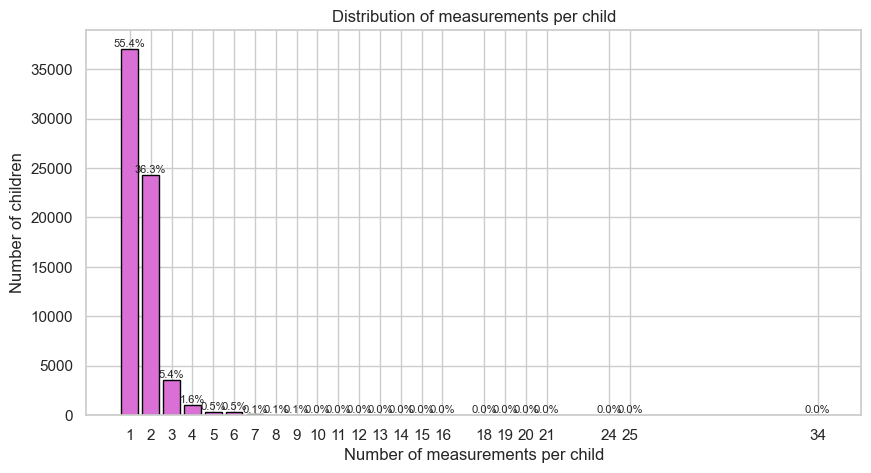

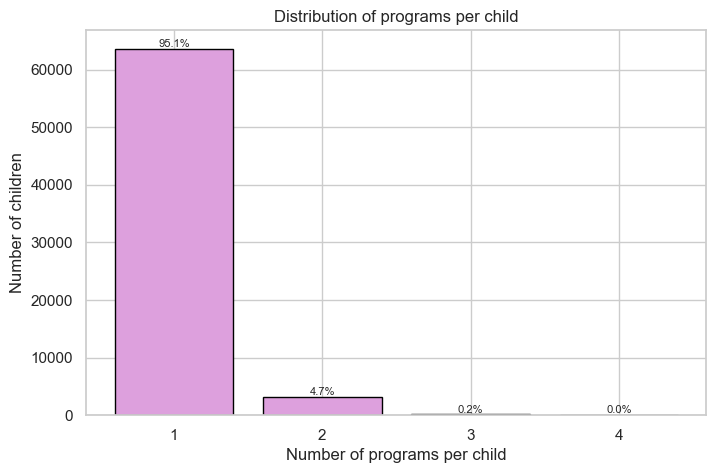

In [17]:
# Visual presentation

import matplotlib.pyplot as plt

# Histogram: number of measurements per child
counts = child_counts["num_measurements"].value_counts().sort_index()
total = counts.sum()

plt.figure(figsize=(10, 5))
bars = plt.bar(counts.index, counts.values, color="orchid", edgecolor="black")

plt.xticks(counts.index)
plt.xlabel("Number of measurements per child")
plt.ylabel("Number of children")
plt.title("Distribution of measurements per child")

for bar, value in zip(bars, counts.values):
    percent = 100 * value / total
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.show()


# Histogram: number of programs per child
counts_prog = programs_per_child["num_programs"].value_counts().sort_index()
total_prog = counts_prog.sum()

plt.figure(figsize=(8, 5))
bars = plt.bar(counts_prog.index, counts_prog.values, color="plum", edgecolor="black")

plt.xticks(counts_prog.index)
plt.xlabel("Number of programs per child")
plt.ylabel("Number of children")
plt.title("Distribution of programs per child")

for bar, value in zip(bars, counts_prog.values):
    percent = 100 * value / total_prog
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.show()


#### 2. Keep only children with at least 2 measurements 

In [18]:
# --- Return to working file ---
import pandas as pd
from pathlib import Path

REVERT_PATH = Path("data/interim/participants_sep23_sep24_after_drop.pkl")
df = pd.read_pickle(REVERT_PATH)

print(f"✅ Successfully loaded Pickle file: {REVERT_PATH.name}")
print(f"Shape: {df.shape}")
print("Sample dtypes:\n", df.dtypes.head())


✅ Successfully loaded Pickle file: participants_sep23_sep24_after_drop.pkl
Shape: (107300, 212)
Sample dtypes:
 ref_id_360           int64
form_type           object
form_version        object
form_date           object
form_filler_role    object
dtype: object


In [19]:
# --- Filter children with at least 2 measurements (no duplicate removal) ---

# Pre-checks
assert "id_number" in df.columns, "Missing 'id_number' column for counting measurements."

# Snapshot before filtering
df_before = df.copy()

# Count measurements per child
child_counts = df.groupby("id_number").size().reset_index(name="num_measurements")

# Identify children with 2+ measurements
ids_min2 = child_counts.loc[child_counts["num_measurements"] >= 2, "id_number"]

# Actual filtering
df = df[df["id_number"].isin(ids_min2)].reset_index(drop=True)

# --- Before–after report ---
before_shape = df_before.shape
after_shape = df.shape
before_kids = df_before["id_number"].nunique()
after_kids = df["id_number"].nunique()
removed_kids = before_kids - after_kids
removed_rows = before_shape[0] - after_shape[0]

print("=== Before–After (filter to 2+ measurements) ===")
print(f"Shape before: {before_shape} | Shape after: {after_shape}")
print(f"Unique children before: {before_kids} | after: {after_kids} | removed: {removed_kids}")
print(f"Rows removed: {removed_rows}")

# Columns added/removed
before_cols = set(df_before.columns)
after_cols = set(df.columns)
removed_cols = sorted(list(before_cols - after_cols))
added_cols = sorted(list(after_cols - before_cols))
print(f"Columns removed: {len(removed_cols)} -> {removed_cols}")
print(f"Columns added:   {len(added_cols)} -> {added_cols}")

# Summary
diff_schema(df_before, df, title="Schema diff: after filtering to 2+ measurements")
quick_data_report(df, title="After filtering to 2+ measurements")
save_snapshot_df(df, "after_filter_min2")

# Save to interim file
from pathlib import Path
MIN2_PATH = "data/interim/participants_sep23_sep24_min2measures.csv"
Path(MIN2_PATH).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(MIN2_PATH, index=False, encoding="utf-8")
print("Saved:", MIN2_PATH)


=== Before–After (filter to 2+ measurements) ===
Shape before: (107300, 212) | Shape after: (69802, 212)
Unique children before: 66955 | after: 29874 | removed: 37081
Rows removed: 37498
Columns removed: 0 -> []
Columns added:   0 -> []
=== Schema diff: after filtering to 2+ measurements ===
Empty DataFrame
Columns: [before, after, changed]
Index: []

=== After filtering to 2+ measurements ===
Shape: (69802, 212)

-- Info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69802 entries, 0 to 69801
Columns: 212 entries, ref_id_360 to parent_complexity
dtypes: bool(8), float64(11), int64(4), object(189)
memory usage: 109.2+ MB

-- Dtypes summary --
object     189
float64     11
bool         8
int64        4
Name: count, dtype: int64

-- Unique values per column (top 10) --
ref_id_360                60396
form_date                 56279
id_number                 29874
strength_domain            7822
service_location           2396
residence_neighborhood     1864
service_code            

## == Analyzing Measurement Duplicates and Time Gaps ==

=== Report: Number of measurements per child (no de-dup) ===
Total unique children (after filtering): 29874
Distribution (measurements → children, percent):
2: 24287 children (81.3%)
3: 3602 children (12.1%)
4: 1055 children (3.5%)
5: 319 children (1.1%)
6: 358 children (1.2%)
7: 69 children (0.2%)
8: 50 children (0.2%)
9: 42 children (0.1%)
10: 20 children (0.1%)
11: 19 children (0.1%)
12: 22 children (0.1%)
13: 4 children (0.0%)
14: 7 children (0.0%)
15: 5 children (0.0%)
16: 5 children (0.0%)
18: 2 children (0.0%)
19: 1 children (0.0%)
20: 2 children (0.0%)
21: 2 children (0.0%)
24: 1 children (0.0%)
25: 1 children (0.0%)
34: 1 children (0.0%)


,Measurements,Children,Percent
0,2,24287,81.3
1,3,3602,12.1
2,4,1055,3.5
3,5,319,1.1
4,6,358,1.2
5,7,69,0.2
6,8,50,0.2
7,9,42,0.1
8,10,20,0.1
9,11,19,0.1


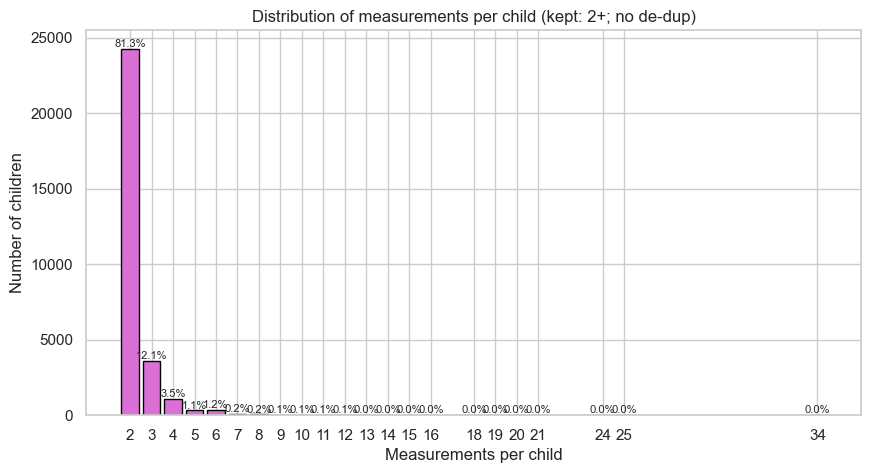

In [20]:
# --- Check number of measurements per child in the filtered dataset ---

import pandas as pd
import matplotlib.pyplot as plt

dist = (
    df.groupby("id_number").size()
      .value_counts()
      .sort_index()
)
total_children = dist.sum()

# Summary report
print("=== Report: Number of measurements per child (no de-dup) ===")
print(f"Total unique children (after filtering): {total_children}")
print("Distribution (measurements → children, percent):")
for k, v in dist.items():
    print(f"{k}: {v} children ({100 * v / total_children:.1f}%)")

# Distribution table
table = pd.DataFrame({
    "Measurements": dist.index,
    "Children": dist.values,
    "Percent": (dist.values / total_children * 100).round(1)
})
display(table)

# Visualization
plt.figure(figsize=(10, 5))
bars = plt.bar(dist.index, dist.values, color="orchid", edgecolor="black")
plt.xticks(dist.index)
plt.xlabel("Measurements per child")
plt.ylabel("Number of children")
plt.title("Distribution of measurements per child (kept: 2+; no de-dup)")

for bar, value in zip(bars, dist.values):
    pct = 100 * value / total_children
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
    )

plt.show()


### Standardizing Date Formats (form_date, join_date, leave_date)

In [21]:
# --- Initial inspection of date columns ---

date_cols = ["form_date", "join_date", "leave_date"]

for col in date_cols:
    print(f"\n=== {col} ===")
    s = df[col].dropna().astype(str)
    print("First sample values:", s.head(10).tolist())
    print("String-length distribution (top 5):")
    print(s.str.len().value_counts().head())
    print("Missing:", df[col].isna().sum(), "| Non-missing:", df[col].notna().sum())

# Frequency check for date columns
for col in ["join_date", "leave_date"]:
    if col in df.columns:
        print(f"\n=== Value frequencies (top 5) – {col} ===")
        print(df[col].value_counts(dropna=True).head(5))



=== form_date ===
First sample values: ['09/30/2024 22:15:35', '09/30/2024 16:52:41', '09/30/2024 16:46:54', '09/30/2024 15:21:46', '09/30/2024 15:21:46', '09/30/2024 13:31:17', '09/30/2024 12:55:52', '09/30/2024 12:55:52', '09/30/2024 11:53:43', '09/30/2024 11:34:26']
String-length distribution (top 5):
form_date
19    44150
16    25652
Name: count, dtype: int64
Missing: 0 | Non-missing: 69802

=== join_date ===
First sample values: ['01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00', '01/01/0001 00:00:00']
String-length distribution (top 5):
join_date
19    69686
16      116
Name: count, dtype: int64
Missing: 0 | Non-missing: 69802

=== leave_date ===
First sample values: ['06/10/2017 07:20', '01/23/2017 14:20:18', '01/23/2017 14:20:18', '03/25/2018 13:47:25', '03/25/2018 13:47:25', '03/25/2018 13:47:25', '03/25/2018 13:47:25', '0

In [22]:
# --- Dropping non-informative date columns ---

cols_to_drop = ["join_date", "leave_date"]

df_before = df.copy()
before_shape = df_before.shape
before_cols = set(df_before.columns)

existing = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=existing, errors="ignore")

after_shape = df.shape
after_cols = set(df.columns)

removed_cols = sorted(list(before_cols - after_cols))
added_cols = sorted(list(after_cols - before_cols))

print("=== Before–After: Removing non-informative date columns ===")
print(f"Shape before: {before_shape} | Shape after: {after_shape}")
print(f"Columns removed ({len(removed_cols)}): {removed_cols}")
print(f"Columns added   ({len(added_cols)}): {added_cols}")

# Summary
diff_schema(df_before, df, title="Schema diff: after dropping non-needed date columns")
quick_data_report(df, title="After dropping non-needed date columns")
save_snapshot_df(df, "after_drop_non_needed_dates")


=== Before–After: Removing non-informative date columns ===
Shape before: (69802, 212) | Shape after: (69802, 210)
Columns removed (2): ['join_date', 'leave_date']
Columns added   (0): []
=== Schema diff: after dropping non-needed date columns ===
            before after  changed
join_date   object   NaN     True
leave_date  object   NaN     True

=== After dropping non-needed date columns ===
Shape: (69802, 210)

-- Info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69802 entries, 0 to 69801
Columns: 210 entries, ref_id_360 to parent_complexity
dtypes: bool(8), float64(11), int64(4), object(187)
memory usage: 108.1+ MB

-- Dtypes summary --
object     187
float64     11
bool         8
int64        4
Name: count, dtype: int64

-- Unique values per column (top 10) --
ref_id_360                60396
form_date                 56279
id_number                 29874
strength_domain            7822
service_location           2396
residence_neighborhood     1864
service_code           

'artifacts\\20251113-123521_after_drop_non_needed_dates'

In [23]:
# --- Standardization and validation of dates: cleaning and unifying formats ---

from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import re

# Save previous state
df_before = df.copy()
before_cols = set(df_before.columns)
before_shape = df_before.shape

COL = "form_date"
assert COL in df.columns, "Missing 'form_date' column."

# Clean raw date strings (spaces, hidden chars, separators)
s = df[COL].astype(str)
s = (
    s.str.strip()
     .str.replace(r"\u200f|\u200e", "", regex=True)   # remove hidden RTL/LTR marks
     .str.replace(r"[.\-]", "/", regex=True)          # replace '.' and '-' with '/'
     .str.replace(r"\s+", " ", regex=True)            # multiple spaces → single space
     .str.replace("T", " ", regex=False)              # ISO 'T' → space
     .str.replace(r"‏", "", regex=False)              # another common RTL mark
)

# Helper: coalesce series by priority order
def coalesce(series_list):
    out = None
    for ser in series_list:
        out = ser if out is None else out.fillna(ser)
    return out

# Try multiple parsing strategies and keep candidates
cand = {}

# Automatic detection with day-first / month-first
cand["auto_dayfirst"] = pd.to_datetime(
    s, errors="coerce", dayfirst=True, infer_datetime_format=True
)
cand["auto_monthfirst"] = pd.to_datetime(
    s, errors="coerce", dayfirst=False, infer_datetime_format=True
)

# Explicit DMY formats (Israeli-style, with/without time)
for name, fmt in [
    ("dmy_HMS", "%d/%m/%Y %H:%M:%S"),
    ("dmy_HM",  "%d/%m/%Y %H:%M"),
    ("dmy_date", "%d/%m/%Y"),
    ("dmy_HM_ampm", "%d/%m/%Y %I:%M %p"),
    ("dmy_shortyear_HM", "%d/%m/%y %H:%M"),
]:
    cand[name] = pd.to_datetime(s, format=fmt, errors="coerce")

# Explicit MDY formats (US-style)
for name, fmt in [
    ("mdy_HMS", "%m/%d/%Y %H:%M:%S"),
    ("mdy_HM",  "%m/%d/%Y %H:%M"),
    ("mdy_date", "%m/%d/%Y"),
    ("mdy_HM_ampm", "%m/%d/%Y %I:%M %p"),
    ("mdy_shortyear_HM", "%m/%d/%y %H:%M"),
]:
    cand[name] = pd.to_datetime(s, format=fmt, errors="coerce")

# ISO-like parsing (fallback)
cand["ISO_full"] = pd.to_datetime(df[COL], errors="coerce")

# Excel serial numbers (days since 1899-12-30)
is_num = s.str.fullmatch(r"\d+(\.\d+)?", na=False)
cand["excel_serial"] = pd.to_datetime(
    pd.to_numeric(s.where(is_num), errors="coerce"),
    unit="D",
    origin="1899-12-30",
    errors="coerce",
)

# Choose the “best” candidate by scoring: valid and in a plausible range
min_ok, max_ok = pd.Timestamp("2023-09-01"), pd.Timestamp("2025-09-30")

def score(series: pd.Series) -> int:
    ok = series.notna()
    in_range = ok & (series >= min_ok) & (series <= max_ok)
    # High weight for in-range values, then for total valid
    return in_range.sum() * 1_000_000 + ok.sum()

best_key = max(cand, key=lambda k: score(cand[k]))
best_ser = cand[best_key]

print("=== Best parser selection ===")
print(f"Chosen parser key: {best_key}")
print(
    "Valid and in range:",
    (((best_ser.notna()) & (best_ser.between(min_ok, max_ok))).sum())
)
print(
    f"Total valid: {best_ser.notna().sum():,} | NaT: {len(best_ser) - best_ser.notna().sum():,}"
)

# Coalesce candidates by priority: best first, then others
order_keys = [best_key] + [k for k in cand.keys() if k != best_key]
form_dt_new = coalesce([cand[k] for k in order_keys])

# Create/extend unified datetime column
old_ok = df.get("form_dt").notna().sum() if "form_dt" in df.columns else 0
if "form_dt" in df.columns:
    df["form_dt"] = df["form_dt"].fillna(form_dt_new)
else:
    df["form_dt"] = form_dt_new

new_ok = df["form_dt"].notna().sum()
print("\n=== Coverage improvement ===")
print(f"Valid before: {old_ok:,} | Valid now: {new_ok:,} | Gain: {new_ok - old_ok:,}")

# Derived date fields
df["form_day"] = df["form_dt"].dt.normalize()
df["form_year"] = df["form_dt"].dt.year
df["form_month"] = df["form_dt"].dt.month

# Inspect values that are still not recognized as dates
bad = df.loc[df["form_dt"].isna(), COL].astype(str)
print("\n=== Sample of values not parsed (up to 30) ===")
print(bad.drop_duplicates().head(30).to_list())

def patternize(x: str) -> str:
    """Simple pattern abstraction for remaining unparsed values."""
    x = re.sub(r"\d", "9", x)
    x = re.sub(r"[A-Za-zא-ת]", "a", x)
    x = re.sub(r"\s+", " ", x.strip())
    return x

pat_counts = bad.map(patternize).value_counts().head(20)
print("\n=== Top 20 patterns among unparsed values ===")
print(pat_counts)

# Compare structure before/after
after_cols = set(df.columns)
added_cols = sorted(list(after_cols - before_cols))
removed_cols = sorted(list(before_cols - after_cols))

print("\n=== Schema changes ===")
print(f"Shape before: {before_shape} | Shape after: {df.shape}")
print(f"Removed columns ({len(removed_cols)}): {removed_cols}")
print(f"Added columns   ({len(added_cols)}): {added_cols}")

# Save outputs
OUT_PATH = Path("data/interim/participants_sep23_sep24_after_formdate_fix.csv")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT_PATH, index=False, encoding="utf-8")
df.to_pickle(OUT_PATH.with_suffix(".pkl"))

print("\n✅ Main working files saved:")
print("   CSV →", OUT_PATH.resolve())
print("   PKL →", OUT_PATH.with_suffix(".pkl").resolve())

# Timestamped backup
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
backup_pkl = OUT_PATH.with_name(f"{OUT_PATH.stem}_{ts}.pkl")
df.to_pickle(backup_pkl)

print("\nBackup:")
print("   PKL (timestamped) →", backup_pkl.resolve())
print("Shape:", df.shape)

# Final summary
parsed = df["form_dt"].notna().sum()
total = len(df)
print("\n=== Date parsing summary ===")
print(f"Successfully parsed: {parsed}/{total} ({parsed/total:.1%})")
print(f"Not parsed (NaT): {total - parsed}")
if parsed:
    print("Date range:", df["form_dt"].min(), "to", df["form_dt"].max())

# Year–month distribution (sanity check for gaps)
ym = (
    df.dropna(subset=["form_dt"])
      .assign(_ym=df["form_dt"].dt.to_period("M"))
      .groupby("_ym")
      .size()
      .reset_index(name="rows")
)
ym["_ym"] = ym["_ym"].astype(str)
display(ym.head(12))


=== Best parser selection ===
Chosen parser key: auto_dayfirst
Valid and in range: 44150
Total valid: 44,150 | NaT: 25,652

=== Coverage improvement ===
Valid before: 0 | Valid now: 69,802 | Gain: 69,802

=== Sample of values not parsed (up to 30) ===
[]

=== Top 20 patterns among unparsed values ===
Series([], Name: count, dtype: int64)

=== Schema changes ===
Shape before: (69802, 210) | Shape after: (69802, 214)
Removed columns (0): []
Added columns   (4): ['form_day', 'form_dt', 'form_month', 'form_year']

✅ Main working files saved:
   CSV → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_sep23_sep24_after_formdate_fix.csv
   PKL → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_sep23_sep24_after_formdate_fix.pkl

Backup:
   PKL (timestamped) → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\p

,_ym,rows
0,2023-01,208
1,2023-02,318
2,2023-03,400
3,2023-04,402
4,2023-05,500
5,2023-06,481
6,2023-07,597
7,2023-08,254
8,2023-09,681
9,2023-10,1239


### == Detection and Analysis of Form Duplicates and Time Gaps Between Measurements ==

In [24]:
# 1) Identify same-day duplicates for the same child (no deletion)

import pandas as pd
from pathlib import Path

# Pre-checks
assert "id_number" in df.columns, "Missing 'id_number' column."
assert "program_code" in df.columns, "Missing 'program_code' column."
assert ("form_day" in df.columns) or ("form_dt" in df.columns) or ("form_date" in df.columns), \
    "Missing a date column (form_day / form_dt / form_date)."

# Snapshot before
df_before = df.copy()
before_cols = set(df_before.columns)
before_shape = df_before.shape

# Normalize date — create a standard day-level column (date without time)
if "form_day" not in df.columns:
    if "form_dt" in df.columns:
        df["form_dt"] = pd.to_datetime(df["form_dt"], errors="coerce")
        df["form_day"] = df["form_dt"].dt.normalize()
    else:
        df["form_date"] = pd.to_datetime(df["form_date"], errors="coerce")
        df["form_day"] = df["form_date"].dt.normalize()

# Sort by: date → child → locality → program code
sort_keys = [k for k in ["form_day", "id_number", "yeshuv_name", "program_code"] if k in df.columns]
df = df.sort_values(sort_keys, kind="mergesort").reset_index(drop=True)

# Count forms on the same day for the same child–locality–program group
group_keys = [k for k in ["id_number", "form_day", "yeshuv_name", "program_code"] if k in df.columns]
df["forms_same_day"] = df.groupby(group_keys)["id_number"].transform("size").astype("Int64")

# Flag primary record and duplicates within each group
df["is_primary"] = df.groupby(group_keys).cumcount().eq(0).astype("Int64")  # 1 = first record in group
df["is_duplicate"] = (df["forms_same_day"].gt(1) & df["is_primary"].eq(0)).astype("Int64")

# Before–after: columns added/removed
after_cols = set(df.columns)
added_cols = sorted(list(after_cols - before_cols))
removed_cols = sorted(list(before_cols - after_cols))

print("=== Before–After: duplicate detection fields ===")
print(f"Shape before: {before_shape} | Shape after: {df.shape} (no row changes)")
print(f"Added columns   ({len(added_cols)}): {added_cols}")
print(f"Removed columns ({len(removed_cols)}): {removed_cols}")

# Short duplicate report
total = len(df)
dup_recs = int((df["forms_same_day"] > 1).sum())
print("\n=== Same-day duplicates report ===")
print(f"Total records: {total:,}")
print(f"Records in duplicate groups (2+ in same-day group): {dup_recs:,} ({dup_recs / total:.1%})")
print(f"Unique children: {df['id_number'].nunique():,}")

# Save to a dedicated file for the duplicates stage
DUP_PATH = "data/interim/participants_sep23_sep24_duplicates_analysis.csv"
Path(DUP_PATH).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(DUP_PATH, index=False, encoding="utf-8")
print("\nDuplicates analysis file saved:", DUP_PATH)

# Summary
diff_schema(df_before, df, title="Schema diff: after adding duplicate flags")
quick_data_report(df, title="After adding duplicate flags (no deletion)")
save_snapshot_df(df, "after_dup_fields_added")


=== Before–After: duplicate detection fields ===
Shape before: (69802, 214) | Shape after: (69802, 217) (no row changes)
Added columns   (3): ['forms_same_day', 'is_duplicate', 'is_primary']
Removed columns (0): []

=== Same-day duplicates report ===
Total records: 69,802
Records in duplicate groups (2+ in same-day group): 16,280 (23.3%)
Unique children: 29,874

Duplicates analysis file saved: data/interim/participants_sep23_sep24_duplicates_analysis.csv
=== Schema diff: after adding duplicate flags ===
               before  after  changed
forms_same_day    NaN  Int64     True
is_duplicate      NaN  Int64     True
is_primary        NaN  Int64     True

=== After adding duplicate flags (no deletion) ===
Shape: (69802, 217)

-- Info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69802 entries, 0 to 69801
Columns: 217 entries, ref_id_360 to is_duplicate
dtypes: Int64(3), bool(8), datetime64[ns](2), float64(11), int32(2), int64(4), object(187)
memory usage: 111.5+ MB

-- Dtypes summ

'artifacts\\20251113-123852_after_dup_fields_added'

,Forms_per_child_day_locality_program,Records,Percent_of_records
0,2,4316,68.2
1,3,1368,21.6
2,4,327,5.2
3,5,52,0.8
4,6,171,2.7
5,7,17,0.3
6,8,32,0.5
7,9,20,0.3
8,10,3,0.0
9,12,15,0.2


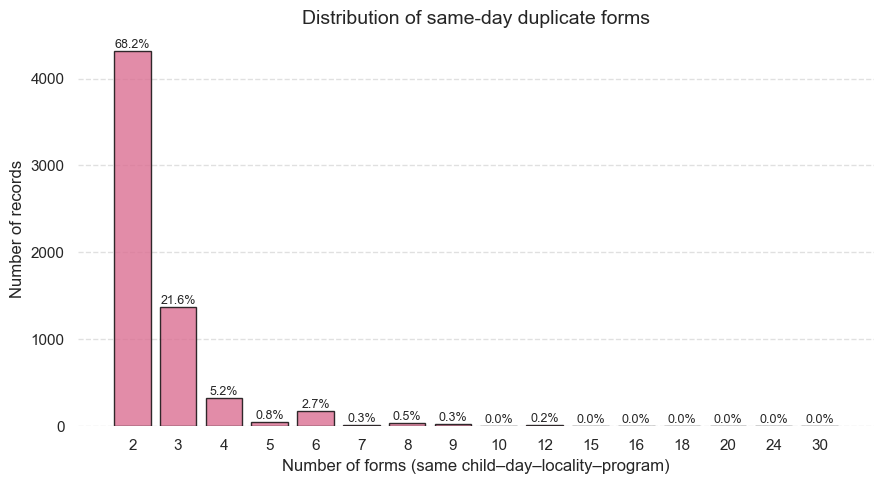

In [25]:
# 2) Mapping same-day duplicate forms for the same child–locality–program (no deletion yet)

import matplotlib.pyplot as plt
import pandas as pd

# Grouping keys: child–day–locality–program
group_keys = [k for k in ["id_number", "form_day", "yeshuv_name", "program_code"] if k in df.columns]

dup_group_sizes = (
    df.loc[df["forms_same_day"].gt(1), group_keys]
      .value_counts()
      .reset_index(name="n_forms")
      .groupby("n_forms")
      .size()
      .sort_index()
)

if dup_group_sizes.empty:
    print("No same-day duplicates found.")
else:
    total_records = dup_group_sizes.sum()

    # --- Table ---
    table = pd.DataFrame({
        "Forms_per_child_day_locality_program": dup_group_sizes.index,
        "Records": dup_group_sizes.values,
        "Percent_of_records": (dup_group_sizes.values / total_records * 100).round(1)
    })
    display(table)

    # --- Plot ---
    plt.figure(figsize=(9, 5))
    bars = plt.bar(
        dup_group_sizes.index.astype(str),
        dup_group_sizes.values,
        color="#DB7093",
        edgecolor="black",
        alpha=0.8,
    )
    plt.grid(False)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.box(False)
    plt.xlabel("Number of forms (same child–day–locality–program)")
    plt.ylabel("Number of records")
    plt.title("Distribution of same-day duplicate forms", fontsize=14)

    for b, v in zip(bars, dup_group_sizes.values):
        pct = 100 * v / total_records
        plt.text(
            b.get_x() + b.get_width() / 2,
            b.get_height(),
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()


=== Before–after: Child time-gap computation ===
Shape before: (69,802, 217) | Shape after: (69,802, 219)
Columns added (2): ['days_diff_child', 'gap_bucket_child']
Columns removed (0): []


,Range,Count,Percent
0,Negative (error),0,0.0
1,Same day (0),10049,14.4
2,1–90 days,7133,10.2
3,91–180 days,11509,16.5
4,181–365 days,9797,14.0
5,>365 days,1440,2.1
6,NaN,29874,42.8


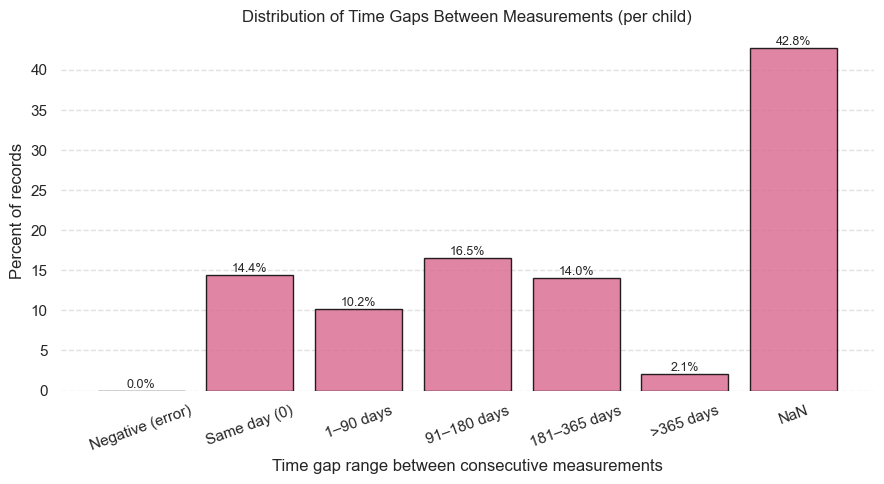

In [26]:
# 3) Compute time gaps between consecutive forms for the same child

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Snapshot before
before_cols, rows_before, cols_before = snapshot_cols(df)

# Normalize the base date column
if "form_day" in df.columns:
    df["form_day"] = pd.to_datetime(df["form_day"], errors="coerce")
elif "form_dt" in df.columns:
    df["form_dt"] = pd.to_datetime(df["form_dt"], errors="coerce")
    df["form_day"] = df["form_dt"].dt.normalize()
elif "form_date" in df.columns:
    df["form_date"] = pd.to_datetime(df["form_date"], errors="coerce")
    df["form_day"] = df["form_date"].dt.normalize()
else:
    raise AssertionError("Missing a date column (form_day / form_dt / form_date).")

# Count non-parsed dates
bad_dates = df["form_day"].isna().sum()
if bad_dates:
    print(f"{bad_dates:,} records with invalid (NaT) date after conversion.")

# Sort properly before computing day differences
sort_keys = [k for k in ["id_number", "form_day", "yeshuv_name", "program_code"] if k in df.columns]
df = df.sort_values(sort_keys, kind="mergesort").reset_index(drop=True)

# Compute gap in days from the previous form for the same child
df["days_diff_child"] = df.groupby("id_number")["form_day"].diff().dt.days

# Bucketize gaps
bins_en = [-10_000, -1, 0, 90, 180, 365, 10_000]
labels_en = [
    "Negative (error)",
    "Same day (0)",
    "1–90 days",
    "91–180 days",
    "181–365 days",
    ">365 days",
]
cat_type = pd.api.types.CategoricalDtype(categories=labels_en, ordered=True)

df["gap_bucket_child"] = pd.cut(df["days_diff_child"], bins=bins_en, labels=labels_en).astype(cat_type)

# Before–after report (columns added)
after_cols, rows_after, cols_after = snapshot_cols(df)
report_changes("Child time-gap computation", before_cols, after_cols, rows_before, rows_after)

# Summary table
counts = df["gap_bucket_child"].value_counts(dropna=False)
order_idx = pd.CategoricalIndex(labels_en, ordered=True)
counts_ord = counts.reindex(order_idx, fill_value=0)

na_cnt = counts.loc[pd.isna(counts.index)].sum() if counts.index.isna().any() else 0

summary = counts_ord.reset_index()
summary.columns = ["Range", "Count"]

if na_cnt:
    summary = pd.concat(
        [summary, pd.DataFrame([{"Range": "NaN", "Count": int(na_cnt)}])],
        ignore_index=True
    )

summary["Percent"] = (summary["Count"] / summary["Count"].sum() * 100).round(1)

display(summary)

# Bar plot
plt.figure(figsize=(9, 5))
x_labels = summary["Range"].astype(str)
bars = plt.bar(
    x_labels,
    summary["Percent"],
    color="#DB7093",
    edgecolor="black",
    alpha=0.85
)

plt.grid(False)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.box(False)
plt.xlabel("Time gap range between consecutive measurements")
plt.ylabel("Percent of records")
plt.title("Distribution of Time Gaps Between Measurements (per child)")

for rect, val in zip(bars, summary["Percent"]):
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        val,
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [27]:
# --- Decompose missing values in days_diff_child by reason ---
import pandas as pd

is_first_row = (
    df.sort_values(["id_number", "form_day"])
      .groupby("id_number")
      .cumcount() == 0
)

reason_first = (is_first_row & df["days_diff_child"].isna()).sum()
reason_missing = df["form_day"].isna().sum()   # rows with missing/invalid date
total_nan = df["days_diff_child"].isna().sum()

print('Total NaN in "days_diff_child":', total_nan)
print("Of which — first row per child:", reason_first)
print("Of which — missing/invalid form_day:", reason_missing)
print("Other reasons (if any):", total_nan - reason_first - reason_missing)


Total NaN in "days_diff_child": 29874
Of which — first row per child: 29874
Of which — missing/invalid form_day: 0
Other reasons (if any): 0


Conclusion: Missing values in `days_diff_child` occur because the time gap is defined only relative to a previous form for the same child. For the first measurement of each child, there is no earlier form to compare to, so no time difference can be computed. Therefore, the time gap for all first records per child is NaN by definition, and gaps are calculated only from the second record onward.


### Building the RS/RI Form Completeness Indicator

In [28]:
# Building completeness index for risk states 1–28
import re
import pandas as pd

# Snapshot before (for later comparison)
before_cols, rows_before, cols_before = snapshot_cols(df)

# Identify rs/ri columns for risk states 1–28
pat = re.compile(r"^(rs|ri)\s*_*\s*0*([0-9]{1,2})(?=\D|$)", flags=re.IGNORECASE)
matches = []
for col in df.columns:
    m = pat.match(str(col))
    if m:
        num = int(m.group(2))
        if 1 <= num <= 28:
            matches.append((col, num))

if not matches:
    raise ValueError("No rs/ri columns found for risk states 1–28. Please check column names.")

# Aggregate by item number: “answered” if at least one column for that item is non-missing
by_item = {}
for col, num in matches:
    by_item.setdefault(num, []).append(col)

items_matrix = pd.DataFrame(
    {k: df[v].notna().any(axis=1) for k, v in sorted(by_item.items())},
    index=df.index
)

# Table 1: completion count and rate for each of the 28 items
n_forms = len(items_matrix)
fills_per_item = items_matrix.sum(axis=0).astype(int)
rate_per_item = (fills_per_item / n_forms * 100).round(1)

item_summary = (
    pd.DataFrame({
        "Risk_item": [f"{i:02d}" for i in items_matrix.columns],
        "Forms_with_item": fills_per_item.values,
        "Completion_rate_pct": rate_per_item.values,
    })
    .sort_values("Risk_item", key=lambda s: s.astype(int))
    .reset_index(drop=True)
)

print("Table 1: Completion rates for each risk item (1–28)")
display(item_summary)

# Table 2: distribution of number of completed risk items per form (0–28)
filled_count_per_form = items_matrix.sum(axis=1).astype(int)

dist_forms = (
    filled_count_per_form.value_counts()
    .rename_axis("Items_answered_in_form")
    .reset_index(name="Number_of_forms")
    .sort_values("Items_answered_in_form", ascending=False)
)

dist_forms["Percent_of_forms"] = (
    dist_forms["Number_of_forms"] / n_forms * 100
).round(1)

print("\nTable 2: Distribution of number of completed risk items per form")
display(dist_forms)

# New columns: form-level completeness measures
df["rs_items_answered"] = filled_count_per_form
df["rs_completion_pct"] = (filled_count_per_form / items_matrix.shape[1] * 100).round(1)

# Remove legacy completion score column, if present
if "ציון מילוי כולל" in df.columns:
    df.drop(columns=["ציון מילוי כולל"], inplace=True)

# Before–after report
after_cols, rows_after, cols_after = snapshot_cols(df)
report_changes(
    "RS/RI — add rs_items_answered + rs_completion_pct",
    before_cols, after_cols, rows_before, rows_after
)

# Save outputs
item_summary.to_csv(
    INTERIM / "rsri_item_completion_summary.csv",
    index=False,
    encoding="utf-8-sig"
)
dist_forms.to_csv(
    INTERIM / "rsri_form_completion_distribution.csv",
    index=False,
    encoding="utf-8-sig"
)
df.to_pickle(PROCESSED / "participants_after_rsri_completion.pkl")

print("Saved: item summary table, form distribution table, and updated participants Pickle.")


Table 1: Completion rates for each risk item (1–28)


,Risk_item,Forms_with_item,Completion_rate_pct
0,01,69790,100.0
1,02,69790,100.0
2,03,69790,100.0
3,04,69790,100.0
4,05,69790,100.0
5,06,69790,100.0
6,07,69790,100.0
7,08,69790,100.0
8,09,69790,100.0
9,10,69790,100.0



Table 2: Distribution of number of completed risk items per form


,Items_answered_in_form,Number_of_forms,Percent_of_forms
0,28,36136,51.8
2,25,3429,4.9
1,24,30225,43.3
3,0,12,0.0


=== Before–after: RS/RI — add rs_items_answered + rs_completion_pct ===
Shape before: (69,802, 219) | Shape after: (69,802, 221)
Columns added (2): ['rs_completion_pct', 'rs_items_answered']
Columns removed (0): []
Saved: item summary table, form distribution table, and updated participants Pickle.


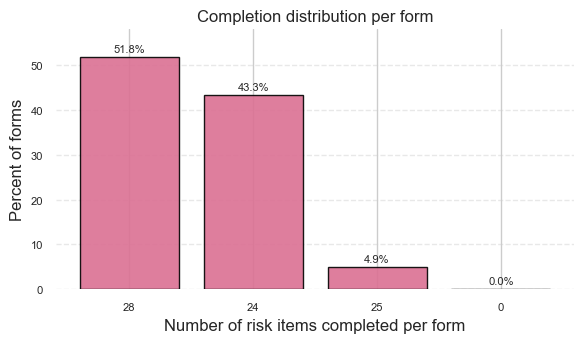

In [29]:
# === Compact bar chart for Table 2 (English axes) ===
import matplotlib.pyplot as plt

# Sort by percentage (English column names will be used from now on)
dist_sorted = dist_forms.sort_values("Percent_of_forms", ascending=False).reset_index(drop=True)

x = dist_sorted["Items_answered_in_form"].astype(str)
y = dist_sorted["Percent_of_forms"]

plt.figure(figsize=(6, 3.6))  # more compact figure
bars = plt.bar(x, y, color="#DB7093", edgecolor="black", alpha=0.9)

plt.xlabel("Number of risk items completed per form")
plt.ylabel("Percent of forms")
plt.title("Completion distribution per form", fontsize=12)

# Add percentage labels above bars
y_max = y.max() if len(y) else 0
offset = y_max * 0.015 if y_max else 0.5

for rect, val in zip(bars, y):
    plt.text(
        rect.get_x() + rect.get_width() / 2,
        val + offset,
        f"{val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.ylim(0, y_max * 1.12 if y_max else 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis="y", linestyle="--", alpha=0.45)
plt.box(False)
plt.tight_layout()
plt.show()

# === Save outputs ===
item_summary.to_csv(
    INTERIM / "rsri_item_completion_summary.csv",
    index=False,
    encoding="utf-8-sig"
)

dist_forms.to_csv(
    INTERIM / "rsri_form_completion_distribution.csv",
    index=False,
    encoding="utf-8-sig"
)


Approximately half of all forms are fully complete across all 28 risk items, and an additional ~40% are nearly complete, containing 24 answered risk items. This indicates a generally high level of form complet


In [28]:
print("Current shape:", df.shape)
print("First columns:", df.columns[:10].to_list())
print("Sample dates:", df["form_dt"].dropna().head(3).to_list())


Current shape: (69802, 221)
First columns: ['ref_id_360', 'form_type', 'form_version', 'form_date', 'form_filler_role', 'yeshuv_code', 'yeshuv_name', 'machoz', 'institution_type', 'institution_code']
Sample dates: [Timestamp('2023-12-28 13:53:32'), Timestamp('2024-02-06 17:31:00'), Timestamp('2024-06-16 14:38:02')]


In [30]:
# Create a working copy
merg = df.copy()

# Save as a new file
out_path = "data/interim/participants_sep23_sep24_merg.csv"
Path("data/interim").mkdir(parents=True, exist_ok=True)

merg.to_csv(out_path, index=False, encoding="utf-8")

print("Saved new file:", out_path)
print("merg shape:", merg.shape)


Saved new file: data/interim/participants_sep23_sep24_merg.csv
merg shape: (69802, 221)


### Merging Forms into Paired Measurements

In [31]:
import pandas as pd

# --- Load file with duplicate-analysis results ---
df = pd.read_csv(
    "data/interim/participants_sep23_sep24_duplicates_analysis.csv",
    parse_dates=["form_dt"]   # Ensure datetime parsing
)

# --- Quick checks ---
print("Shape:", df.shape)
print("Dtype of form_dt:", df["form_dt"].dtype)

# --- Count unique children ---
n_children = df["id_number"].nunique()
print(f"\n[Children] Unique children: {n_children:,}")

# --- Children with more than one form overall (any date) ---
children_counts = df.groupby("id_number").size()
n_children_multi_any = (children_counts > 1).sum()
print(f"[Children] With 2+ forms (any dates): {n_children_multi_any:,} ({n_children_multi_any/n_children:.1%})")

# --- Rows belonging to same-day multi-form groups ---
same_day_rows = df[df["forms_same_day"].fillna(0) >= 2]
n_rows_in_same_day_groups = same_day_rows.shape[0]
print(f"\n[Same-day] Rows in same-day groups: {n_rows_in_same_day_groups:,} ({n_rows_in_same_day_groups/len(df):.1%})")

# --- Children with ≥1 same-day duplicate ---
n_children_with_same_day_dup = same_day_rows["id_number"].nunique()
print(f"[Same-day] Children with ≥1 duplicated day: {n_children_with_same_day_dup:,} ({n_children_with_same_day_dup/n_children:.1%})")

# --- Distribution of number of forms per (child–service–yeshuv–day) ---
same_day_size_dist = (
    df["forms_same_day"]
      .dropna()
      .astype(int)
      .value_counts()
      .sort_index()
)

print("\n[Same-day] Distribution of forms per child–service–yeshuv–day:")
print(same_day_size_dist.to_string())

# --- Small random sample for inspection ---
print("\n[Sample] Random 5 rows:")
display(df[[
    "id_number",
    "yeshuv_code",
    "service_code",
    "form_dt",
    "forms_same_day",
    "is_duplicate",
    "is_primary"
]].sample(5, random_state=42))


Shape: (69802, 217)
Dtype of form_dt: datetime64[ns]

[Children] Unique children: 29,874
[Children] With 2+ forms (any dates): 29,874 (100.0%)

[Same-day] Rows in same-day groups: 16,280 (23.3%)
[Same-day] Children with ≥1 duplicated day: 5,479 (18.3%)

[Same-day] Distribution of forms per child–service–yeshuv–day:
forms_same_day
1     53522
2      8632
3      4104
4      1308
5       260
6      1026
7       119
8       256
9       180
10       30
12      180
15       45
16       48
18       18
20       20
24       24
30       30

[Sample] Random 5 rows:


,id_number,yeshuv_code,service_code,form_dt,forms_same_day,is_duplicate,is_primary
52456,40792146e54cb4aa3336781bd97cd6f65830f7fae51243...,8380,2220154-003020,2024-06-24 11:25:15,1,0,1
20290,cd2897718805894a93c2105e5165d21e5224a13e468aed...,5800,2220118-004226,2023-12-30 18:10:17,1,0,1
46206,c75fd4e69b7f99bfea91da461b5c067ca281ae1974c22d...,8420,122600506-001903,2024-05-31 09:28:31,1,0,1
27252,a3248d5c54007454447e250af315f83a7dcea37b5ea519...,3200,2230029-000628,2024-01-30 11:23:02,1,0,1
5929,eb8519d775997f43539ba36d5d92ed3ceda9ee55f67558...,8730,2210267-002149,2023-11-13 10:04:32,1,0,1


In [34]:
# Preliminary checks and key variable setup
import pandas as pd
import numpy as np
import re
from pathlib import Path
from pandas.api.types import is_datetime64_any_dtype as is_dt

def banner(title: str) -> None:
    print("\n" + "=" * 12 + f" {title} " + "=" * 12)

banner("Step 0 • Preliminary checks")

# Ensure data exists and required columns are present
req_cols = ["id_number", "service_code", "form_dt"]
missing = [c for c in req_cols if c not in df.columns]
assert not missing, f"Missing required columns: {missing}"

# If yeshuv_code exists, include it in the key; otherwise run without it
key_cols = [c for c in ["id_number", "service_code", "yeshuv_code"] if c in df.columns]

print("Shape:", df.shape)
print("Key columns:", key_cols)
print("form_dt dtype:", df["form_dt"].dtype)

# Ensure form_dt is actually datetime
if not is_dt(df["form_dt"]):
    df["form_dt"] = pd.to_datetime(df["form_dt"], errors="coerce")

print("Missing form_dt (NaT):", df["form_dt"].isna().sum())



============ Step 0 • Preliminary checks ============
Shape: (69802, 217)
Key columns: ['id_number', 'service_code', 'yeshuv_code']
form_dt dtype: datetime64[ns]
Missing form_dt (NaT): 0


In [36]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from pandas.api.types import is_datetime64_any_dtype as is_dt
import matplotlib.pyplot as plt

def banner(text: str) -> None:
    print("\n" + "=" * 10 + " " + text + " " + "=" * 10)

# Step 0: quick checks
banner("Step 0 • Quick checks")

required_cols = ["id_number", "service_code", "form_dt"]
missing_required = [c for c in required_cols if c not in df.columns]
assert not missing_required, f"Missing required columns: {missing_required}"

# Ensure form_dt is datetime
if not is_dt(df["form_dt"]):
    df["form_dt"] = pd.to_datetime(df["form_dt"], errors="coerce")

# Key columns for grouping: if yeshuv_code exists, include it
key_cols = [c for c in ["id_number", "service_code", "yeshuv_code"] if c in df.columns]

print("Data shape:", df.shape)
print("Key columns:", key_cols)
print("form_dt dtype:", df["form_dt"].dtype)
print("Missing form_dt (NaT):", df["form_dt"].isna().sum())

# Step 1: select a primary form per child–service–locality–day
# Criteria: higher risk-item completeness → later time → row index tiebreaker

# 1) Risk completeness: number of answered risk items (rs/ri 1–28)
pat = re.compile(r"^(rs|ri)\s*_*\s*0*([0-9]{1,2})(?=\D|$)", flags=re.IGNORECASE)

risk_cols = [
    c
    for c in df.columns
    if (m := pat.match(str(c))) and 1 <= int(m.group(2)) <= 28
    and not any(s in c.lower() for s in ("_num", "__flag", "_flag", "__unknown_flag", "_label"))
]

groups = {}
for c in risk_cols:
    item_num = int(pat.match(c).group(2))
    groups.setdefault(item_num, []).append(c)

if risk_cols:
    df["_risk_complete"] = pd.DataFrame(
        {k: df[v].notna().any(axis=1) for k, v in groups.items()},
        index=df.index,
    ).sum(axis=1)
else:
    df["_risk_complete"] = 0

# 2) Day-level date (without time) for “same-day” grouping
df["_day"] = df["form_dt"].dt.normalize()

# 3) Priority order within each day:
#    higher completeness → later time → row index tiebreaker
df["_row_order"] = np.arange(len(df))

df = df.sort_values(
    by=key_cols + ["_day", "_risk_complete", "form_dt", "_row_order"],
    ascending=[True] * len(key_cols) + [True, False, False, False],
)

# 4) Mark primary form per child–service–locality–day (first in sorted order)
df["_rank_in_day"] = df.groupby(key_cols + ["_day"]).cumcount()
df["is_primary_same_day"] = (df["_rank_in_day"] == 0).astype(int)

# 5) Keep only one row per day: the primary form
df_day_primary = df.loc[df["is_primary_same_day"] == 1].copy()

# Summary report
banner("Summary • Primary form selection per day")
rows_before = len(df)
rows_after = len(df_day_primary)
multi_day_groups = (df.groupby(key_cols + ["_day"]).size() > 1).sum()

print(f"- Rows before filtering: {rows_before:,}")
print(f"- Rows after filtering:  {rows_after:,}")
print(f"- Rows removed (same-day duplicates): {rows_before - rows_after:,}")
print(f"- Number of days with multiple forms per child–service–locality: {multi_day_groups:,}")
print("- Conclusion: there is now exactly one primary row per child–service–locality for each day.")



========== Step 0 • Quick checks ==========
Data shape: (69802, 222)
Key columns: ['id_number', 'service_code', 'yeshuv_code']
form_dt dtype: datetime64[ns]
Missing form_dt (NaT): 0

========== Summary • Primary form selection per day ==========
- Rows before filtering: 69,802
- Rows after filtering:  59,857
- Rows removed (same-day duplicates): 9,945
- Number of days with multiple forms per child–service–locality: 6,327
- Conclusion: there is now exactly one primary row per child–service–locality for each day.


In [37]:
# --- How often did we decide by completeness, by time, or by technical tie-break? ---

# --- Analysis: why was a specific form chosen as the “primary” one (only on days with duplicates) ---

banner("Analysis • Why a specific form was chosen as primary for the day")

# Group by child–service–locality–day
grp = df.groupby(key_cols + ["_day"])

# Only days where there is more than one form
dup_days_idx = grp.size()[grp.size() > 1].index
mask_dup_days = df.set_index(key_cols + ["_day"]).index.isin(dup_days_idx)
df_dups = df.loc[mask_dup_days].copy()

# Function to determine the “reason for choice”
# Priority: higher completion → later time → full tie (technical decision)
def reason_for_choice(g: pd.DataFrame) -> str:
    g = g.sort_values(
        by=["_risk_complete", "form_dt", "_row_order"],
        ascending=[False, False, False]
    )
    diff_fill = g["_risk_complete"].max() - g["_risk_complete"].min()
    diff_time = (g["form_dt"].max() - g["form_dt"].min()).total_seconds()
    if diff_fill > 0:
        return "Higher risk-item completeness"
    elif diff_time > 0:
        return "Later time in the day"
    else:
        return "Full tie (technical decision)"

# Compute the reason for each day with duplicates
reasons = df_dups.groupby(key_cols + ["_day"]).apply(reason_for_choice)

# Count table with percentages
reasons_count = (
    reasons.value_counts()
    .rename_axis("Selection_reason")
    .reset_index(name="Number_of_days")
    .assign(Percent=lambda d: (d["Number_of_days"] / d["Number_of_days"].sum() * 100).round(1))
)

# Nicely formatted display with Styler
styled = (
    reasons_count
    .style
    .set_caption("Reasons for selecting the primary form (days with duplicates only)")
    .format({"Percent": "{:.1f}%"})
    .bar(subset=["Percent"], color="#ffd1dc")  # light bar shading by percent
    .hide(axis="index")
    .set_table_styles([
        {
            "selector": "caption",
            "props": [
                ("text-align", "center"),
                ("font-weight", "bold"),
                ("font-size", "14px")]}
    ])
)

display(styled)



========== Analysis • Why a specific form was chosen as primary for the day ==========


Selection_reason,Number_of_days,Percent
Full tie (technical decision),5692,90.0%
Later time in the day,608,9.6%
Higher risk-item completeness,27,0.4%


In [38]:
# --- DF_daydedup: select a “primary” form per day and key ---

import pandas as pd

if "banner" not in globals():
    def banner(msg: str) -> None:
        print("\n" + "=" * 8 + " " + str(msg) + " " + "=" * 8)

# Ensure datetime type
df["form_dt"] = pd.to_datetime(df["form_dt"], errors="coerce")

# If DF_daydedup does not exist, create it using the decision rules:
# Priority: higher _risk_complete → later form_dt → higher _row_order
if "DF_daydedup" not in globals():
    banner("Step 1.5 • Creating DF_daydedup (primary form per day)")
    sort_cols = key_cols + ["_day", "_risk_complete", "form_dt", "_row_order"]
    asc = [True] * (len(key_cols) + 1) + [False, False, False]
    DF_daydedup = (
        df.sort_values(by=sort_cols, ascending=asc)
          .drop_duplicates(subset=key_cols + ["_day"], keep="first")
          .copy()
    )
    print("DF_daydedup created with shape:", DF_daydedup.shape)
else:
    banner("Step 1.5 • DF_daydedup already exists — skipping creation")



========== Step 1.5 • Creating DF_daydedup (primary form per day) ==========
DF_daydedup created with shape: (59857, 222)


In [39]:
# Step 2: Chronological ordering and day-gap computation

banner("Step 2 • Chronology and day-gap computation")

# Sort chronologically within each key and compute day differences
DF_daydedup = DF_daydedup.sort_values(by=key_cols + ["form_dt"])
DF_daydedup["days_diff_child"] = (
    DF_daydedup.groupby(key_cols)["form_dt"].diff().dt.days
)

# Indicator: first record per key (gap = NaN)
DF_daydedup["is_first_for_key"] = DF_daydedup["days_diff_child"].isna().astype(int)

# Summary report
cnt = DF_daydedup["days_diff_child"].value_counts(dropna=False)
print("[Distribution of day-gap (including NaN for first record)]:")
print(cnt.to_string())
print("[Conclusion] NaN corresponds to the first form for each key; this row becomes m1.")



========== Step 2 • Chronology and day-gap computation ==========
[Distribution of day-gap (including NaN for first record)]:
days_diff_child
NaN      33799
182.0      334
181.0      296
183.0      289
188.0      260
154.0      256
189.0      247
175.0      242
187.0      240
168.0      237
146.0      232
174.0      229
153.0      228
176.0      225
179.0      211
156.0      202
167.0      199
161.0      193
152.0      189
184.0      188
169.0      181
155.0      180
185.0      171
159.0      170
147.0      168
177.0      168
158.0      168
149.0      167
186.0      165
170.0      161
180.0      159
178.0      159
171.0      158
160.0      156
151.0      155
172.0      154
157.0      149
143.0      145
165.0      145
36.0       145
150.0      142
196.0      142
193.0      138
137.0      136
139.0      133
145.0      129
138.0      126
148.0      125
191.0      121
195.0      119
162.0      119
166.0      119
140.0      117
6.0        114
98.0       114
192.0      113
190.0      112
12

In [40]:
# Chronological ordering by key + date
df_day_primary = df_day_primary.sort_values(by=key_cols + ["form_dt"])

# Compute day-gap relative to the previous form for the same child–service–locality
df_day_primary["days_diff_child"] = (
    df_day_primary.groupby(key_cols)["form_dt"].diff().dt.days
)


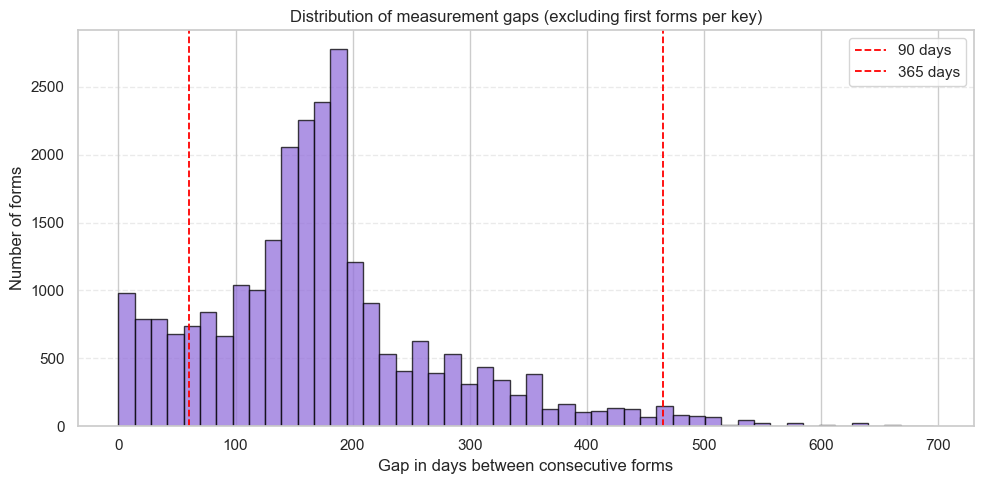

In [42]:
import matplotlib.pyplot as plt

# Use only valid (non-NaN) day gaps
gaps = df_day_primary["days_diff_child"].dropna()

plt.figure(figsize=(10, 5))

plt.hist(
    gaps,
    bins=50,
    color="#9370DB",
    edgecolor="black",
    alpha=0.75
)

# Reference lines for recommended gap range
plt.axvline(60, color="red", linestyle="--", linewidth=1.3, label="90 days")
plt.axvline(465, color="red", linestyle="--", linewidth=1.3, label="365 days")

plt.xlabel("Gap in days between consecutive forms")
plt.ylabel("Number of forms")
plt.title("Distribution of measurement gaps (excluding first forms per key)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [43]:
# =========================================
# Step 3: Select a pair of measurements (2–15 months) per key
# m1 = earliest chronologically; m2 = latest within [60, 465] days after m1
# =========================================
banner("Step 3 • Selecting measurement pairs in the 2–15 month range (60–465 days)")

# 3.1 Identify m1 (the first form per key)
first_idx = df_day_primary.groupby(key_cols)["form_dt"].idxmin()
first_rows = df_day_primary.loc[first_idx].copy()
first_rows["_m1_flag"] = 1

# 3.2 Attach m1 back to check candidates for m2
G = df_day_primary.merge(
    first_rows[key_cols + ["form_dt"]].rename(columns={"form_dt": "m1_date"}),
    on=key_cols,
    how="left"
)

# Candidates for m2: after m1 and within 60–465 days (inclusive)
cand2 = G[
    (G["form_dt"] > G["m1_date"]) &
    ((G["form_dt"] - G["m1_date"]).dt.days.between(60, 465, inclusive="both"))
].copy()

# 3.3 Selection: latest form_dt within the allowed time window
if cand2.empty:
    print("[Warning] No m2 candidates found in the 60–465 day window.")
    second_rows = cand2.copy()
else:
    cand2_idx = cand2.groupby(key_cols)["form_dt"].idxmax()
    second_rows = cand2.loc[cand2_idx].copy()

second_rows["_m2_flag"] = 1
second_rows = second_rows.drop(columns=["m1_date"], errors="ignore")

# 3.4 Pair table (only keys that have both m1 and m2)
m1 = first_rows[key_cols + ["form_dt"]].rename(columns={"form_dt": "m1_date"})
m2 = second_rows[key_cols + ["form_dt"]].rename(columns={"form_dt": "m2_date"})
pairs = m1.merge(m2, on=key_cols, how="inner")

# Short report
n_keys_total = df_day_primary.groupby(key_cols).ngroups
print(f"- Number of keys after daily de-duplication: {n_keys_total:,}")
print(f"- Number of keys with valid (m1 & m2) pair in 60–465 days: {pairs.shape[0]:,} "
      f"({pairs.shape[0] / n_keys_total:.1%})")
print("- Conclusion: only these keys will be used to build the wide table.")



========== Step 3 • Selecting measurement pairs in the 2–15 month range (60–465 days) ==========
- Number of keys after daily de-duplication: 33,799
- Number of keys with valid (m1 & m2) pair in 60–465 days: 21,981 (65.0%)
- Conclusion: only these keys will be used to build the wide table.


In [44]:
# =========================================
# Step 4: Build wide file with two measurements
# (one row per key: child–locality–service_code)
# All columns are kept with suffixes _m1 / _m2 (keys without suffix)
# =========================================

banner("Step 4 • Building wide file with two measurements")

# -------------------------------------------------
# Definitions
# -------------------------------------------------
# The identification key was already defined in key_cols (e.g., ["id_number", "service_code", "yeshuv_code"])
all_columns      = list(df_day_primary.columns)
key_columns      = key_cols
non_key_columns  = [c for c in all_columns if c not in key_columns]

# Option (default False):
# If True – keep original columns (without suffix) in addition to _m1/_m2 (this will significantly increase the number of columns)
keep_original_columns_also = False

# -------------------------------------------------
# Snapshot "before" (for comparison at the end)
# -------------------------------------------------
df_before_compare = df_day_primary.copy()
before_cols_set, before_rows, before_cols_n = snapshot_cols(df_before_compare)
before_shape = df_before_compare.shape

# -------------------------------------------------
# Build m1 table (first measurement) for each key that has a valid pair
# -------------------------------------------------
m1 = first_rows.merge(
    pairs[key_columns + ["m1_date"]],
    left_on=key_columns + ["form_dt"],
    right_on=key_columns + ["m1_date"],
    how="inner"
)

# Map names: keys stay as-is, all others get _m1
map_m1 = {c: (c if c in key_columns else f"{c}_m1") for c in m1.columns}
m1_rows = m1.rename(columns=map_m1)

# Drop helper columns coming from the merge (if any)
m1_rows = m1_rows.drop(columns=[c for c in ["m1_date"] if c in m1_rows.columns])

# -------------------------------------------------
# Build m2 table (second measurement) for each key that has a valid pair
# -------------------------------------------------
m2 = second_rows.merge(
    pairs[key_columns + ["m2_date"]],
    left_on=key_columns + ["form_dt"],
    right_on=key_columns + ["m2_date"],
    how="inner"
)

# Map names: keys stay as-is, all others get _m2
map_m2 = {c: (c if c in key_columns else f"{c}_m2") for c in m2.columns}
m2_rows = m2.rename(columns=map_m2)

# Drop helper columns coming from the merge (if any)
m2_rows = m2_rows.drop(columns=[c for c in ["m2_date"] if c in m2_rows.columns])

# -------------------------------------------------
# Merge m1 and m2 into one row per key
# -------------------------------------------------
wide = m1_rows.merge(m2_rows, on=key_columns, how="inner")

# Optional: also keep original columns (without suffix) in addition to _m1/_m2
if keep_original_columns_also:
    wide = wide.merge(
        df_day_primary[key_columns + non_key_columns],
        on=key_columns,
        how="left",
        suffixes=("", "_src")
    )
    # If you want to preserve original column names exactly (without "_src"),
    # drop the suffix and ensure there are no name collisions.

# Gap in days between measurements (if both dates exist)
if {"form_dt_m1", "form_dt_m2"}.issubset(wide.columns):
    wide["gap_days"] = (
        pd.to_datetime(wide["form_dt_m2"]) - pd.to_datetime(wide["form_dt_m1"])
    ).dt.days

# Basic quality checks
print("Info • Wide file shape:", wide.shape)
dups = wide.duplicated(subset=key_columns).sum()
print("Quality check • Duplicates per key in wide file:", dups)

# Validate gap-days window (60–465)
if "gap_days" in wide.columns:
    outside_range = wide[~wide["gap_days"].between(60, 465, inclusive="both")]
    print("Quality check • Pairs outside 60–465 days:", len(outside_range))

# =========================================
# Step 5: Save wide file
# =========================================
banner("Step 5 • Saving the wide file")

from pathlib import Path
Path("data/processed").mkdir(parents=True, exist_ok=True)
out_path = "data/processed/participants_pairs_wide.csv"
wide.to_csv(out_path, index=False, encoding="utf-8")
print("Saved file:", out_path)

# =========================================
# Step 6: Reports and before–after summary
# =========================================
banner("Step 6 • Reports and before–after summary")

# Schema comparison report
try:
    diff_schema(df_before_compare, wide, title="Schema diff: before vs. after wide transformation")
except Exception as e:
    print("Warning • diff_schema failed:", e)

# Quick report on the wide file
try:
    quick_data_report(wide, title="Quick report: wide file with two measurements")
except Exception as e:
    print("Warning • quick_data_report failed:", e)

# Snapshot "after" and full lists of column name changes
after_cols_set, after_rows, after_cols_n = snapshot_cols(wide)
added_cols   = sorted(list(after_cols_set - before_cols_set))
removed_cols = sorted(list(before_cols_set - after_cols_set))

print("\nStructural changes — columns:")
print(f"Number of columns before: {len(before_cols_set)} | after: {len(after_cols_set)}")
print(f"Added: {len(added_cols)} | Removed: {len(removed_cols)}")
print("List of added columns (full):")
print(added_cols)
print("List of removed columns (full):")
print(removed_cols)
print("\nNote: Columns listed as 'removed' are the original (unsuffixed) names.")
print("The information was not deleted – it now appears under _m1 and _m2 suffixed columns.")

# Log this step into the cumulative change log
report_changes(
    "Build wide file with two measurements",
    before_cols_set,
    after_cols_set,
    before_rows,
    after_rows,
    print_now=True
)

# Table shape summary
after_shape = wide.shape
print("\nBefore–After — table shape")
print(f"Shape before: {before_shape} | Shape after: {after_shape}")

# Description of gap_days (if available)
if "gap_days" in wide.columns:
    print("\nGap in days between first and second measurement — summary")
    print(wide["gap_days"].describe().to_string())
    print("\nDistribution by ranges (days):")
    buckets = pd.cut(
        wide["gap_days"],
        bins=[60, 90, 180, 365, 465],
        right=True,
        include_lowest=True
    )
    print(buckets.value_counts().sort_index())

# Save the cumulative change log to file
save_change_log()



========== Step 4 • Building wide file with two measurements ==========
Info • Wide file shape: (21981, 448)
Quality check • Duplicates per key in wide file: 0
Quality check • Pairs outside 60–465 days: 0

========== Step 5 • Saving the wide file ==========
Saved file: data/processed/participants_pairs_wide.csv

========== Step 6 • Reports and before–after summary ==========
=== Schema diff: before vs. after wide transformation ===
                                              before   after  changed
RS10_suspected_external_physical_abuse        object     NaN     True
RS10_suspected_external_physical_abuse_m1        NaN  object     True
RS10_suspected_external_physical_abuse_m2        NaN  object     True
RS11_external_emotional_or_economic_abuse     object     NaN     True
RS11_external_emotional_or_economic_abuse_m1     NaN  object     True
...                                              ...     ...      ...
welfare_known_family_m1                          NaN  object     True
wel

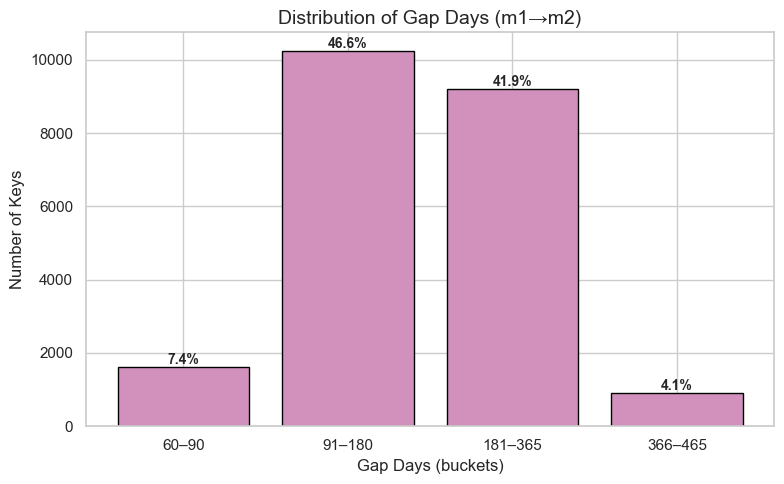

In [40]:
import matplotlib.pyplot as plt

# Define bins and labels
bins = [60, 90, 180, 365, 465]
labels = ["60–90", "91–180", "181–365", "366–465"]

# Cut values into buckets
wide["gap_bucket"] = pd.cut(
    wide["gap_days"], bins=bins, labels=labels, right=True, include_lowest=True
)

# Counts and percentages
counts = wide["gap_bucket"].value_counts().sort_index()
percents = (counts / counts.sum() * 100).round(1)

# Plot histogram
plt.figure(figsize=(8,5))
bars = plt.bar(counts.index.astype(str), counts.values, 
               color="#d291bc", edgecolor="black")

# Add percentage labels above bars
for bar, pct in zip(bars, percents):
    plt.text(
        bar.get_x() + bar.get_width()/2,   # Center of bar
        bar.get_height(),                 # Height of bar
        f"{pct}%",                        # Percent text
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.title("Distribution of Gap Days (m1→m2)", fontsize=14)
plt.xlabel("Gap Days (buckets)", fontsize=12)
plt.ylabel("Number of Keys", fontsize=12)
plt.tight_layout()
plt.show()


In [45]:
# =========================================
# Step 5: Save the wide file
# =========================================
banner("Step 5 • Saving the wide file")

from pathlib import Path

# Ensure processed directory exists
Path("data/processed").mkdir(parents=True, exist_ok=True)

out_path = Path("data/processed/participants_pairs_wide.csv")

# Save CSV + PKL
wide.to_csv(out_path, index=False, encoding="utf-8")
wide.to_pickle(out_path.with_suffix(".pkl"))

print("Two files saved:")
print(f"- CSV: {out_path}")
print(f"- PKL: {out_path.with_suffix('.pkl')}")



========== Step 5 • Saving the wide file ==========
Two files saved:
- CSV: data\processed\participants_pairs_wide.csv
- PKL: data\processed\participants_pairs_wide.pkl


### Convert an object into viable data

In [46]:
# =========================================
# Backup saving and creation of a new working file for column handling
# =========================================
import pandas as pd, shutil
from pathlib import Path

# Source file
backup = Path("data/processed/participants_pairs_wide.pkl")

# New working file
at_work = Path("data/interim/participants_columns_handling.pkl")
at_work.parent.mkdir(parents=True, exist_ok=True)

# Create a backup copy
shutil.copy2(backup, at_work)

# Load into workspace
df = pd.read_pickle(at_work)

print("✅ Working file loaded successfully:")
print(f"{at_work.resolve()} | shape: {df.shape}")
print(df.dtypes.head())


✅ Working file loaded successfully:
C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling.pkl | shape: (21981, 448)
ref_id_360_m1           int64
form_type_m1           object
form_version_m1        object
form_date_m1           object
form_filler_role_m1    object
dtype: object


In [47]:
# Print number of columns and last column names
print("Shape:", df.shape)
print("Last 10 columns:", df.columns[-10:].tolist())


Shape: (21981, 448)
Last 10 columns: ['is_duplicate_m2', '_risk_complete_m2', '_day_m2', '_row_order_m2', '_rank_in_day_m2', 'is_primary_same_day_m2', 'days_diff_child_m2', '_m2_flag_m2', 'm2_date_m2', 'gap_days']


In [48]:
# Snapshot of column dtypes before variable processing
before_schema = df.dtypes.copy()

print("Schema snapshot taken | number of columns:", len(before_schema))
print(before_schema.head(10))  # Display first 10 entries


Schema snapshot taken | number of columns: 448
ref_id_360_m1            int64
form_type_m1            object
form_version_m1         object
form_date_m1            object
form_filler_role_m1     object
yeshuv_code              int64
yeshuv_name_m1          object
machoz_m1               object
institution_type_m1     object
institution_code_m1    float64
dtype: object


In [49]:
# Number of columns with dtype 'object'
num_object_cols = df.select_dtypes(include="object").shape[1]
print("Number of object columns:", num_object_cols)

# Out of all columns
total_cols = df.shape[1]
print(f"{num_object_cols} out of {total_cols} columns are of type 'object'")


Number of object columns: 372
372 out of 448 columns are of type 'object'


In [50]:
# Display object-type columns with number of unique values (sorted descending)
df.select_dtypes(include="object").nunique().sort_values(ascending=False)


id_number                      21783
form_date_m1                   21224
form_date_m2                   20570
strength_domain_m1              3158
strength_domain_m2              2733
                               ...  
institution_type_m2                1
single_parent_m2                   1
single_parent_m1                   1
institution_type_m1                1
receives_service_parents_m2        0
Length: 372, dtype: int64

In [51]:
# Function to display all object-type columns and their unique values
def show_object_summary(df):
    object_cols = df.select_dtypes(include="object").columns
    print(f"Found {len(object_cols)} object columns\n")
    
    for col in object_cols:
        print("=" * 50)
        print(f"Column: {col}")
        print(f"Unique values: {df[col].nunique()}")
        print(df[col].value_counts(dropna=False).head(10))  # Show top 10 most frequent values
        print("\n")

show_object_summary(df)


Found 372 object columns

Column: form_type_m1
Unique values: 2
form_type_m1
מעקב אחר ילדים המשתתפים בתוכניות לילדים ונוער בסיכון                                   21980
איתור ילדים בסיכון במסגרת מיפוי במערכות אוניברסליות (טיפות חלב, גני ילדים, בתי ספר)        1
Name: count, dtype: int64


Column: form_version_m1
Unique values: 6
form_version_m1
גיל הרך                     8510
ילדים ובני נוער             7888
ילדים ובני נוער חרדי        2211
גיל הרך (בערבית)            1191
גיל הרך חרדי                1114
ילדים ובני נוער (בערבית)    1067
Name: count, dtype: int64


Column: form_date_m1
Unique values: 21224
form_date_m1
12/07/2023 11:51    7
12/12/2023 09:24    6
12/07/2023 11:05    5
12/07/2023 10:42    5
12/07/2023 10:33    5
12/12/2023 09:16    5
12/11/2023 11:30    4
01/03/2024 15:29    4
12/12/2023 11:39    4
12/07/2023 10:54    4
Name: count, dtype: int64


Column: form_filler_role_m1
Unique values: 19
form_filler_role_m1
מדריך               5640
מורה/מחנך           2834
פארה רפ

In [54]:
print(df["form_type_m1"].value_counts())

form_type_m1
מעקב אחר ילדים המשתתפים בתוכניות לילדים ונוער בסיכון                                   21980
איתור ילדים בסיכון במסגרת מיפוי במערכות אוניברסליות (טיפות חלב, גני ילדים, בתי ספר)        1
Name: count, dtype: int64


This variable contains a single constant value, which does not contribute any variance or informational value.  
It will be removed later together with all other constant features as part of the consolidated cleanup step.


In [56]:
print(df["form_type_m2"].value_counts())

form_type_m2
מעקב אחר ילדים המשתתפים בתוכניות לילדים ונוער בסיכון                                   21980
איתור ילדים בסיכון במסגרת מיפוי במערכות אוניברסליות (טיפות חלב, גני ילדים, בתי ספר)        1
Name: count, dtype: int64


In [57]:
# Convert object column to string dtype
df["id_number"] = df["id_number"].astype("string")
df["id_number"].dtype


string[python]

In [58]:
print(df["form_version_m1"].value_counts())

form_version_m1
גיל הרך                     8510
ילדים ובני נוער             7888
ילדים ובני נוער חרדי        2211
גיל הרך (בערבית)            1191
גיל הרך חרדי                1114
ילדים ובני נוער (בערבית)    1067
Name: count, dtype: int64


In [59]:
print(df["form_version_m2"].value_counts())

form_version_m2
גיל הרך                     8528
ילדים ובני נוער             7986
ילדים ובני נוער חרדי        2148
גיל הרך (בערבית)            1185
גיל הרך חרדי                1104
ילדים ובני נוער (בערבית)    1030
Name: count, dtype: int64


In [60]:
# Create flags based on raw text in each measurement
for c in ["form_version_m1", "form_version_m2"]:
    if c in df.columns:
        df[f"is_haredi_form_{c[-2:]}"] = df[c].str.contains("חרדי", na=False).astype(int)
        df[f"is_arabic_form_{c[-2:]}"] = df[c].str.contains("ערבית", na=False).astype(int)


In [61]:
df[["form_version_m1", "form_version_m2"]] = (
    df[["form_version_m1", "form_version_m2"]]
    .replace({
        "גיל הרך": "גיל הרך",
        "גיל הרך חרדי": "גיל הרך",
        "גיל הרך (בערבית)": "גיל הרך",
        "ילדים ובני נוער": "ילדים ונוער",
        "ילדים ובני נוער חרדי": "ילדים ונוער",
        "ילדים ובני נוער (בערבית)": "ילדים ונוער"
    })
)

In [62]:
# Convert object columns to categorical dtype
df["form_version_m1"] = df["form_version_m1"].astype("category")
df["form_version_m2"] = df["form_version_m2"].astype("category")

print(df["form_version_m1"].value_counts())
print(df["form_version_m1"].dtype)

print(df["form_version_m2"].value_counts())
print(df["form_version_m2"].dtype)


form_version_m1
ילדים ונוער    11166
גיל הרך        10815
Name: count, dtype: int64
category
form_version_m2
ילדים ונוער    11164
גיל הרך        10817
Name: count, dtype: int64
category


In [63]:
# Print number of columns and the last 10 column names
print("Shape:", df.shape)
print("Last 10 columns:", df.columns[-10:].tolist())


Shape: (21981, 452)
Last 10 columns: ['_rank_in_day_m2', 'is_primary_same_day_m2', 'days_diff_child_m2', '_m2_flag_m2', 'm2_date_m2', 'gap_days', 'is_haredi_form_m1', 'is_arabic_form_m1', 'is_haredi_form_m2', 'is_arabic_form_m2']


In [64]:
df["form_filler_role_m1"].value_counts()


form_filler_role_m1
מדריך                      5640
מורה/מחנך                  2834
פארה רפואי                 2529
גננת                       1899
עו"ס                       1441
אחר                        1398
פסיכולוג                   1339
נאמן פותחים עתיד           1154
מטפלת                      1087
יועצת חינוכית               951
מנהלת מעון                  539
חונך                        438
אחות                        239
מנהלת מועדונית/בני נוער     205
קידום נוער                  131
מורה-חיילת                   52
מתנדב (שירות לאומי, שש)      51
קב"ס                         43
סומך                         11
Name: count, dtype: int64

In [65]:
# Convert object columns to categorical dtype for both measurements
df["form_filler_role_m1"] = df["form_filler_role_m1"].astype("category")
df["form_filler_role_m2"] = df["form_filler_role_m2"].astype("category")

# Print dtypes after conversion
print("form_filler_role_m1:", df["form_filler_role_m1"].dtype)
print("form_filler_role_m2:", df["form_filler_role_m2"].dtype)


form_filler_role_m1: category
form_filler_role_m2: category


## Datetime Conversion Formats

In [66]:
df["form_date_m1"].value_counts()

form_date_m1
12/07/2023 11:51       7
12/12/2023 09:24       6
12/07/2023 11:05       5
12/07/2023 10:42       5
12/07/2023 10:33       5
                      ..
01/28/2024 14:01:00    1
12/30/2023 23:33:14    1
01/15/2024 21:54:15    1
01/07/2024 12:13       1
12/24/2023 11:22:50    1
Name: count, Length: 21224, dtype: int64

In [67]:
print(df["form_date_m1"].dtype)

object


In [68]:
df["form_date_m2"].value_counts()

form_date_m2
06/03/2024 10:44       5
06/04/2024 10:47       5
06/06/2024 12:18       5
06/04/2024 11:05       5
06/06/2024 11:29       5
                      ..
06/23/2024 00:27:40    1
05/22/2024 21:08:38    1
06/23/2024 02:43:20    1
08/27/2024 13:20:35    1
05/22/2024 12:41:40    1
Name: count, Length: 20570, dtype: int64

In [69]:
print(df["form_date_m2"].dtype)

object


In [70]:
# Convert date columns to datetime dtype for both measurements
df["form_date_m1"] = pd.to_datetime(df["form_date_m1"], errors="coerce", dayfirst=True)
df["form_date_m2"] = pd.to_datetime(df["form_date_m2"], errors="coerce", dayfirst=True)

print(df["form_date_m1"].dtype)
print(df["form_date_m2"].dtype)


datetime64[ns]
datetime64[ns]


## Cleaning and Standardizing Locality Names

In [71]:
df["yeshuv_name_m1"].value_counts()

yeshuv_name_m1
בני ברק                               1174
אשדוד                                  889
בית שמש                                854
אום אל פאחם                            488
יבנה                                   468
                                      ... 
תל אביב יפו נווה שאנן-שכונת התקווה       4
ינוח גת                                  3
חבל אילות                                1
שדרות                                    1
מטה                                      1
Name: count, Length: 183, dtype: int64

In [72]:
print(df["yeshuv_name_m1"].dtype)

object


In [73]:
print(df["yeshuv_name_m2"].value_counts())

yeshuv_name_m2
בני ברק                               1174
אשדוד                                  889
בית שמש                                854
אום אל פאחם                            488
יבנה                                   468
                                      ... 
תל אביב יפו נווה שאנן-שכונת התקווה       4
ינוח גת                                  3
חבל אילות                                1
שדרות                                    1
מטה                                      1
Name: count, Length: 183, dtype: int64


In [74]:
# Convert locality name columns to categorical dtype
df["yeshuv_name_m1"] = df["yeshuv_name_m1"].astype("category")
df["yeshuv_name_m2"] = df["yeshuv_name_m2"].astype("category")

print(df["yeshuv_name_m1"].dtype)
print(df["yeshuv_name_m2"].dtype)


category
category


In [75]:
# Identify localities with frequency below 1% to consider grouping them under 'Other'

total = len(df)
threshold = total * 0.01

# Count occurrences of each locality
counts = df["yeshuv_name_m1"].value_counts()

# Localities below the 1% threshold
rare_yeshuvim = counts[counts < threshold]

print(f"Total localities with less than 1% of rows: {len(rare_yeshuvim)}")
print("Sample list:")
print(rare_yeshuvim.head(20))


Total localities with less than 1% of rows: 158
Sample list:
yeshuv_name_m1
רהט                       206
דימונה                    200
מעלות תרשיחא              191
מראר                      187
בת ים                     186
קרית מלאכי                185
נהריה                     183
עראבה                     183
כפר כנא                   178
טמרה                      172
חולון                     170
לוד                       168
אילת                      165
מעלה אדומים               160
הגלבוע                    160
דלית אל כרמל              157
כסיפה                     154
כפר מנדא                  154
עספיא                     153
נוף הגליל - נצרת עילית    149
Name: count, dtype: int64


In [76]:
# Localities above the 1% frequency threshold
common_yeshuvim = counts[counts > threshold]

print(f"Total localities with more than 1% of rows: {len(common_yeshuvim)}")
print("Sample list:")
print(common_yeshuvim.head(20))


Total localities with more than 1% of rows: 25
Sample list:
yeshuv_name_m1
בני ברק        1174
אשדוד           889
בית שמש         854
אום אל פאחם     488
יבנה            468
סכנין           458
טירת הכרמל      450
חדרה            439
אלעד            353
ראשון לציון     314
גסר אל זרקא     305
ביתר עילית      304
נתניה           303
פתח תקווה       296
קרית גת         295
צפת             294
אשקלון          286
כפר קאסם        268
מכר גדידה       261
שפרעם           251
Name: count, dtype: int64


Because the number of low-frequency localities is very large (158 localities below the 1% threshold), I decided **not** to collapse them into an “Other” category at this stage.  
Instead, locality grouping or dimensionality reduction will be performed later during the feature engineering phase.


In [77]:
# Convert district columns to categorical dtype
df["machoz_m1"] = df["machoz_m1"].astype("category")
df["machoz_m2"] = df["machoz_m2"].astype("category")

print(df["machoz_m1"].dtype)
print(df["machoz_m2"].dtype)


category
category


In [78]:
print(df["machoz_m1"].value_counts())

machoz_m1
ת"א והמרכז    5077
דרום          3898
צפון ב        3528
חיפה          3504
צפון א        3374
ירושלים       2600
Name: count, dtype: int64


In [79]:
print(df["machoz_m2"].value_counts())

machoz_m2
ת"א והמרכז    5077
דרום          3898
צפון ב        3528
חיפה          3504
צפון א        3374
ירושלים       2600
Name: count, dtype: int64


In [80]:
# Merge 'North A' and 'North B' into 'North' — separately for both measurements
for c in ["machoz_m1", "machoz_m2"]:
    if c in df.columns:
        df[c] = df[c].replace({"צפון א": "צפון", "צפון ב": "צפון"})
        print(f"\n{c}:\n", df[c].value_counts())

# Final check
print(df["machoz_m1"].value_counts())
print(df["machoz_m2"].value_counts())



machoz_m1:
 machoz_m1
צפון          6902
ת"א והמרכז    5077
דרום          3898
חיפה          3504
ירושלים       2600
Name: count, dtype: int64

machoz_m2:
 machoz_m2
צפון          6902
ת"א והמרכז    5077
דרום          3898
חיפה          3504
ירושלים       2600
Name: count, dtype: int64
machoz_m1
צפון          6902
ת"א והמרכז    5077
דרום          3898
חיפה          3504
ירושלים       2600
Name: count, dtype: int64
machoz_m2
צפון          6902
ת"א והמרכז    5077
דרום          3898
חיפה          3504
ירושלים       2600
Name: count, dtype: int64


### Checking Variable Equivalence Across Measurement Waves to Decide on Retention or Removal

In [81]:
# --- Verifying Identical Variables Across Measurement Waves  ---

import pandas as pd

pairs = [
    ("form_version_m1", "form_version_m2"),
    ("yeshuv_name_m1", "yeshuv_name_m2"),
    ("machoz_m1", "machoz_m2"),
    ("population_group_m1", "population_group_m2"),
    ("service_name_m1", "service_name_m2"),
    ("program_name_m1", "program_name_m1"),
    ("form_type_m1", "form_type_m2"),
    ("institution_type_m1", "institution_type_m2"),
    ("residence_locality_m1", "residence_locality_m2"),
    ("service_location_m1", "service_location_m2"),
    ("age_group_m1", "age_group_m2"),
    ("school_level_m1", "school_level_m2"),
    ("service_status_m1", "service_status_m1"),
]

for c1, c2 in pairs:
    if c1 in df.columns and c2 in df.columns:
        mask = df[c1].astype("string") == df[c2].astype("string")
        same = mask.mean()
        diff = (~mask).sum()
        print(f"\nבדיקה: {c1} מול {c2}")
        print(f"אחוז שורות זהות: {same:.2%}")
        print(f"מספר שורות שונות: {diff}")
        if diff > 0:
            examples = (df.loc[~mask, [c1, c2]]
                          .drop_duplicates()
                          .head(10))
            print("דוגמאות אי-התאמה (עד 10):")
            print(examples.to_string(index=False))
    else:
        print(f"\nדילוג: חסרה אחת העמודות ({c1} / {c2})")



בדיקה: form_version_m1 מול form_version_m2
אחוז שורות זהות: 99.98%
מספר שורות שונות: 4
דוגמאות אי-התאמה (עד 10):
form_version_m1 form_version_m2
    ילדים ונוער         גיל הרך
        גיל הרך     ילדים ונוער

בדיקה: yeshuv_name_m1 מול yeshuv_name_m2
אחוז שורות זהות: 100.00%
מספר שורות שונות: 0

בדיקה: machoz_m1 מול machoz_m2
אחוז שורות זהות: 100.00%
מספר שורות שונות: 0

בדיקה: population_group_m1 מול population_group_m2
אחוז שורות זהות: 97.37%
מספר שורות שונות: 579
דוגמאות אי-התאמה (עד 10):
population_group_m1 population_group_m2
               כולם        יהודי-חילוני
          יהודי-דתי        יהודי-חילוני
יהודי מסורתי/חילוני           יהודי-דתי
         יהודי-חרדי         ערבי-מוסלמי
        ערבי-מוסלמי               בדואי
               ערבי         ערבי-מוסלמי
               ערבי          ערבי-נוצרי
        ערבי-מוסלמי                ערבי
                אחר        יהודי-חילוני
       יהודי-חילוני           יהודי-דתי

בדיקה: service_name_m1 מול service_name_m2
אחוז שורות זהות: 1

All of the variables listed above exhibit either complete or near-complete identity across the two measurement waves.
In the next step, I will remove these variables from the second measurement and retain only their first-wave versions.
I will now examine the similarity of all variables representing program or service names.

## Handle Overlapping Variables (Service & Program Names)

In [75]:
# Checking identity between program/service name variables

mismatch = df[df["service_name_m1"] != df["program_name_m1"]]
print("Number of mismatches:", len(mismatch))

# Percentage of identical rowsת
same_ratio = (df["service_name_m1"] == df["program_name_m1"]).mean()
print(f"Percent identical rows: {same_ratio:.2%}")

Number of mismatches: 10664
Percent identical rows: 51.49%


The variables service_name and program_name are not identical. The next step is to clean and standardize both variables and then re-evaluate their similarity to determine whether one of them can be removed.

In [76]:
print(sorted(df["service_name_m1"].dropna().unique().tolist()))
print(sorted(df["program_name_m1"].dropna().unique().tolist()))


[' מרכז טיפולי לנערים בסיכון ובמצוקה קשה (בית חם)', ' מרכז מידע וייעוץ לבני נוער', ' נתיבים להורות - מודל טיפולי לילדים והורים 100 נפשות ', ' נתיבים להורות - מודל טיפולי לילדים והורים 20 נפשות ', ' נתיבים להורות - מודל טיפולי לילדים והורים 20 נפשות - אילנית ביטון', ' נתיבים להורות - מודל טיפולי לילדים והורים 40 נפשות ', ' נתיבים להורות - מודל טיפולי לילדים והורים 40 נפשות משותף ב 20 נפשות', ' נתיבים להורות - מודל טיפולי לילדים והורים20 נפשות ', ' נתיבים להורות - תקוע ', ' נתיבים לנוער - מרכז', 'אבחון וטיפול בקשיים התפתחותיים ורגשיים של ילדים מאותרים בגיל הרך (תוכנית 10%)', 'אור בת ים', 'אור רב תחומי', 'אחרי הצלצול - תכנית מעברים – 15 משפחות ', 'איתור ילדים עם הפרעות התפתחותיות במעונות היום ובגני הילדים', 'אם לאם : פרויקט ביקורי בית לאמהות ותינוקות', 'בית חם ויוצר לנערות', 'בית חם ויוצר לנערות (במימון אחר)', 'בית חם ויוצר לנערות (במימון אחר) - חצור ', 'בית חם ויוצר לנערות - 2554 - 5 ימים בשבוע', 'בית חם ויוצר לנערות -בית הדר  2553 - 3 ימים בשבוע', 'בית חם ויוצר לנערות- נווה זאב ', 'בית 

In [82]:
# --- Comparing value sets ---
service_uniques = set(df["service_name_m1"].dropna().unique())
program_uniques = set(df["program_name_m1"].dropna().unique())

only_in_service = service_uniques - program_uniques
only_in_program = program_uniques - service_uniques

print(f"\n✅ Identical values across fields: {len(service_uniques & program_uniques):,}")
print(f"⚠️ Unique to service_name_m1: {len(only_in_service):,}")
print(f"⚠️ Unique to program_name_m1: {len(only_in_program):,}")



✅ Identical values across fields: 167
⚠️ Unique to service_name_m1: 168
⚠️ Unique to program_name_m1: 36


I copied all the unique values from both variables into an AI assistant, and it generated the appropriate patterns for the cleaning code.

In [83]:
# ============================================================
# Cleaning and harmonizing labels: "service name" and "program name" (m1 only)
# ============================================================
# What does this code do?
# 1) Defines normalization functions (spaces/hyphens/quotes/characters) and removes "noise" 
#    such as codes, number of families/days/participants, and local suffixes.
# 2) Applies a canonical mapping (BASE_PATTERNS) – the same patterns are used for both variables.
# 3) Creates new columns: service_name_m1_clean, program_name_m1_clean (categorical).
# 4) Prints a before–after report: number of unique values, non-missing values, how many labels
#    were unified, and how many raw values actually changed.
# 5) Optionally: keeps intermediate columns for inspection and/or drops them at the end.
# 6) Saves the data to a Pickle file (to preserve dtypes) and to a separate flat CSV snapshot.
# Note: The original columns are not dropped or overwritten, and no rows are removed.

import re
import pandas as pd
from pathlib import Path

# ==== General settings ====
HEB_RANGE = r'\u0590-\u05FF'
COLUMNS_TO_CLEAN = [
    ("service_name_m1",  "service_name_m1_clean"),
    ("program_name_m1",  "program_name_m1_clean"),
]
SAVE_INTERMEDIATE_COLS = False   # If True, keep intermediate columns for inspection
DROP_INTERMEDIATE_AT_END = True  # If True, drop intermediate columns created by this code
INTERIM_DIR = Path("data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)
OUT_PKL  = INTERIM_DIR / "participants_columns_handling.pkl"
OUT_CSV  = INTERIM_DIR / "participants_columns_handling_cleaned.csv"

# ==== Cleaning functions ====

# (A) Basic normalization: lowercase, hyphens→space, compress spaces, keep Hebrew/Latin/digits/()/" and space, unify quotes, unify spelling
def normalize_txt(s):
    if pd.isna(s):
        return s
    s = str(s).strip().lower()
    s = re.sub(r'[‐\-–—_]+', ' ', s)                 # hyphens → space
    s = re.sub(r'\s+', ' ', s)                       # compress spaces
    s = re.sub(fr'[^{HEB_RANGE}a-z0-9 ()/"]', '', s) # keep allowed characters
    s = s.replace('״','"').replace('”','"').replace('“','"')  # unify quotes
    s = re.sub(r'תוכנ(י|י)ת', 'תוכנית', s)          # unify spelling
    return s

# (B) Remove "noise": HTML artifacts, codes, numbers of families/days/participants, and local suffixes
def strip_noise(name):
    if pd.isna(name):
        return name
    s = str(name)

    # Decode common HTML entities
    s = s.replace("&amp;quot;", '"').replace("&quot;", '"').replace("&amp;amp;", "&")

    # Remove program/budget codes
    s = re.sub(r'\b(1279|1416|2553|2554|549|6308|9101|9104)\b', '', s)

    # Remove quantities/days/participants/households
    s = re.sub(r'\b\d+\s*משפחות\b', '', s)
    s = re.sub(r'\(\s*\d+\s*ימים\s*\)', '', s)
    s = re.sub(r'\b\d+\s*ימים\b', '', s)
    s = re.sub(r'\b\d+\s*משתתפים\b', '', s)
    s = re.sub(r'מודל\s*\d+\s*נפשות', '', s)
    s = re.sub(r'\b\d+\s*-\s*\d+\s*נפשות\b', '', s)

    # Collapse recurring local suffixes
    s = re.sub(r'^(מעגן)\b.*', r'\1', s)
    s = re.sub(r'^(מרכז נוער)(?: ישובי| שכונתי| ישובי / שכונתי)?(?: .*)?$', r'\1', s)
    s = re.sub(r'^(מרכזי? למידה שכונתיים)\b.*', r'\1', s)
    s = re.sub(r'^(מועדונית טיפולית)\b.*', r'\1', s)
    s = re.sub(r'^(יש מצב)\b.*', r'\1', s)
    s = re.sub(r'^(נתיבים להורות)\b.*', r'\1', s)

    # Final clean-up
    s = re.sub(r'\s+', ' ', s).strip(' -–—').strip()
    return s

# (C) Canonical patterns — same patterns for both variables
BASE_PATTERNS = [
    (r'^חדר(י)? שלווה', 'חדרי שלווה (חם)'),
    (r'^אבחון וטיפול בקשיים התפתחותיים ורגשיים של ילדים מאותרים בגיל הרך',
     'אבחון וטיפול בקשיים התפתחותיים ורגשיים של ילדים מאותרים בגיל הרך'),
    (r'^ת[וֹ]כנית? אור|^אור רב תחומי|^ת(וֹ|ו)?כנית? אור|^תוכנית אור', 'תוכנית אור'),
    (r'^איתור והתערבות בגני טרום חובה', 'איתור והתערבות בגני טרום חובה'),
    (r'^איתור ילדים עם הפרעות התפתחותיות במעונות היום ובגני הילדים',
     'איתור ילדים עם הפרעות התפתחותיות במעונות היום ובגני הילדים'),
    (r'^בית חם ויוצר לנערות', 'בית חם ויוצר לנערות'),
    (r'^גשרים( |-)|^גשרים ', 'גשרים'),
    (r'^דגם בין משרדי למרכז גיל רך ישובי', 'דגם בין משרדי למרכז גיל רך ישובי'),
    (r'^האתג"ר', 'האתג"ר'),
    (r'^הט"ף', 'הט"ף (הדרכה בטיפוח פעוטות)'),
    (r'^היחידה להתפתחות הילד גיל הרך', 'היחידה להתפתחות הילד גיל הרך'),
    (r'^היחידה לקידום נוער', 'היחידה לקידום נוער (במימון אחר)'),
    (r'^חיזוק משאבי התמודדות באמצעות טיפול באומנויות', 'חיזוק משאבי התמודדות באמצעות טיפול באומנויות'),
    (r'^טיפולים קבוצתיים לילדים ו/?או הורים|^טיפולים קבוצתיים', 'טיפולים קבוצתיים'),
    (r'^יש מצב', 'יש מצב'),
    (r'^להב"ה', 'להב"ה'),
    (r'^מועדוניות מתבגרים', 'מועדוניות מתבגרים'),
    (r'^מועדונית טיפולית', 'מועדונית טיפולית'),
    (r'^מיפוי בגני ילדים', 'מיפוי בגני ילדים'),
    (r'^מיפוי כיתות', 'מיפוי כיתות'),
    (r'^מל[א"]?$', 'מל"א'),
    (r'^מעגן.*', 'מעגן'),
    (r'^מרכז ילדים הורים', 'מרכז ילדים הורים'),
    (r'^מרכז(י)? למידה שכונתיים', 'מרכזי למידה שכונתיים'),
    (r'^נתיבים להורות', 'נתיבים להורות'),
    (r'^תכנית משפחות להורים וילדים בגיל הרך', 'תכנית משפחות להורים וילדים בגיל הרך'),
    (r'^תמיכה ביתית בילד ?\(?אומנה יומית\)?', 'תמיכה ביתית בילד (אומנה יומית)'),
    (r'^מרכז נוער (ישובי|שכונתי|עירוני)?', 'מרכז נוער'),
    (r'^פותחים עתיד', 'פותחים עתיד'),
    (r'^מעון יום רב תכליתי', 'מעון יום רב תכליתי'),
]

def choose_base(name_norm: str):
    if not isinstance(name_norm, str):
        return None
    for pat, canon in BASE_PATTERNS:
        if re.search(pat, name_norm):
            return canon
    return None

# ==== Run over columns (m1 only), create _clean, and print summary ====
stats = []

for SRC, DST in COLUMNS_TO_CLEAN:
    if SRC not in df.columns:
        print(f"⚠️ Column {SRC} does not exist — skipping.")
        continue

    # --- Before snapshot ---
    before = df[SRC].astype('string')
    before_nunique = before.nunique(dropna=False)
    before_nonnull = before.notna().sum()

    # --- Normalization and noise removal ---
    norm_series = before.apply(normalize_txt).apply(strip_noise)
    canon_series = norm_series.apply(choose_base)
    final_series = canon_series.fillna(norm_series)

    # Preserve the value "other" if it existed
    final_series = final_series.where(norm_series != "אחר", "אחר")

    # --- Save intermediate columns (optional) ---
    if SAVE_INTERMEDIATE_COLS:
        df[f"__tmp_{SRC}_norm"]  = norm_series.astype('string')
        df[f"__tmp_{SRC}_canon"] = canon_series.astype('string')

    # --- Create cleaned categorical column ---
    df[DST] = final_series.astype('category')

    # --- After snapshot ---
    after_nunique = df[DST].nunique(dropna=False)
    after_nonnull = df[DST].notna().sum()

    # --- Count changed values ---
    changed_pairs = (
        pd.DataFrame({'before': before, 'after': final_series})
        .drop_duplicates()
        .astype({'before': 'string', 'after': 'string'})
    )
    changed_count = int((changed_pairs['before'] != changed_pairs['after']).sum())

    # --- Unified labels ---
    unified_labels = int(max(0, before_nunique - after_nunique))

    print(f"\n🧽 Cleaning: {SRC} → {DST}")
    print(f"Unique values: before {before_nunique:,} | after {after_nunique:,} | unified {unified_labels:,}")
    print(f"Non-missing: before {before_nonnull:,} | after {after_nonnull:,}")
    print(f"Changed at least once: {changed_count:,}")

    stats.append({
        "src": SRC, "dst": DST,
        "before_nunique": int(before_nunique),
        "after_nunique": int(after_nunique),
        "unified_labels": unified_labels,
        "before_nonnull": int(before_nonnull),
        "after_nonnull": int(after_nonnull),
        "changed_values": changed_count
    })

# --- Drop intermediate columns if needed ---
if DROP_INTERMEDIATE_AT_END:
    to_drop = [c for c in df.columns if c.startswith("__tmp_")]
    if to_drop:
        df.drop(columns=to_drop, inplace=True, errors="ignore")
        print(f"\n🧹 Dropped intermediate columns: {len(to_drop)}")

# --- Save final outputs ---
df.to_pickle(OUT_PKL)
df.to_csv(OUT_CSV, index=False)
print(f"\n💾 Saved Pickle with dtypes: {OUT_PKL.resolve()}")
print(f"💾 Saved flat CSV snapshot: {OUT_CSV.resolve()}")

# --- Summary table ---
summary = pd.DataFrame(stats)[[
    "src","dst","before_nunique","after_nunique",
    "unified_labels","changed_values","before_nonnull","after_nonnull"
]]
print("\n=== Cleaning summary by column ===")
print(summary)



🧽 Cleaning: service_name_m1 → service_name_m1_clean
Unique values: before 335 | after 185 | unified 150
Non-missing: before 21,981 | after 21,981
Changed at least once: 246

🧽 Cleaning: program_name_m1 → program_name_m1_clean
Unique values: before 203 | after 154 | unified 49
Non-missing: before 21,981 | after 21,981
Changed at least once: 132

💾 Saved Pickle with dtypes: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling.pkl
💾 Saved flat CSV snapshot: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling_cleaned.csv

=== Cleaning summary by column ===
               src                    dst  before_nunique  after_nunique  \
0  service_name_m1  service_name_m1_clean             335            185   
1  program_name_m1  program_name_m1_clean             203            154   

   unified_labels  changed_values  before_nonnull 

In [84]:
# ===== Comparison between the two newly cleaned columns =====
if {"service_name_m1_clean","program_name_m1_clean"}.issubset(df.columns):
    same_ratio = (df["service_name_m1_clean"].astype("string") == 
                  df["program_name_m1_clean"].astype("string")).mean()
    mismatches = (df["service_name_m1_clean"].astype("string") != 
                  df["program_name_m1_clean"].astype("string")).sum()
    print(f"Percent identical (clean vs clean): {same_ratio:.2%}")
    print(f"Number of mismatches (clean vs clean): {mismatches:,}")
else:
    print("⚠️ חסרות עמודות להשוואה: service_name_m1_clean / program_name_m1_clean")


Percent identical (clean vs clean): 92.89%
Number of mismatches (clean vs clean): 1,563


In [85]:
# Comparison as strings + handling NaN (treat NaN == NaN as equal)
a = df["service_name_m1_clean"].astype("string").fillna("__NA__")
b = df["program_name_m1_clean"].astype("string").fillna("__NA__")

mism = df[a != b][["service_name_m1_clean", "program_name_m1_clean"]].drop_duplicates()
print(f"Found {len(mism)} unique mismatching pairs")
mism.head(30)


Found 53 unique mismatching pairs


,service_name_m1_clean,program_name_m1_clean
9,סיוע טיפולי טיפוחי לנוער,סיוע טיפולי טיפוחי וחמרי לילדים ולנוער הוראה 8...
28,מענה רגשי בגנים,טיפולים קבוצתיים
39,חצר פעילה,חצר פעילה 20 גנים
61,מרכז נוער,מרכזי למידה שכונתיים
81,מעלות שלהבת,שלהבת
82,מנחה הורים בית ספרי (תוכנית 10),מנחה הורים בית ספרי(תוכנית 10)
83,מניפה מנוף לחיים באמצעות פרחי הוראה,"מניפ""ה מנוף לחיים באמצעות פרחי הוראה"
90,"מל""א","מל""א מרחב למידה אחר"
164,פרויקט החונכים,פרויקט החונכים חיח
166,מלא מרחב למידה אחר,"מל""א מרחב למידה אחר"


The label-cleaning process was successful. A substantial number of values were unified, and the similarity between service_name and program_name increased from about 50% to roughly 90%. The remaining mismatched pairs are mostly very similar and align with the canonical structure we created. A final decision on whether to keep both variables or retain only one will be made later, depending on analytical needs.

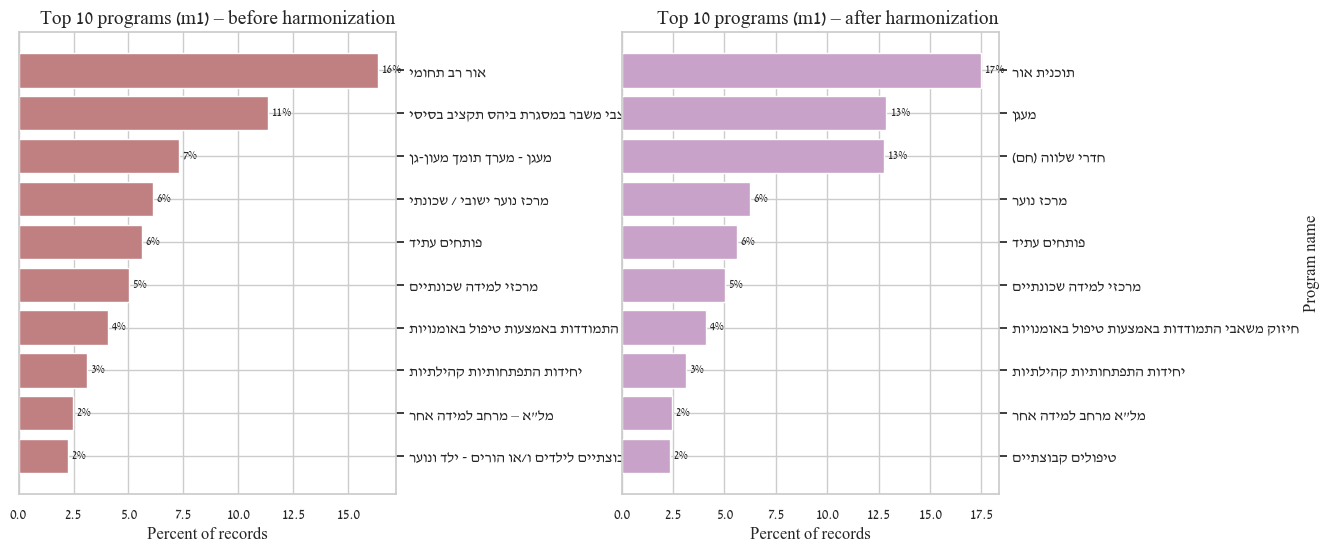

In [88]:
# --- Before and after harmonizing program names: visual comparison of frequency distribution ---

import matplotlib.pyplot as plt
import matplotlib as mpl
from bidi.algorithm import get_display
import arabic_reshaper

# Hebrew-compatible font (kept as is)
mpl.rcParams['font.family'] = 'David'

# Colors
PINK_ANTIQUE = '#C08081'
LILAC        = '#C8A2C8'

SRC, DST = 'program_name_m1', 'program_name_m1_clean'

# RTL fix function
def fix_rtl(text):
    if not isinstance(text, str): return text
    return get_display(arabic_reshaper.reshape(text))

# Frequency counts (Top-10) + percentages
vc_before, vc_after = df[SRC].value_counts(), df[DST].value_counts()
before_counts, after_counts = vc_before.head(10), vc_after.head(10)
before_perc = (before_counts / vc_before.sum()) * 100
after_perc  = (after_counts  / vc_after.sum())  * 100

# RTL bar-plotting function
def plot_rtl_barh(ax, series, perc, title, color):
    labels = [fix_rtl(s) for s in series.index[::-1]]
    values = perc.values[::-1]      # << שינוי חשוב: משתמשים באחוזים, לא במספרים
    raw_counts = series.values[::-1]

    bars = ax.barh(labels, values, color=color)

    ax.set_title(fix_rtl(title), fontsize=14, loc='right')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.set_xlabel("Percent of records")
    ax.set_ylabel("Program name")

    # Percent labels at the end of each bar
    for bar, p in zip(bars, values):
        ax.text(bar.get_width() + max(values)*0.01,
                bar.get_y() + bar.get_height()/2,
                f"{p:.0f}%",
                va='center', ha='left', fontsize=9)

# Two plots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(left=0.25, right=0.95, wspace=0.6)

plot_rtl_barh(
    axes[0],
    before_counts,
    before_perc,
    "Top 10 programs (m1) – before harmonization",
    PINK_ANTIQUE
)

plot_rtl_barh(
    axes[1],
    after_counts,
    after_perc,
    "Top 10 programs (m1) – after harmonization",
    LILAC
)

plt.show()


In [83]:
# --- Table display: the cleaned service/program names in both cleaned columns ---

import pandas as pd

cols_to_show = ["service_name_m1_clean", "program_name_m1_clean"]

for col in cols_to_show:
    if col not in df.columns:
        print(f"⚠️ העמודה {col} לא קיימת – מדלגת.")
        continue

    print(f"\n📋 שכיחויות ואחוזים עבור {col}:")

    vc = df[col].astype("string").value_counts(dropna=False)
    freqs = vc.rename_axis("שם מענה נקי").reset_index(name="שכיחות")

    total = freqs["שכיחות"].sum()
    freqs["אחוז מהרשומות"] = (freqs["שכיחות"] / total * 100).round(1)

    N = 25
    freqs_top = freqs.head(N)

    styled = (
        freqs_top.style
        .hide(axis="index")
        .set_properties(**{"text-align": "right", "direction": "rtl"})
        .set_table_styles([
            {"selector": "th", "props": "text-align:right; direction:rtl;"},
            {"selector": "th.col_heading", "props": "text-align:right; direction:rtl;"},
        ])
        .format({"שכיחות": "{:,.0f}", "אחוז מהרשומות": "{:.1f}%"})
    )

    display(styled)



📋 שכיחויות ואחוזים עבור service_name_m1_clean:


שם מענה נקי,שכיחות,אחוז מהרשומות
תוכנית אור,"3,751",17.1%
מעגן,"2,831",12.9%
חדרי שלווה (חם),"2,800",12.7%
מרכז נוער,"1,489",6.8%
פותחים עתיד,"1,233",5.6%
מרכזי למידה שכונתיים,978,4.4%
חיזוק משאבי התמודדות באמצעות טיפול באומנויות,897,4.1%
יחידות התפתחותיות קהילתיות,695,3.2%
טיפולים קבוצתיים,505,2.3%
"מל""א מרחב למידה אחר",375,1.7%



📋 שכיחויות ואחוזים עבור program_name_m1_clean:


שם מענה נקי,שכיחות,אחוז מהרשומות
תוכנית אור,"3,839",17.5%
מעגן,"2,831",12.9%
חדרי שלווה (חם),"2,800",12.7%
מרכז נוער,"1,371",6.2%
פותחים עתיד,"1,233",5.6%
מרכזי למידה שכונתיים,"1,102",5.0%
חיזוק משאבי התמודדות באמצעות טיפול באומנויות,899,4.1%
יחידות התפתחותיות קהילתיות,685,3.1%
"מל""א מרחב למידה אחר",540,2.5%
טיפולים קבוצתיים,514,2.3%


In [89]:
# Converting object column to categorical
df["service_name_m1"] = df["service_name_m1"].astype("category")
df["service_name_m2"] = df["service_name_m2"].astype("category")
df["program_name_m1"] = df["program_name_m1"].astype("category")
df["program_name_m2"] = df["program_name_m2"].astype("category")

print(df["service_name_m1"].dtype)
print(df["service_name_m1"].dtype)

category
category


In [90]:
print(df["service_code"].value_counts().head(10))

service_code
2290061-000640      233
1010244-000635      219
2230189-001699      200
2210089-003872      183
2230029-003186      180
2230157-000437      173
2210267-000439      168
2210089-005112      162
922300613-002780    153
2210089-000775      143
Name: count, dtype: int64


In [91]:
# Converting object column to categorical
df["service_code"] = df["service_code"].astype("category")
print(df["service_code"].dtype)

category


In [92]:
df['service_code'].unique()

['2230189-000645', '1010244-040143', '2290303-047064', '2230264-040224', '810100886-006451', ..., '1010297-006477', '922300648-003232', '1010298-002257', '922301148-005376', '3310076-003653']
Length: 900
Categories (900, object): ['1010005-001223', '1010005-047109', '1010007-000337', '1010007-004077', ..., '922901143-007169', '933101144-007025', '933101144-032810', '933101144-040218']

In [93]:
# Converting object column to categorical
df["service_location_m1"] = df["service_location_m1"].astype("category")
df["service_location_m2"] = df["service_location_m2"].astype("category")

print(df["service_location_m1"].dtype)
print(df["service_location_m2"].dtype)

category
category


In [94]:
print(df["sex_m1"].dtype)

object


In [95]:
# Converting object column to categorical
df["sex_m1"] = df["sex_m1"].astype("category")
print(df["sex_m1"].dtype)

category


In [96]:
print(df["age_group_m1"].value_counts())

age_group_m1
0-6      10853
7-11      6573
12-18     4554
Name: count, dtype: int64


In [97]:
# Checking how many rows differ between the two columns
mismatch = df[df["age_group_m1"] != df["age_group_m2"]]
print("Number of mismatches:", len(mismatch))

# Percentage of identical rows
same_ratio = (df["age_group_m1"] == df["age_group_m2"]).mean()
print(f"Percent identical rows: {same_ratio:.2%}")


Number of mismatches: 108
Percent identical rows: 99.51%


In [98]:
# --- Defining age group as a categorical variable – first measurement ---

df["age_group_m1"] = df["age_group_m1"].astype("category")
print(df["age_group_m1"].dtype)

category


In [99]:
(df["residence_locality_m1"] == df["residence_locality_m2"]).all()

np.False_

In [100]:
# Checking how many rows differ between the two columns
mismatch = df[df["residence_locality_m1"] != df["residence_locality_m2"]]
print("Number of mismatches:", len(mismatch))

# Percentage of identical rows
same_ratio = (df["residence_locality_m1"] == df["residence_locality_m2"]).mean()
print(f"Percent identical rows: {same_ratio:.2%}")


Number of mismatches: 261
Percent identical rows: 98.81%


In [96]:
# Checking whether the locality and residence-locality columns are identical
(df["residence_locality_m1"] == df["yeshuv_name_m1"]).all()


np.False_

In [97]:
# Checking how many rows differ between the two columns
mismatch = df[df["residence_locality_m1"] != df["yeshuv_name_m1"]]
print("Number of mismatches:", len(mismatch))

# Percentage of identical rows
same_ratio = (df["residence_locality_m1"] == df["yeshuv_name_m1"]).mean()
print(f"Percent identical rows: {same_ratio:.2%}")

Number of mismatches: 469
Percent identical rows: 97.87%


In [98]:
# Checking how many rows differ between the two columns
mismatch = df[df["residence_locality_m2"] != df["yeshuv_name_m2"]]
print("Number of mismatches:", len(mismatch))

# Percentage of identical rows
same_ratio = (df["residence_locality_m2"] == df["yeshuv_name_m2"]).mean()
print(f"Percent identical rows: {same_ratio:.2%}")

Number of mismatches: 504
Percent identical rows: 97.71%


There is approximately 98% similarity between the two columns. During the variable-removal stage, one of them will be dropped.

In [101]:
# --- Cleaning residence locality: keep cleaned values in a separate column ---

import re
import pandas as pd

HEB_RANGE = r'\u0590-\u05FF'  # Hebrew unicode range

def normalize_loc(s):
    """Basic normalization: spaces, hyphens, trimming."""
    if pd.isna(s): 
        return s
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)          # compress multiple spaces
    s = re.sub(r'[‐\-–—_]+', ' ', s)    # hyphens to space
    return s

def canonical_loc(s):
    """Canonicalization of localities – only safe, conservative rules."""
    if not isinstance(s, str): 
        return s
    
    # Tel Aviv–Yafo (including sub-areas)
    if s.startswith("תל אביב יפו") or s.startswith("תל אביב-יפו"):
        return "תל אביב-יפו"
    
    # Jerusalem (including directions)
    if s.startswith("ירושלים"):
        return "ירושלים"
    
    # Nof HaGalil / Nazareth Illit
    if "נצרת עילית" in s or "נוף הגליל" in s:
        return "נוף הגליל"
    
    # Tirat HaCarmel (trim spaces)
    if s.strip() == "טירת הכרמל":
        return "טירת הכרמל"
    
    return s

# --- Parameters ---
SRC = "residence_locality_m1"          # source column
DST = f"{SRC}_clean"                   # cleaned target column
NORM = f"_{SRC}_norm"                  # helper normalization column

if SRC not in df.columns:
    raise KeyError(f"Column not found: {SRC}")

# --- Snapshot "before" ---
before_nonnull   = df[SRC].notna().sum()
before_nunique   = df[SRC].nunique(dropna=False)

# --- Normalization + canonicalization ---
df[NORM] = df[SRC].apply(normalize_loc)
df[DST]  = df[NORM].apply(canonical_loc).astype("category")

# --- Snapshot "after" ---
after_nonnull  = df[DST].notna().sum()
after_nunique  = df[DST].nunique(dropna=False)

# How many unique labels were unified (reduction in uniques)
unified_labels = before_nunique - after_nunique

# How many values actually changed at least once (before→after pairs)
_pairs = (
    df[[SRC, DST]]
    .drop_duplicates()
    .astype({SRC: "string", DST: "string"})
)
changed_values = (_pairs[SRC] != _pairs[DST]).sum()

# --- Short report ---
print("=== Cleaning residence locality: m1 only ===")
print(f"{SRC} → {DST}")
print(f"Non-missing: before {before_nonnull} | after {after_nonnull}")
print(f"Unique values: before {before_nunique} | after {after_nunique}")
print(f"Unified unique labels: {unified_labels}")
print(f"Values changed at least once: {changed_values}")

# Peek at distribution after cleaning
print("\nTop 20 after cleaning:")
print(df[DST].value_counts().head(20))

# --- Drop helper column ---
DROP_HELPERS = True
if DROP_HELPERS:
    df.drop(columns=[NORM], inplace=True, errors="ignore")


=== Cleaning residence locality: m1 only ===
residence_locality_m1 → residence_locality_m1_clean
Non-missing: before 21981 | after 21981
Unique values: before 188 | after 183
Unified unique labels: 5
Values changed at least once: 26

Top 20 after cleaning:
residence_locality_m1_clean
בני ברק        1167
אשדוד           888
בית שמש         852
ירושלים         570
אום אל פאחם     489
יבנה            470
סכנין           455
טירת הכרמל      449
חדרה            438
אלעד            353
ראשון לציון     315
ביתר עילית      304
נתניה           303
גסר אל זרקא     302
פתח תקווה       295
קרית גת         295
צפת             294
אשקלון          289
כפר קאסם        268
מכר גדידה       259
Name: count, dtype: int64


In [102]:
print(df["school_level_m1"].value_counts())

school_level_m1
ה                         1520
ד                         1468
ג                         1201
ו                         1116
ח                         1076
ז                          943
ב                          939
ט                          785
י                          680
יא                         543
א                          518
יב                         252
חטיבה צעירה (גן ילדים)      37
יג                          10
יד                           4
גן                           3
Name: count, dtype: int64


In [103]:
print(df["service_status_m1"].dtype)

object


In [104]:
print(df["service_status_m2"].dtype)

object


In [104]:
# Detailed description and handling of the variable: population_group
print(df["population_group_m1"].value_counts())
print(f"Unique values: {df['population_group_m1'].nunique()}")


population_group_m1
ערבי-מוסלמי            6538
יהודי-חילוני           5771
יהודי-חרדי             3947
יהודי-דתי              2939
בדואי                  1186
דרוזי                   852
ערבי-נוצרי              248
ערבי                    164
אחר                     137
כולם                     90
יהודי מסורתי/חילוני      60
צ'רקסי                   46
לא ידוע                   3
Name: count, dtype: int64
Unique values: 13


Since the two measurements are nearly identical, I will apply all transformations only to the first measurement and remove the second one at a later stage.

In [106]:
# Converting object column to categorical
df["population_group_m1"] = df["population_group_m1"].astype("category")

print(df["population_group_m1"].dtype)

category


In [107]:
# Category Consolidation
def simplify_population_group(val):
    if pd.isna(val):
        return "לא ידוע"
    if "יהודי" in val:
        return "יהודי"
    if val in ["ערבי-מוסלמי", "ערבי-נוצרי", "ערבי", "בדואי"]:
        return "ערבי"
    if val in ["דרוזי", "צ'רקסי", "אחר", "כולם"]:
        return "אחר"
    if val == "לא ידוע":
        return "לא ידוע"
    return "אחר" 

df["population_group_clean"] = df["population_group_m1"].apply(simplify_population_group)

print(df["population_group_clean"].value_counts())
# Converting object column to categorical
df["population_group_clean"] = df["population_group_clean"].astype("category")
print(df["population_group_clean"].dtype)

population_group_clean
יהודי      12717
ערבי        8136
אחר         1125
לא ידוע        3
Name: count, dtype: int64
category


In [108]:
# Building derived population-group indicators from the main population_group variable

# Constructing derived population-group variables (Jewish / Haredi / Arab + Jewish religiosity levels)

df["is_jewish"] = df["population_group_m1"].str.contains("יהודי", na=False)

df["is_haredi"] = df["population_group_m1"].str.contains("חרדי", na=False)

df["is_arab"] = df["population_group_m1"].isin(["ערבי-מוסלמי", "ערבי-נוצרי", "ערבי", "בדואי"])

def jewish_religiosity(val):
    if val in ["יהודי-חילוני", "יהודי מסורתי/חילוני"]:
        return "יהודי חילוני/מסורתי"
    elif val == "יהודי-דתי":
        return "יהודי דתי"
    elif val == "יהודי-חרדי":
        return "יהודי חרדי"
    elif "יהודי" in str(val):
        return "אחר"
    else:
        return None

df["jewish_religiosity"] = df["population_group_m1"].apply(jewish_religiosity)


# Converting variables from object to categorical dtype
df["jewish_religiosity"] = df["jewish_religiosity"].astype("category")
print(df["jewish_religiosity"].value_counts())
print(df["jewish_religiosity"].dtype)

df["is_haredi"]= df["is_haredi"].astype("category")
print(df["is_haredi"].value_counts())
print(df["is_haredi"].dtype)

df["is_arab"]= df["is_arab"].astype("category")
print(df["is_arab"].value_counts())
print(df["is_arab"].dtype)


jewish_religiosity
יהודי חילוני/מסורתי    5831
יהודי חרדי             3947
יהודי דתי              2939
Name: count, dtype: int64
category
is_haredi
False    18034
True      3947
Name: count, dtype: int64
category
is_arab
False    13845
True      8136
Name: count, dtype: int64
category


In [109]:
# Handling child's, father's, and mother's birth country

print(df["child_birth_country_m1"].value_counts())
print(df["father_birth_country_m1"].value_counts())
print(df["mother_birth_country_m1"].value_counts())


child_birth_country_m1
ישראל                       21602
רוסיה                          76
אוקראינה                       70
אתיופיה                        38
אחר                            34
ותיקים או עלו לפני 1980        32
ארצות הברית                    30
צרפת                           26
לא ידוע                        23
הודו: בני המנשה                10
ארגנטינה                        9
גיאורגיה                        5
קנדה                            5
קווקז                           5
דרום אפריקה                     5
ברזיל                           5
בילורוסיה                       3
בריטניה                         2
בלגיה                           1
Name: count, dtype: int64
father_birth_country_m1
ישראל                                     18448
לא ידוע                                    1056
אתיופיה                                     778
רוסיה                                       529
אחר                                         292
אוקראינה                                 

In [110]:
all_countries = pd.concat([
    df["child_birth_country_m1"],
    df["father_birth_country_m1"],
    df["mother_birth_country_m1"]
]).dropna().unique()

print(sorted(all_countries))


['אוסטרליה', 'אוקראינה', 'אחר', 'אירופה/אמריקה/אוסטרליה', 'ארגנטינה', 'ארצות הברית', 'אתיופיה', 'בוכרה', 'בילורוסיה', 'בלגיה', 'ברהמ לשעבר (למעט קווקז, גרוזיה ובוכרה)', 'ברזיל', 'בריטניה', 'גיאורגיה', 'דרום אפריקה', 'הודו: בני המנשה', 'ותיקים או עלו לפני 1980 ', 'ישראל', 'לא ידוע', 'צרפת', 'קווקז', 'קנדה', 'רוסיה', 'שוויץ']


In [111]:
# Mapping birth countries to broader world regions

country_map = {
    
    "ישראל": "ישראל",

    "רוסיה": "ברה\"מ לשעבר",
    "אוקראינה": "ברה\"מ לשעבר",
    "בילורוסיה": "ברה\"מ לשעבר",
    "גיאורגיה": "ברה\"מ לשעבר",
    "קווקז": "ברה\"מ לשעבר",
    "בוכרה": "ברה\"מ לשעבר",
    "ברהמ לשעבר (למעט קווקז, גרוזיה ובוכרה)": "ברה\"מ לשעבר",

    "אתיופיה": "אתיופיה",

    "ארצות הברית": "אמריקה",
    "קנדה": "אמריקה",
    "ארגנטינה": "אמריקה",
    "ברזיל": "אמריקה",

    "צרפת": "אירופה מערבית",
    "בריטניה": "אירופה מערבית",
    "בלגיה": "אירופה מערבית",
    "שוויץ": "אירופה מערבית",
 
    "דרום אפריקה": "דרום אפריקה ",

    "הודו: בני המנשה": "אסיה/הודו",

    "אוסטרליה": "אוסטרליה",

    "אירופה/אמריקה/אוסטרליה": "אחר",
     "אחר": "אחר",

    "ותיקים או עלו לפני 1980 ": "עולים ותיקים",

    "לא ידוע": "לא ידוע",
  
}

# Creating new region variables for the first measurement
df["child_birth_region_m1"]  = df["child_birth_country_m1"].map(country_map).fillna("אחר")
df["father_birth_region_m1"] = df["father_birth_country_m1"].map(country_map).fillna("אחר")
df["mother_birth_region_m1"] = df["mother_birth_country_m1"].map(country_map).fillna("אחר")

# Converting to categorical dtype
cols = ["child_birth_region_m1", "father_birth_region_m1", "mother_birth_region_m1", "child_birth_country_m1", "father_birth_country_m1", "mother_birth_country_m1"]
df[cols] = df[cols].astype("category")

print(df["child_birth_region_m1"].value_counts())
print(df["child_birth_region_m1"].dtype)

child_birth_region_m1
ישראל            21602
ברה"מ לשעבר        159
אמריקה              49
אתיופיה             38
אחר                 34
עולים ותיקים        32
אירופה מערבית       29
לא ידוע             23
אסיה/הודו           10
דרום אפריקה          5
Name: count, dtype: int64
category


In [111]:
# Display in table format

freqs = pd.DataFrame({
    "ילד": df["child_birth_region_m1"].value_counts(),
    "אב": df["father_birth_region_m1"].value_counts(),
    "אם": df["mother_birth_region_m1"].value_counts()
}).fillna(0).astype(int)

freqs.style.set_properties(**{'text-align': 'right'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'right')]}]
)



,ילד,אב,אם
אוסטרליה,0,6,1
אחר,34,293,279
אירופה מערבית,29,145,151
אמריקה,49,247,248
אסיה/הודו,10,51,48
אתיופיה,38,778,791
"ברה""מ לשעבר",159,932,1146
דרום אפריקה,5,24,27
ישראל,21602,18448,18624
לא ידוע,23,1056,633


In [112]:
# Converting child ID number to string
df["id_number"] = df["id_number"].astype("string")

print(df["id_number"].dtype)  


string


## Date Columns Conversion and Validation

In [112]:
# --- Checking distribution and data type of date columns ---

import pandas as pd

date_cols = [
    'form_date_m1', 'form_dt_m1', 'form_day_m1',
    'form_date_m2', 'form_dt_m2', 'form_day_m2'
]

print("=== Date Columns Diagnostic Report ===")

for col in date_cols:
    if col not in df.columns:
        print(f"\n⚠️ {col} does not exist in the DataFrame — skipping.")
        continue

    series = df[col]
    print(f"\n--- {col} ---")
    print(f"Current dtype: {series.dtype}")
    print(f"Non-missing values: {series.notna().sum():,} out of {len(series):,}")
    print(f"Unique values: {series.nunique(dropna=True):,}")

    # Example: first 10 values
    print("\nSample of first 10 non-null values:")
    print(series.dropna().astype(str).head(10).to_list())

    # If text-based, show common patterns
    if series.dtype == 'object' or str(series.dtype) == 'string':
        print("\nMost frequent values:")
        print(series.value_counts(dropna=True).head(10))

print("\n=== End of Report ===")


=== Date Columns Diagnostic Report ===

--- form_date_m1 ---
Current dtype: datetime64[ns]
Non-missing values: 16,288 out of 21,981
Unique values: 16,238

Sample of first 10 non-null values:
['2023-12-28 13:53:32', '2023-10-23 12:15:25', '2024-01-21 13:32:25', '2023-12-14 16:11:51', '2023-12-13 17:12:50', '2023-12-21 19:11:44', '2024-01-17 21:04:34', '2023-12-19 14:59:06', '2023-12-17 11:10:32', '2023-12-21 16:40:37']

--- form_dt_m1 ---
Current dtype: datetime64[ns]
Non-missing values: 21,981 out of 21,981
Unique values: 21,224

Sample of first 10 non-null values:
['2023-12-28 13:53:32', '2023-10-23 12:15:25', '2024-01-21 13:32:25', '2023-07-12 12:07:00', '2023-12-14 16:11:51', '2023-12-13 17:12:50', '2023-07-10 13:41:00', '2023-12-21 19:11:44', '2024-01-17 21:04:34', '2024-01-05 14:43:00']

--- form_day_m1 ---
Current dtype: object
Non-missing values: 21,981 out of 21,981
Unique values: 302

Sample of first 10 non-null values:
['2023-12-28', '2023-10-23', '2024-01-21', '2023-07-12', 

In [113]:
# Converting date columns to datetime format

import pandas as pd
from pathlib import Path

# Date columns to convert
date_cols = [
    'form_date_m1','form_dt_m1','form_day_m1',
    'form_date_m2','form_dt_m2','form_day_m2'
]

# 1) Convert to datetime
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# 2) Normalize date columns (remove time component)
for c in ['form_day_m1','form_day_m2']:
    if c in df.columns:
        df[c] = df[c].dt.normalize()   # remains datetime64[ns]

# 3) Save to Pickle
WORK = Path("data/interim/participants_columns_handling_clean.pkl")
df.to_pickle(WORK)
print("✅ Saved:", WORK.resolve())

# 4) Verification of loading
df_check = pd.read_pickle(WORK)
print(df_check[['form_day_m1','form_day_m2']].dtypes)


✅ Saved: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling_clean.pkl
form_day_m1    datetime64[ns]
form_day_m2    datetime64[ns]
dtype: object


In [115]:
import pandas as pd

# --- Date Columns Identity Check ---

pairs = [
    ("m1_date_m1", "form_dt_m1"),
    ("form_date_m1", "form_dt_m1"),
    ("form_day_m1", "form_dt_m1"),
    ("m2_date_m2", "form_dt_m2"),
    ("form_date_m2", "form_dt_m2"),
    ("form_day_m2", "form_dt_m2"),
    ("form_day_m2", "_day_m2"),
]

results = []

for a, b in pairs:
    if a in df.columns and b in df.columns:
        same = (df[a] == df[b]).all()
        n_equal = (df[a] == df[b]).sum()
        total = len(df)
        results.append({
            "column_A": a,
            "column_B": b,
            "identical": same,
            "equal_rows": n_equal,
            "total_rows": total,
            "pct_equal": round(n_equal / total * 100, 1)
        })
    else:
        results.append({
            "column_A": a,
            "column_B": b,
            "identical": "column missing"
        })

pd.DataFrame(results)


,column_A,column_B,identical,equal_rows,total_rows,pct_equal
0,m1_date_m1,form_dt_m1,True,21981,21981,100.0
1,form_date_m1,form_dt_m1,False,16288,21981,74.1
2,form_day_m1,form_dt_m1,False,2,21981,0.0
3,m2_date_m2,form_dt_m2,True,21981,21981,100.0
4,form_date_m2,form_dt_m2,False,13431,21981,61.1
5,form_day_m2,form_dt_m2,False,11,21981,0.1
6,form_day_m2,_day_m2,True,21981,21981,100.0


In [114]:
# Removing duplicate/identical columns from the second measurement — keeping only m1
# --- Dropping redundant columns (second-measurement duplicates) and saving a new file ---

import pandas as pd
from pathlib import Path

# List of columns to drop
cols_to_drop = [
    "_service_norm",
    "mother_birth_country_m2", "father_birth_country_m2", "child_birth_country_m2",
    "service_location_m2", "service_status_m2",
    "residence_locality_m1", "residence_locality_m2",
    "sex_m2", "form_version_m2",
    "yeshuv_name_m2", "machoz_m2", "service_name_m2",
    "population_group_m2", "program_name_m2",
    "m1_date_m1", "m2_date_m2",
    "_day_m2", "_day_m1",
    "form_type_m2", "institution_type_m2", "age_group_m2",
]

# Snapshot before deletion
shape_before = df.shape
cols_before = set(df.columns)

# Drop only columns that actually exist
existing_to_drop = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=existing_to_drop, inplace=True, errors="ignore")

# Snapshot after deletion
shape_after = df.shape
cols_after = set(df.columns)

# Report
print("=== Report: Dropping redundant/duplicate columns (mostly second-measurement) ===")
print(f"{len(existing_to_drop)} existing columns found out of {len(cols_to_drop)} listed.")
print(f"Dropped columns: {existing_to_drop}")
print(f"\nShape before: {shape_before} | Shape after: {shape_after}")
print(f"Total columns removed: {shape_before[1] - shape_after[1]}")

# Save as Pickle
out_path = Path("data/interim/participants_columns_handling_clean.pkl")
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_pickle(out_path)
print(f"\n✅ Successfully saved as Pickle:\n{out_path.resolve()}")


=== Report: Dropping redundant/duplicate columns (mostly second-measurement) ===
21 existing columns found out of 22 listed.
Dropped columns: ['mother_birth_country_m2', 'father_birth_country_m2', 'child_birth_country_m2', 'service_location_m2', 'service_status_m2', 'residence_locality_m1', 'residence_locality_m2', 'sex_m2', 'form_version_m2', 'yeshuv_name_m2', 'machoz_m2', 'service_name_m2', 'population_group_m2', 'program_name_m2', 'm1_date_m1', 'm2_date_m2', '_day_m2', '_day_m1', 'form_type_m2', 'institution_type_m2', 'age_group_m2']

Shape before: (21981, 463) | Shape after: (21981, 442)
Total columns removed: 21

✅ Successfully saved as Pickle:
C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling_clean.pkl


In [115]:
# Converting all remaining categorical columns that cannot be further consolidated

cols_to_convert = [
    "service_status_m1", "service_status_m2",
    "lgbtq_self_id_m1", "lgbtq_self_id_m2",
    "edu_framework_m1", "edu_framework_m2",
    "school_level_m1", "school_level_m2",
    "residence_neighborhood_m1", "residence_neighborhood_m2",
    "diagnosed_disability_type_m1", "diagnosed_disability_type_m2",
    "child_living_arrangement_m1", "child_living_arrangement_m2",
    "orphan_status_m1", "orphan_status_m2",
    "treating_agency_m1", "treating_agency_m2",
    "child_additional_services_m1", "child_additional_services_m2",
    "other_service_name_m1", "other_service_name_m2",
    "parents_marital_status_m1", "parents_marital_status_m2",
    "father_employment_m1", "father_employment_m2",
    "mother_employment_m1", "mother_employment_m2",
    "economic_distress_m1", "economic_distress_m2",
    "num_children_u18_m1", "num_children_u18_m2",
    "father_education_m1", "father_education_m2",
    "mother_education_m1", "mother_education_m2",
    "parent_addictions_flag_m1", "parent_addictions_flag_m2",
    "parent_criminal_involvement_m1", "parent_criminal_involvement_m2",
    "parent_disability_type_m1", "parent_disability_type_m2",
    "father_receives_intervention_m1", "father_receives_intervention_m2",
    "mother_receives_intervention_m1", "mother_receives_intervention_m2",
    "welfare_known_family_m1", "welfare_known_family_m2",
    "single_parent_m1", "single_parent_m2",
    "gap_bucket", "residence_locality_m1", "institution_type_m1", 
    "form_type_m1", "receives_service_parents_m1",
    'form_version_m1', 'form_filler_role_m1',
    'yeshuv_name_m1', 'machoz_m1',
    'service_name_m1', 'service_code', 'service_location_m1',
    'program_name_m1', 'id_number', 'sex_m1',
    'population_group_m1', 'population_group_clean',
    'child_birth_country_m1', 'father_birth_country_m1', 'mother_birth_country_m1',
    'form_filler_role_m2', 'service_name_m1_clean', 'program_name_m1_clean',
    'residence_locality_m1_clean', 'jewish_religiosity',
    'child_birth_region_m1', 'father_birth_region_m1', 'mother_birth_region_m1'
]


risk_and_strength_vars = [ 
 'rs2_medical_rehab_dev_care_diff',
 'RS1_physical_care_difficulties', 
 'rs1_physical_care_difficulty', 
 'ri1_1_food_insecurity',
 'ri1_2_inadequate_clothing',
 'ri1_3_poor_hygiene',
 'ri1_4_poor_sanitation_home_star',
 'ri2_1_parents_not_providing_care',
 'RS3_supervision_difficulties',
 'rs3_rate_supervision_difficulty',
 'ri3_1_unsupervised_hours',
 'ri3_2_wanders_unsupervised_star',
 'ri3_3_many_accidents',
 'RS4_parent_child_relationship_difficulties',
 'rs4_rate_emotional_bond_difficulty',
 'ri4_1_parents_avoid_interaction_star',
 'ri4_2_parents_cant_soothe',
 'ri4_3_parent_child_cutoff_star',
 'RS5_parenting_boundaries_difficulties',
 'rs5_parenting_capacity_limits',
 'ri5_1_difficulty_setting_limits',
 'ri5_2_inappropriate_expectations',
 'ri5_3_inconsistent_parenting',
 'RS2_parents_cant_arrange_services',
 'RS6_exposure_to_risky_behaviors',
 'rs6_exposed_to_risky_behaviors',
 'ri6_1_exposed_to_violence_star',
 'ri6_2_exposed_to_illegal_activity_star',
 'ri6_3_exposed_to_inappropriate_sexuality_star',
 'ri6_4_exposed_to_psychoactive_substances_star',
 'RS7_suspected_intrafamilial_sexual_abuse',
 'rs7_sexual_abuse_or_exposure_in_family',
 'ri7_1_child_abused_sexually_in_family_star',
 'ri7_2_witnessed_sexual_abuse_in_family_star',
 'RS8_suspected_physical_or_emotional_abuse',
 'rs8_physical_or_emotional_maltreatment',
 'ri8_1_physical_injury_in_family_star',
 'ri8_2_harsh_or_humiliating_discipline_star',
 'ri8_3_threats_or_humiliation_star',
 'ri8_4_other_psychological_harm_star',
 'ri8_5_involved_in_parent_conflicts',
 'RS9_suspected_extra_familial_sexual_abuse',
 'rs9_1_sexual_abuse_by_non_family_star',
 'RS10_suspected_external_physical_abuse',
 'rs10_1_physical_harm_by_adults_outside_star',
 'RS11_external_emotional_or_economic_abuse',
 'rs11_1_external_emotional_economic_harm_star',
 'RS12_parental_support_learning_difficulty',
 'rs12_enrichment_support_difficulties',
 'rs12_1_difficulty_providing_enrichment',
 'RS13_parent_school_engagement_difficulties',
 'rs13_1_parents_not_in_contact_school',
 'RS14_participation_or_academic_difficulties',
 'RS14_attendance_difficulty',
 'rs14_academic_functioning_difficulties',
 'ri_gr14_1_disruptive_in_kindergarten',
 'ri_gr14_2_avoids_participation',
 'ri_gr14_4_tardy_without_reason',
 'ri_gr14_5_absent_without_reason',
 'ri14_1_partial_or_irregular_engagement',
 'ri14_2_inattention_hyperactivity',
 'ri14_3_not_meeting_tasks',
 'ri14_4_class_disruption_noncompliance',
 'ri14_5_tardy_no_reason',
 'ri14_6_absent_no_reason',
 'RS15_developmental_or_achievement_gaps',
 'rs15_academic_gaps',
 'ri_gr15_1_motor_skill_gap',
 'ri_gr15_2_language_skill_gap',
 'ri15_1_failing_multiple_subjects',
 'ri15_2_achievement_below_grade',
 'RS16_social_rejection_bullying',
 'rs16_social_rejection_bullying_level',
 'ri16_1_peer_victimization_star',
 'ri16_2_social_isolation_boycott_star',
 'RS17_withdrawal_alienation_loneliness',
 'rs17_withdrawal_alienation',
 'ri17_1_withdraws_avoids_peers_star',
 'ri17_2_extreme_loneliness_star',
 'ri17_3_everyone_against_me_star',
 'ri_gr17_3_difficulty_adjusting_framework',
 'RS18_aggression_toward_peers',
 'rs18_aggression_level_peers',
 'ri18_1_physical_violence_peers_star',
 'ri18_2_verbal_aggression_peers_star',
 'RS19_behavioral_signs_emotional_distress',
 'rs19_behavioral_signs_distress',
 'ri19_1_mood_swings',
 'ri19_2_apathy_unresponsive_star',
 'ri19_3_excessive_crying_anxiety_star',
 'ri19_4_avoids_contact_adults_star',
 'ri19_5_self_harm_star',
 'RS20_physiological_signs_distress',
 'rs20_physiological_signs',
 'ri20_1_enuresis_encopresis_nonorganic',
 'ri20_2_eating_difficulties_nonorganic',
 'ri20_3_sleep_problems_nonorganic',
 'RS21_low_self_worth_interest_motivation',
 'rs21_low_self_worth_interest_motivation',
 'ri21_1_low_self_efficacy',
 'ri21_2_lack_of_interest_leisure',
 'RS22_violence_aggression',
 'rs22_severe_tantrums',
 'ri22_1_aggression_toward_adults_star',
 'ri22_2_violence_against_parents_star',
 'ri22_3_violence_against_animals_star',
 'RS23_suicidal_ideation_attempts',
 'rs23_1_suicidal_ideation_attempts_star',
 'RS24_risk_behaviors_self_harm',
 'RS24_risky_behaviors',
 'rs24_degree_risky_behaviors',
 'rs_gr24_1_extreme_risky_behaviors_star',
 'ri24_1_runs_from_home_sleeps_unsafely_star',
 'ri24_2_life_threatening_games_star',
 'RS25_illegal_behavior_involvement',
 'rs25_illegal_behavior_level',
 'ri25_1_illegal_activity_star',
 'ri25_2_associates_with_offenders_star',
 'ri25_3_gambling_behavior_star',
 'RS26_alcohol_use',
 'rs26_1_alcohol_use_star',
 'RS27_drug_use',
 'rs27_1_drug_use_star',
 'RS28_inappropriate_sexual_behavior',
 'rs28_inappropriate_sexual_behavior',
 'ri28_1_suspected_risky_sexual_behavior_star',
 'ri28_2_sexual_perpetration_star',
 'st1_judgement',
 'st2_persistence',
 'st3_optimism',
 'st4_learning_skills_curiosity',
 'st5_interests_talents',
 'st6_resourcefulness_independence',
 'st7_self_worth_self_efficacy',
 'st8_emotion_identification_expression',
 'st9_responsibility_taking',
 'st10_social_norms_internalization',
 'st11_adaptability_flexibility',
 'st12_empathy',
 'st13_cooperation',
 'st14_friendships',
 'st15_help_seeking_acceptance',
 'st16_charisma',
 'st17_initiative_leadership',
 'st18_family_cohesion',
 'st19_healthy_family_communication',
 'st20_family_flexibility',
 'st21_supportive_community_networks',
 'strength_domain',
 'complexity',
 'parent_complexity'
]

# Adding both measurements for each risk/strength item for categorical conversion
for col in risk_and_strength_vars:
    cols_to_convert.append(f"{col}_m1")
    cols_to_convert.append(f"{col}_m2")

# Converting to categorical
cols_existing = [c for c in cols_to_convert if c in df.columns]
df[cols_existing] = df[cols_existing].astype("category")

# Verification
print("Total columns:", len(cols_existing))
print(df[cols_existing].dtypes)


Total columns: 377
service_status_m1       category
lgbtq_self_id_m1        category
lgbtq_self_id_m2        category
edu_framework_m1        category
edu_framework_m2        category
                          ...   
strength_domain_m2      category
complexity_m1           category
complexity_m2           category
parent_complexity_m1    category
parent_complexity_m2    category
Length: 377, dtype: object


In [116]:
# Checking remaining object-type columns
object_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Total object-type columns:", len(object_cols))
print(object_cols)

summary = (
    df[object_cols]
    .nunique(dropna=False)
    .reset_index()
    .rename(columns={"index": "column", 0: "n_unique"})
    .sort_values("n_unique", ascending=False)
)

print(summary)


Total object-type columns: 1
['receives_service_parents_m2']
                        column  n_unique
0  receives_service_parents_m2         1


In [117]:
print("Data shape:", df.shape)
print("\nVariable types:")
print(df.info())


Data shape: (21981, 442)

Variable types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21981 entries, 0 to 21980
Columns: 442 entries, ref_id_360_m1 to mother_birth_region_m1
dtypes: bool(17), category(380), datetime64[ns](6), float64(6), int64(32), object(1)
memory usage: 17.4+ MB
None


# Variable Treatment

At this stage, I will address problematic variables identified during the distribution analysis, including the removal of dummy variables with very low variance, variables that are highly overlapping or redundant, and further consolidation of categorical values.
Since most of the missingness appears in risk-related variables—which may be rare yet important, especially given the underlying imbalance in the improvement outcome—I will postpone all missing-value handling to the subsequent data-cleaning phase.

In [118]:
# Snapshot
before_cols, rows_before, cols_before = snapshot_cols(df)

# 1) Remove Near-Constant Dummy Variables (≥90% Single Value)

In [119]:
# --- Identifying and removing dummy variables or columns with ≥90% single value 
#     (that are not directly related to risk indicators)

import pandas as pd

# Snapshot before removal
before_cols, rows_before, cols_before = snapshot_cols(df)

# Compute the dominant value ratio for each column
dominant_ratio = df.apply(lambda s: s.value_counts(dropna=False).iloc[0] / len(s))

# Columns with ≥90% of a single value
near_constant_cols = dominant_ratio[dominant_ratio >= 0.9].sort_values(ascending=False)

# --- Distribution preview for all near-constant variables (≥90%) ---
for col in near_constant_cols.index:
    print(f"\n📊 {col}")
    display(df[col].value_counts(dropna=False, normalize=True).head(10))

# Save list of candidates for removal
CAND_PATH = Path("data/interim/near_constant_candidates_90.csv")
near_constant_cols.to_frame("dominant_ratio").to_csv(CAND_PATH, encoding="utf-8-sig")
print("📄 Saved candidates list:", CAND_PATH.resolve())

print(f"Found {len(near_constant_cols)} columns with ≥90% single value:\n")
display(near_constant_cols.to_frame("dominant_ratio"))



📊 alt_identifier_m1


alt_identifier_m1
NaN    1.0
Name: proportion, dtype: float64


📊 RS24_risk_behaviors_self_harm_m2


RS24_risk_behaviors_self_harm_m2
NaN    1.0
Name: proportion, dtype: float64


📊 out_of_home_placement_m1


out_of_home_placement_m1
False    1.0
Name: proportion, dtype: float64


📊 receives_service_child_m1


receives_service_child_m1
True    1.0
Name: proportion, dtype: float64


📊 RS2_parents_cant_arrange_services_m1


RS2_parents_cant_arrange_services_m1
NaN    1.0
Name: proportion, dtype: float64


📊 st14_friendships_m1


st14_friendships_m1
NaN    1.0
Name: proportion, dtype: float64


📊 st21_supportive_community_networks_m1


st21_supportive_community_networks_m1
NaN    1.0
Name: proportion, dtype: float64


📊 _m1_flag_m1


_m1_flag_m1
1    1.0
Name: proportion, dtype: float64


📊 _rank_in_day_m1


_rank_in_day_m1
0    1.0
Name: proportion, dtype: float64


📊 days_diff_child_m1


days_diff_child_m1
NaN    1.0
Name: proportion, dtype: float64


📊 is_primary_same_day_m1


is_primary_same_day_m1
1    1.0
Name: proportion, dtype: float64


📊 st19_healthy_family_communication_m1


st19_healthy_family_communication_m1
NaN    1.0
Name: proportion, dtype: float64


📊 st18_family_cohesion_m1


st18_family_cohesion_m1
NaN    1.0
Name: proportion, dtype: float64


📊 st20_family_flexibility_m1


st20_family_flexibility_m1
NaN    1.0
Name: proportion, dtype: float64


📊 RS24_risk_behaviors_self_harm_m1


RS24_risk_behaviors_self_harm_m1
NaN    1.0
Name: proportion, dtype: float64


📊 RS14_attendance_difficulty_m1


RS14_attendance_difficulty_m1
NaN    1.0
Name: proportion, dtype: float64


📊 RS12_parental_support_learning_difficulty_m1


RS12_parental_support_learning_difficulty_m1
NaN    1.0
Name: proportion, dtype: float64


📊 st10_social_norms_internalization_m1


st10_social_norms_internalization_m1
NaN    1.0
Name: proportion, dtype: float64


📊 _m2_flag_m2


_m2_flag_m2
1    1.0
Name: proportion, dtype: float64


📊 st21_supportive_community_networks_m2


st21_supportive_community_networks_m2
NaN    1.0
Name: proportion, dtype: float64


📊 st20_family_flexibility_m2


st20_family_flexibility_m2
NaN    1.0
Name: proportion, dtype: float64


📊 st18_family_cohesion_m2


st18_family_cohesion_m2
NaN    1.0
Name: proportion, dtype: float64


📊 st19_healthy_family_communication_m2


st19_healthy_family_communication_m2
NaN    1.0
Name: proportion, dtype: float64


📊 st10_social_norms_internalization_m2


st10_social_norms_internalization_m2
NaN    1.0
Name: proportion, dtype: float64


📊 _rank_in_day_m2


_rank_in_day_m2
0    1.0
Name: proportion, dtype: float64


📊 is_primary_same_day_m2


is_primary_same_day_m2
1    1.0
Name: proportion, dtype: float64


📊 RS12_parental_support_learning_difficulty_m2


RS12_parental_support_learning_difficulty_m2
NaN    1.0
Name: proportion, dtype: float64


📊 RS14_attendance_difficulty_m2


RS14_attendance_difficulty_m2
NaN    1.0
Name: proportion, dtype: float64


📊 RS2_parents_cant_arrange_services_m2


RS2_parents_cant_arrange_services_m2
NaN    1.0
Name: proportion, dtype: float64


📊 receives_service_parents_m2


receives_service_parents_m2
NaN    1.0
Name: proportion, dtype: float64


📊 receives_service_child_m2


receives_service_child_m2
True    1.0
Name: proportion, dtype: float64


📊 out_of_home_placement_m2


out_of_home_placement_m2
False    1.0
Name: proportion, dtype: float64


📊 alt_identifier_m2


alt_identifier_m2
NaN    1.0
Name: proportion, dtype: float64


📊 st14_friendships_m2


st14_friendships_m2
NaN    1.0
Name: proportion, dtype: float64


📊 form_type_m1


form_type_m1
מעקב אחר ילדים המשתתפים בתוכניות לילדים ונוער בסיכון                                   0.999955
איתור ילדים בסיכון במסגרת מיפוי במערכות אוניברסליות (טיפות חלב, גני ילדים, בתי ספר)    0.000045
Name: proportion, dtype: float64


📊 institution_code_m2


institution_code_m2
NaN         0.999955
218404.0    0.000045
Name: proportion, dtype: float64


📊 institution_code_m1


institution_code_m1
NaN         0.999955
218404.0    0.000045
Name: proportion, dtype: float64


📊 institution_type_m1


institution_type_m1
NaN        0.999955
בית ספר    0.000045
Name: proportion, dtype: float64


📊 is_duplicate_m1


is_duplicate_m1
0    0.999909
1    0.000091
Name: proportion, dtype: float64


📊 is_primary_m1


is_primary_m1
1    0.999909
0    0.000091
Name: proportion, dtype: float64


📊 is_duplicate_m2


is_duplicate_m2
0    0.999818
1    0.000182
Name: proportion, dtype: float64


📊 is_primary_m2


is_primary_m2
1    0.999818
0    0.000182
Name: proportion, dtype: float64


📊 receives_service_parents_m1


receives_service_parents_m1
NaN      0.999773
False    0.000227
Name: proportion, dtype: float64


📊 form_year_m2


form_year_m2
2024    0.993039
2023    0.006961
Name: proportion, dtype: float64


📊 RS7_suspected_intrafamilial_sexual_abuse_m1


RS7_suspected_intrafamilial_sexual_abuse_m1
NaN           0.992994
סיכון         0.004231
סיכון גבוה    0.002775
Name: proportion, dtype: float64


📊 RS7_suspected_intrafamilial_sexual_abuse_m2


RS7_suspected_intrafamilial_sexual_abuse_m2
NaN           0.991538
סיכון         0.005186
סיכון גבוה    0.003276
Name: proportion, dtype: float64


📊 RS28_inappropriate_sexual_behavior_m2


RS28_inappropriate_sexual_behavior_m2
NaN           0.990947
סיכון         0.004777
סיכון גבוה    0.004276
Name: proportion, dtype: float64


📊 RS28_inappropriate_sexual_behavior_m1


RS28_inappropriate_sexual_behavior_m1
NaN           0.990628
סיכון         0.005641
סיכון גבוה    0.003730
Name: proportion, dtype: float64


📊 RS25_illegal_behavior_involvement_m2


RS25_illegal_behavior_involvement_m2
NaN           0.98940
סיכון         0.00596
סיכון גבוה    0.00464
Name: proportion, dtype: float64


📊 RS27_drug_use_m1


RS27_drug_use_m1
NaN           0.989309
סיכון         0.005914
סיכון גבוה    0.004777
Name: proportion, dtype: float64


📊 RS25_illegal_behavior_involvement_m1


RS25_illegal_behavior_involvement_m1
NaN           0.989263
סיכון         0.005550
סיכון גבוה    0.005186
Name: proportion, dtype: float64


📊 child_recent_immigrant_m1


child_recent_immigrant_m1
False    0.9889
True     0.0111
Name: proportion, dtype: float64


📊 RS27_drug_use_m2


RS27_drug_use_m2
NaN           0.988854
סיכון         0.007688
סיכון גבוה    0.003458
Name: proportion, dtype: float64


📊 child_recent_immigrant_m2


child_recent_immigrant_m2
False    0.988718
True     0.011282
Name: proportion, dtype: float64


📊 child_birth_country_m1


child_birth_country_m1
ישראל                       0.982758
רוסיה                       0.003458
אוקראינה                    0.003185
אתיופיה                     0.001729
אחר                         0.001547
ותיקים או עלו לפני 1980     0.001456
ארצות הברית                 0.001365
צרפת                        0.001183
לא ידוע                     0.001046
הודו: בני המנשה             0.000455
Name: proportion, dtype: float64


📊 child_birth_region_m1


child_birth_region_m1
ישראל            0.982758
ברה"מ לשעבר      0.007234
אמריקה           0.002229
אתיופיה          0.001729
אחר              0.001547
עולים ותיקים     0.001456
אירופה מערבית    0.001319
לא ידוע          0.001046
אסיה/הודו        0.000455
דרום אפריקה      0.000227
Name: proportion, dtype: float64


📊 orphan_status_m1


orphan_status_m1
NaN       0.978982
מאב       0.015604
מאם       0.004959
משניהם    0.000455
Name: proportion, dtype: float64


📊 orphan_status_m2


orphan_status_m2
NaN       0.978299
מאב       0.016059
מאם       0.005232
משניהם    0.000409
Name: proportion, dtype: float64


📊 RS26_alcohol_use_m1


RS26_alcohol_use_m1
NaN           0.976434
סיכון         0.013603
סיכון גבוה    0.009963
Name: proportion, dtype: float64


📊 RS26_alcohol_use_m2


RS26_alcohol_use_m2
NaN           0.975524
סיכון         0.015513
סיכון גבוה    0.008962
Name: proportion, dtype: float64


📊 RS23_suicidal_ideation_attempts_m1


RS23_suicidal_ideation_attempts_m1
NaN           0.973796
סיכון         0.021200
סיכון גבוה    0.005004
Name: proportion, dtype: float64


📊 father_recent_immigrant_m2


father_recent_immigrant_m2
False    0.973341
True     0.026659
Name: proportion, dtype: float64


📊 RS23_suicidal_ideation_attempts_m2


RS23_suicidal_ideation_attempts_m2
NaN           0.972977
סיכון         0.020973
סיכון גבוה    0.006051
Name: proportion, dtype: float64


📊 father_recent_immigrant_m1


father_recent_immigrant_m1
False    0.971521
True     0.028479
Name: proportion, dtype: float64


📊 mother_recent_immigrant_m2


mother_recent_immigrant_m2
False    0.968018
True     0.031982
Name: proportion, dtype: float64


📊 mother_recent_immigrant_m1


mother_recent_immigrant_m1
False    0.967244
True     0.032756
Name: proportion, dtype: float64


📊 rs10_1_physical_harm_by_adults_outside_star_m2


rs10_1_physical_harm_by_adults_outside_star_m2
אין חשד     0.965743
חשד נמוך    0.030799
חשד גבוה    0.002639
כן          0.000819
Name: proportion, dtype: float64


📊 RS10_suspected_external_physical_abuse_m2


RS10_suspected_external_physical_abuse_m2
NaN           0.965743
סיכון         0.030799
סיכון גבוה    0.003458
Name: proportion, dtype: float64


📊 ri25_1_illegal_activity_star_m2


ri25_1_illegal_activity_star_m2
NaN                 0.964833
אין בעיה            0.026022
לעיתים רחוקות       0.004822
לעיתים קרובות       0.003003
לא ידוע - בבדיקה    0.001137
תמיד                0.000182
Name: proportion, dtype: float64


📊 ri25_3_gambling_behavior_star_m2


ri25_3_gambling_behavior_star_m2
NaN                 0.964833
אין בעיה            0.030071
לעיתים רחוקות       0.002320
לא ידוע - בבדיקה    0.001592
לעיתים קרובות       0.001046
תמיד                0.000136
Name: proportion, dtype: float64


📊 ri25_2_associates_with_offenders_star_m2


ri25_2_associates_with_offenders_star_m2
NaN                 0.964833
אין בעיה            0.025795
לעיתים רחוקות       0.004640
לעיתים קרובות       0.003412
לא ידוע - בבדיקה    0.001137
תמיד                0.000182
Name: proportion, dtype: float64


📊 rs9_1_sexual_abuse_by_non_family_star_m2


rs9_1_sexual_abuse_by_non_family_star_m2
אין חשד     0.964196
חשד נמוך    0.029298
חשד גבוה    0.003867
כן          0.002639
Name: proportion, dtype: float64


📊 RS9_suspected_extra_familial_sexual_abuse_m2


RS9_suspected_extra_familial_sexual_abuse_m2
NaN           0.964196
סיכון         0.029298
סיכון גבוה    0.006506
Name: proportion, dtype: float64


📊 ri25_1_illegal_activity_star_m1


ri25_1_illegal_activity_star_m1
NaN                 0.963559
אין בעיה            0.027751
לעיתים רחוקות       0.004731
לא ידוע - בבדיקה    0.001729
לעיתים קרובות       0.001683
תמיד                0.000546
Name: proportion, dtype: float64


📊 ri25_2_associates_with_offenders_star_m1


ri25_2_associates_with_offenders_star_m1
NaN                 0.963559
אין בעיה            0.026523
לעיתים רחוקות       0.004094
לעיתים קרובות       0.003776
לא ידוע - בבדיקה    0.001592
תמיד                0.000455
Name: proportion, dtype: float64


📊 ri25_3_gambling_behavior_star_m1


ri25_3_gambling_behavior_star_m1
NaN                 0.963559
אין בעיה            0.032983
לא ידוע - בבדיקה    0.001911
לעיתים רחוקות       0.001228
לעיתים קרובות       0.000318
Name: proportion, dtype: float64


📊 rs9_1_sexual_abuse_by_non_family_star_m1


rs9_1_sexual_abuse_by_non_family_star_m1
אין חשד     0.963241
חשד נמוך    0.032210
חשד גבוה    0.002366
כן          0.002184
Name: proportion, dtype: float64


📊 RS9_suspected_extra_familial_sexual_abuse_m1


RS9_suspected_extra_familial_sexual_abuse_m1
NaN           0.963241
סיכון         0.032210
סיכון גבוה    0.004549
Name: proportion, dtype: float64


📊 ri28_2_sexual_perpetration_star_m2


ri28_2_sexual_perpetration_star_m2
NaN         0.961922
אין חשד     0.034075
חשד נמוך    0.002866
חשד גבוה    0.000910
כן          0.000227
Name: proportion, dtype: float64


📊 ri28_1_suspected_risky_sexual_behavior_star_m2


ri28_1_suspected_risky_sexual_behavior_star_m2
NaN         0.961922
אין חשד     0.029707
חשד נמוך    0.004640
חשד גבוה    0.002593
כן          0.001137
Name: proportion, dtype: float64


📊 ri28_2_sexual_perpetration_star_m1


ri28_2_sexual_perpetration_star_m1
NaN         0.961694
אין חשד     0.034484
חשד נמוך    0.003139
חשד גבוה    0.000500
כן          0.000182
Name: proportion, dtype: float64


📊 ri28_1_suspected_risky_sexual_behavior_star_m1


ri28_1_suspected_risky_sexual_behavior_star_m1
NaN         0.961694
אין חשד     0.029707
חשד נמוך    0.005186
חשד גבוה    0.002457
כן          0.000955
Name: proportion, dtype: float64


📊 rs11_1_external_emotional_economic_harm_star_m2


rs11_1_external_emotional_economic_harm_star_m2
אין חשד     0.960739
חשד נמוך    0.034712
חשד גבוה    0.003412
כן          0.001137
Name: proportion, dtype: float64


📊 RS11_external_emotional_or_economic_abuse_m2


RS11_external_emotional_or_economic_abuse_m2
NaN           0.960739
סיכון         0.034712
סיכון גבוה    0.004549
Name: proportion, dtype: float64


📊 rs10_1_physical_harm_by_adults_outside_star_m1


rs10_1_physical_harm_by_adults_outside_star_m1
אין חשד     0.960375
חשד נמוך    0.035303
חשד גבוה    0.002866
כן          0.001456
Name: proportion, dtype: float64


📊 RS10_suspected_external_physical_abuse_m1


RS10_suspected_external_physical_abuse_m1
NaN           0.960375
סיכון         0.035303
סיכון גבוה    0.004322
Name: proportion, dtype: float64


📊 RS11_external_emotional_or_economic_abuse_m1


RS11_external_emotional_or_economic_abuse_m1
NaN           0.956007
סיכון         0.037441
סיכון גבוה    0.006551
Name: proportion, dtype: float64


📊 rs11_1_external_emotional_economic_harm_star_m1


rs11_1_external_emotional_economic_harm_star_m1
אין חשד     0.956007
חשד נמוך    0.037441
חשד גבוה    0.003867
כן          0.002684
Name: proportion, dtype: float64


📊 ri24_1_runs_from_home_sleeps_unsafely_star_m2


ri24_1_runs_from_home_sleeps_unsafely_star_m2
NaN                 0.955462
אין בעיה            0.032801
לעיתים רחוקות       0.007006
לעיתים קרובות       0.003321
לא ידוע - בבדיקה    0.001137
תמיד                0.000273
Name: proportion, dtype: float64


📊 ri24_2_life_threatening_games_star_m2


ri24_2_life_threatening_games_star_m2
NaN                 0.955462
אין בעיה            0.031527
לעיתים רחוקות       0.006597
לעיתים קרובות       0.003685
לא ידוע - בבדיקה    0.002457
תמיד                0.000273
Name: proportion, dtype: float64


📊 ri24_2_life_threatening_games_star_m1


ri24_2_life_threatening_games_star_m1
NaN                 0.954415
אין בעיה            0.033665
לעיתים רחוקות       0.006005
לא ידוע - בבדיקה    0.002821
לעיתים קרובות       0.002730
תמיד                0.000364
Name: proportion, dtype: float64


📊 ri24_1_runs_from_home_sleeps_unsafely_star_m1


ri24_1_runs_from_home_sleeps_unsafely_star_m1
NaN                 0.954415
אין בעיה            0.034393
לעיתים רחוקות       0.005914
לעיתים קרובות       0.003048
לא ידוע - בבדיקה    0.002002
תמיד                0.000227
Name: proportion, dtype: float64


📊 rs23_1_suicidal_ideation_attempts_star_m2


rs23_1_suicidal_ideation_attempts_star_m2
אין בעיה            0.952595
לעיתים רחוקות       0.020973
לא ידוע - בבדיקה    0.020381
לעיתים קרובות       0.005596
תמיד                0.000455
Name: proportion, dtype: float64


📊 RS8_suspected_physical_or_emotional_abuse_m2


RS8_suspected_physical_or_emotional_abuse_m2
NaN           0.951413
סיכון גבוה    0.026159
סיכון         0.022428
Name: proportion, dtype: float64


📊 ri7_1_child_abused_sexually_in_family_star_m2


ri7_1_child_abused_sexually_in_family_star_m2
NaN         0.949502
אין חשד     0.042719
חשד נמוך    0.005095
חשד גבוה    0.001501
כן          0.001183
Name: proportion, dtype: float64


📊 ri7_2_witnessed_sexual_abuse_in_family_star_m2


ri7_2_witnessed_sexual_abuse_in_family_star_m2
NaN         0.949502
אין חשד     0.044720
חשד נמוך    0.004094
חשד גבוה    0.001092
כן          0.000591
Name: proportion, dtype: float64


📊 ri7_1_child_abused_sexually_in_family_star_m1


ri7_1_child_abused_sexually_in_family_star_m1
NaN         0.947000
אין חשד     0.046995
חשד נמוך    0.003776
חשד גבוה    0.001365
כן          0.000864
Name: proportion, dtype: float64


📊 ri7_2_witnessed_sexual_abuse_in_family_star_m1


ri7_2_witnessed_sexual_abuse_in_family_star_m1
NaN         0.947000
אין חשד     0.047541
חשד נמוך    0.003821
חשד גבוה    0.001092
כן          0.000546
Name: proportion, dtype: float64


📊 single_parent_m2


single_parent_m2
NaN    0.945316
לא     0.054684
Name: proportion, dtype: float64


📊 RS6_exposure_to_risky_behaviors_m2


RS6_exposure_to_risky_behaviors_m2
NaN           0.944270
סיכון         0.029253
סיכון גבוה    0.026477
Name: proportion, dtype: float64


📊 RS24_risky_behaviors_m1


RS24_risky_behaviors_m1
NaN           0.944225
סיכון         0.033301
סיכון גבוה    0.022474
Name: proportion, dtype: float64


📊 forms_same_day_m1


forms_same_day_m1
1     0.944088
2     0.040126
3     0.009963
4     0.003048
6     0.001228
8     0.000455
5     0.000409
7     0.000364
12    0.000136
9     0.000045
Name: proportion, dtype: float64


📊 RS24_risky_behaviors_m2


RS24_risky_behaviors_m2
NaN           0.943906
סיכון         0.033483
סיכון גבוה    0.022610
Name: proportion, dtype: float64


📊 RS8_suspected_physical_or_emotional_abuse_m1


RS8_suspected_physical_or_emotional_abuse_m1
NaN           0.943679
סיכון גבוה    0.030845
סיכון         0.025477
Name: proportion, dtype: float64


📊 forms_same_day_m2


forms_same_day_m2
1     0.941176
2     0.042764
3     0.010327
4     0.003139
6     0.001274
5     0.000728
8     0.000182
7     0.000136
10    0.000045
30    0.000045
Name: proportion, dtype: float64


📊 edu_framework_m2


edu_framework_m2
מסגרת רגילה                                                  0.939948
אינו נמצא במסגרת                                             0.014967
כיתת חינוך מיוחד במסגרת רגילה                                0.010373
מסגרת המיועדת לנושרים (קידום  נוער, מפתן, מחט)               0.008735
גן חינוך מיוחד                                               0.006096
אינו במסגרת ואינו עובד                                       0.005095
אתגר/מב"ר                                                    0.004367
בית ספר חינוך מיוחד                                          0.004322
זכאי לשירותי חינוך מיוחדים ולומד בכיתה רגילה (שילוב אישי)    0.004003
אינו במסגרת ועובד                                            0.001592
Name: proportion, dtype: float64


📊 edu_framework_m1


edu_framework_m1
מסגרת רגילה                                                  0.939266
אינו נמצא במסגרת                                             0.018061
כיתת חינוך מיוחד במסגרת רגילה                                0.009099
מסגרת המיועדת לנושרים (קידום  נוער, מפתן, מחט)               0.008007
בית ספר חינוך מיוחד                                          0.005141
אינו במסגרת ואינו עובד                                       0.004868
גן חינוך מיוחד                                               0.004731
אתגר/מב"ר                                                    0.004049
זכאי לשירותי חינוך מיוחדים ולומד בכיתה רגילה (שילוב אישי)    0.003640
אינו במסגרת ועובד                                            0.002775
Name: proportion, dtype: float64


📊 rs23_1_suicidal_ideation_attempts_star_m1


rs23_1_suicidal_ideation_attempts_star_m1
אין בעיה            0.937946
לא ידוע - בבדיקה    0.035849
לעיתים רחוקות       0.021200
לעיתים קרובות       0.004367
תמיד                0.000637
Name: proportion, dtype: float64


📊 RS6_exposure_to_risky_behaviors_m1


RS6_exposure_to_risky_behaviors_m1
NaN           0.934807
סיכון         0.035121
סיכון גבוה    0.030071
Name: proportion, dtype: float64


📊 parent_disability_type_m2


parent_disability_type_m2
NaN                              0.933079
נפשית                            0.024339
פיזית (כולל לקות ראייה/שמיעה)    0.017970
מחלה כרונית                      0.013512
אחר                              0.005823
לא ידוע                          0.003003
שכלית                            0.002275
Name: proportion, dtype: float64


📊 parent_disability_flag_m2


parent_disability_flag_m2
False    0.933079
True     0.066921
Name: proportion, dtype: float64


📊 parent_disability_flag_m1


parent_disability_flag_m1
False    0.932851
True     0.067149
Name: proportion, dtype: float64


📊 parent_disability_type_m1


parent_disability_type_m1
NaN                              0.932851
נפשית                            0.024021
פיזית (כולל לקות ראייה/שמיעה)    0.017106
מחלה כרונית                      0.012784
אחר                              0.006961
לא ידוע                          0.004003
שכלית                            0.002275
Name: proportion, dtype: float64


📊 rs28_inappropriate_sexual_behavior_m2


rs28_inappropriate_sexual_behavior_m2
לא         0.922069
לא ידוע    0.039853
כן         0.038078
Name: proportion, dtype: float64


📊 rs28_inappropriate_sexual_behavior_m1


rs28_inappropriate_sexual_behavior_m1
לא         0.916291
לא ידוע    0.045403
כן         0.038306
Name: proportion, dtype: float64


📊 RS20_physiological_signs_distress_m2


RS20_physiological_signs_distress_m2
NaN           0.915472
סיכון גבוה    0.051863
סיכון         0.032665
Name: proportion, dtype: float64


📊 RS1_physical_care_difficulties_m2


RS1_physical_care_difficulties_m2
NaN           0.914836
סיכון גבוה    0.044948
סיכון         0.040217
Name: proportion, dtype: float64


📊 ri8_5_involved_in_parent_conflicts_m2


ri8_5_involved_in_parent_conflicts_m2
NaN                 0.914563
אין בעיה            0.043856
לעיתים רחוקות       0.015422
לעיתים קרובות       0.014831
לא ידוע - בבדיקה    0.007188
תמיד                0.004140
Name: proportion, dtype: float64


📊 ri8_3_threats_or_humiliation_star_m2


ri8_3_threats_or_humiliation_star_m2
NaN                 0.914563
אין בעיה            0.056640
לעיתים רחוקות       0.014831
לעיתים קרובות       0.007825
לא ידוע - בבדיקה    0.005732
תמיד                0.000409
Name: proportion, dtype: float64


📊 ri8_2_harsh_or_humiliating_discipline_star_m2


ri8_2_harsh_or_humiliating_discipline_star_m2
NaN         0.914563
אין חשד     0.069242
חשד נמוך    0.011783
חשד גבוה    0.003230
כן          0.001183
Name: proportion, dtype: float64


📊 ri8_1_physical_injury_in_family_star_m2


ri8_1_physical_injury_in_family_star_m2
NaN         0.914563
אין חשד     0.063509
חשד נמוך    0.015149
חשד גבוה    0.004367
כן          0.002411
Name: proportion, dtype: float64


📊 ri8_4_other_psychological_harm_star_m2


ri8_4_other_psychological_harm_star_m2
NaN                 0.914563
אין בעיה            0.063646
לעיתים רחוקות       0.011373
לעיתים קרובות       0.005823
לא ידוע - בבדיקה    0.004413
תמיד                0.000182
Name: proportion, dtype: float64


📊 RS1_physical_care_difficulties_m1


RS1_physical_care_difficulties_m1
NaN           0.913061
סיכון גבוה    0.046222
סיכון         0.040717
Name: proportion, dtype: float64


📊 ri_gr17_3_difficulty_adjusting_framework_m2


ri_gr17_3_difficulty_adjusting_framework_m2
NaN                 0.904326
אין בעיה            0.048951
לעיתים רחוקות       0.023020
לעיתים קרובות       0.017879
תמיד                0.002548
הילד לא במסגרת      0.002411
לא ידוע - בבדיקה    0.000864
Name: proportion, dtype: float64


📊 ri8_3_threats_or_humiliation_star_m1


ri8_3_threats_or_humiliation_star_m1
NaN                 0.904099
אין בעיה            0.060052
לעיתים רחוקות       0.018925
לעיתים קרובות       0.008189
לא ידוע - בבדיקה    0.008143
תמיד                0.000591
Name: proportion, dtype: float64


📊 ri8_5_involved_in_parent_conflicts_m1


ri8_5_involved_in_parent_conflicts_m1
NaN                 0.904099
אין בעיה            0.045767
לעיתים רחוקות       0.017970
לעיתים קרובות       0.017470
לא ידוע - בבדיקה    0.009690
תמיד                0.005004
Name: proportion, dtype: float64


📊 ri8_2_harsh_or_humiliating_discipline_star_m1


ri8_2_harsh_or_humiliating_discipline_star_m1
NaN         0.904099
אין חשד     0.076839
חשד נמוך    0.014467
חשד גבוה    0.003594
כן          0.001001
Name: proportion, dtype: float64


📊 ri8_4_other_psychological_harm_star_m1


ri8_4_other_psychological_harm_star_m1
NaN                 0.904099
אין בעיה            0.071334
לעיתים רחוקות       0.012420
לא ידוע - בבדיקה    0.006460
לעיתים קרובות       0.005050
תמיד                0.000637
Name: proportion, dtype: float64


📊 ri8_1_physical_injury_in_family_star_m1


ri8_1_physical_injury_in_family_star_m1
NaN         0.904099
אין חשד     0.071607
חשד נמוך    0.016332
חשד גבוה    0.005368
כן          0.002593
Name: proportion, dtype: float64

📄 Saved candidates list: C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\near_constant_candidates_90.csv
Found 129 columns with ≥90% single value:



,dominant_ratio
alt_identifier_m1,1.000000
RS24_risk_behaviors_self_harm_m2,1.000000
out_of_home_placement_m1,1.000000
receives_service_child_m1,1.000000
RS2_parents_cant_arrange_services_m1,1.000000
...,...
ri8_3_threats_or_humiliation_star_m1,0.904099
ri8_5_involved_in_parent_conflicts_m1,0.904099
ri8_2_harsh_or_humiliating_discipline_star_m1,0.904099
ri8_4_other_psychological_harm_star_m1,0.904099


In [120]:
# --- Removing flag columns, intermediate computation columns, 
#     and constant dummy variables that do not contribute variance ---

import pandas as pd

cols_to_drop = [
    "out_of_home_placement_m1", "out_of_home_placement_m2",
    "receives_service_child_m1", "_m2_flag_m2", "_rank_in_day_m2", "_rank_in_day_m1",
    "is_primary_same_day_m2", "is_primary_same_day_m1", "receives_service_child_m2",
    "_m1_flag_m1", "form_type", "is_duplicate_m1", "is_primary_m1", "is_primary_m2",
    "is_duplicate_m2", "forms_same_day_m1", "forms_same_day_m2", 
    "form_type_m1", "form_type_m2", "institution_type_m1", "institution_type_m2",
    "residence_locality_m1", "residence_locality_m2", "receives_service_parents_m1",
    "receives_service_parents_m2","single_parent_m1", "single_parent_m2"
]

# Snapshot before removal
before_cols, rows_before, cols_before = snapshot_cols(df)
dtype_counts_before = df.dtypes.astype(str).value_counts().to_frame("count")

# Actual removal
df = df.drop(columns=cols_to_drop, errors="ignore")

# Snapshot after removal
after_cols, rows_after, cols_after = snapshot_cols(df)
dtype_counts_after = df.dtypes.astype(str).value_counts().to_frame("count")

# Structural comparison report
report_changes("Removing flag columns, intermediate fields, and constant dummy variables (no variance)",
               before_cols, after_cols, rows_before, rows_after)

# Summary of variable type counts (before/after)
print("\n— Variable types count: BEFORE —")
display(dtype_counts_before)

print("\n— Variable types count: AFTER —")
display(dtype_counts_after)


=== Before–after: Removing flag columns, intermediate fields, and constant dummy variables (no variance) ===
Shape before: (21,981, 442) | Shape after: (21,981, 420)
Columns added (0): []
Columns removed (22): ['_m1_flag_m1', '_m2_flag_m2', '_rank_in_day_m1', '_rank_in_day_m2', 'form_type_m1', 'forms_same_day_m1', 'forms_same_day_m2', 'institution_type_m1', 'is_duplicate_m1', 'is_duplicate_m2', 'is_primary_m1', 'is_primary_m2', 'is_primary_same_day_m1', 'is_primary_same_day_m2', 'out_of_home_placement_m1', 'out_of_home_placement_m2', 'receives_service_child_m1', 'receives_service_child_m2', 'receives_service_parents_m1', 'receives_service_parents_m2', 'single_parent_m1', 'single_parent_m2']

— Variable types count: BEFORE —


,count
category,380
int64,32
bool,17
datetime64[ns],6
float64,6
object,1



— Variable types count: AFTER —


,count
category,375
int64,20
bool,13
datetime64[ns],6
float64,6


### 3) Category Reduction

The distribution analysis shows that several categorical variables contain overly broad or fragmented categories. These categories are too granular or inconsistent to support meaningful modeling and therefore require consolidation. In the next steps, I will review these variables, merge similar categories where appropriate, and reduce unnecessary category diversity to improve model stability and interpretability.

In [121]:
# ===============================================================
# Distribution of number of children under 18 in both waves (with percentages)
# ===============================================================

import pandas as pd

# Wave 1 summary table
vc1 = df["num_children_u18_m1"].value_counts(dropna=False).sort_index()
pct1 = (vc1 / vc1.sum() * 100).round(0)  # אחוזים שלמים

# Wave 2 summary table
vc2 = df["num_children_u18_m2"].value_counts(dropna=False).sort_index()
pct2 = (vc2 / vc2.sum() * 100).round(0)  # אחוזים שלמים

# Combined table
summary = pd.DataFrame({
    "Number of children": vc1.index,
    "Count_m1": vc1.values,
    "Percent_m1": pct1.values,
    "Count_m2": vc2.reindex(vc1.index, fill_value=0).values,
    "Percent_m2": pct2.reindex(vc1.index, fill_value=0).values
})

display(summary)


,Number of children,Count_m1,Percent_m1,Count_m2,Percent_m2
0,1,2171,10.0,2130,10.0
1,10,146,1.0,140,1.0
2,11,58,0.0,64,0.0
3,12,22,0.0,24,0.0
4,13,14,0.0,10,0.0
5,14,12,0.0,11,0.0
6,15,2,0.0,2,0.0
7,16,5,0.0,5,0.0
8,17,1,0.0,3,0.0
9,2,5293,24.0,5366,24.0


In [122]:
# --- Converting "number of children in the family" from categorical to numeric ---

import numpy as np
import pandas as pd

cols = ["num_children_u18_m1", "num_children_u18_m2"]

# Snapshot before
before_cols, rows_before, cols_before = snapshot_cols(df)

for c in cols:
    # Normalize values: "לא ידוע" → NaN
    df[c] = (
        df[c]
        .replace("לא ידוע", np.nan)
    )

    # Convert to numeric
    df[c] = pd.to_numeric(df[c], errors="coerce")

    # Quick summary
    print(f"\n📊 {c} summary after conversion:")
    display(df[c].describe())

# Snapshot after + change report
after_cols, rows_after, cols_after = snapshot_cols(df)
report_changes(
    "Converting number of children to numeric columns (continuous)",
    before_cols, after_cols, rows_before, rows_after
)



📊 num_children_u18_m1 summary after conversion:


count    21098.000000
mean         3.374822
std          1.872809
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
Name: num_children_u18_m1, dtype: float64


📊 num_children_u18_m2 summary after conversion:


count    21110.000000
mean         3.378446
std          1.877680
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         22.000000
Name: num_children_u18_m2, dtype: float64

=== Before–after: Converting number of children to numeric columns (continuous) ===
Shape before: (21,981, 420) | Shape after: (21,981, 420)
Columns added (0): []
Columns removed (0): []


To retain the number-of-children variable as a continuous measure and allow it to be used in statistical analyses, I chose to keep it in its numeric form rather than collapsing it into categories. I will reconsider this choice later during outlier diagnostics.

In [123]:
# ===============================================================
# Reducing variables with overly broad categorical distributions
# ===============================================================

import pandas as pd

# Identify categorical columns (object or category dtypes)
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# Columns with more than 5 categories
many_cats = [c for c in cat_cols if df[c].nunique(dropna=True) > 5]
print(f"Found {len(many_cats)} columns with more than 5 categories.\n")

# Print distribution (percentage) for each such column
for col in many_cats:
    print(f"\n--- {col} --- ({df[col].nunique()} categories)")
    display(
        df[col]
        .value_counts(normalize=True, dropna=False)
        .mul(100)
        .round(2)
        .rename("Percent")
        .to_frame()
    )

Found 50 columns with more than 5 categories.


--- form_filler_role_m1 --- (19 categories)


,Percent
form_filler_role_m1,
מדריך,25.66
מורה/מחנך,12.89
פארה רפואי,11.51
גננת,8.64
"עו""ס",6.56
אחר,6.36
פסיכולוג,6.09
נאמן פותחים עתיד,5.25
מטפלת,4.95



--- yeshuv_name_m1 --- (183 categories)


,Percent
yeshuv_name_m1,
בני ברק,5.34
אשדוד,4.04
בית שמש,3.89
אום אל פאחם,2.22
יבנה,2.13
...,...
מגדל,0.02
ינוח גת,0.01
חבל אילות,0.00



--- service_name_m1 --- (335 categories)


,Percent
service_name_m1,
"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ובמצבי משבר במסגרת ביהס",9.06
מעגן - מערך תומך מעון-גן,6.71
תוכנית אור רב תחומי,5.86
פותחים עתיד,4.96
מרכז נוער ישובי / שכונתי,4.80
...,...
הכוח לצמוח- תכנית לילדי גן במגרים,0.00
גן הספרים (תוכנית 10%),0.00
"סיוע טיפולי, טיפוחי וחמרי לילדים ולנוער - הוראה 8.5 בתעש",0.00



--- service_code --- (900 categories)


,Percent
service_code,
2290061-000640,1.06
1010244-000635,1.00
2230189-001699,0.91
2210089-003872,0.83
2230029-003186,0.82
...,...
104105-003227,0.00
91010093-002269,0.00
876701584-048083,0.00



--- service_location_m1 --- (1666 categories)


,Percent
service_location_m1,
NaN,31.91
בתי ספר באלעד,0.91
מלמדים,0.87
מרכזי הלמידה,0.53
"מתנ""ס",0.42
...,...
תחנת בריאות א,0.00
ברושים,0.00
ברקת א,0.00



--- program_name_m1 --- (203 categories)


,Percent
program_name_m1,
אור רב תחומי,16.35
"חדרי שלווה (חם)-מענה רגשי במצבי מצוקה וסיכון, ובמצבי משבר במסגרת ביהס תקציב בסיסי",11.34
מעגן - מערך תומך מעון-גן,7.32
מרכז נוער ישובי / שכונתי,6.13
פותחים עתיד,5.61
...,...
מעבר מהגן לכיתה א' (תוכנית 10%),0.00
נתיבים להורות - מודל טיפולי לילדים והורים 40 נפשות (במימון אחר),0.00
נתיבים להורות - מודל טיפולי לילדים והורים (במימון אחר),0.00



--- id_number --- (21783 categories)


,Percent
id_number,
72971ce391387b2035522572bdb46a343579721102ef451251db0374e0dbff4c,0.01
a12fcce909d37ff82eef7d73d4b77839383f963df1fb0a77343f1ccc9fe9b49f,0.01
0ef705352e0ef89d4d59c15180592a55fb6f6d6ace431b06537203f1e4567ee3,0.01
1252c1cc5b7561818876e86fb6cadc979149b9fc32264b7a0bd0ab67a206e537,0.01
4a595d7fdcbddc26e467e4cad8f03a2e8b49aa67eb367ef3a77ab7ec787f7587,0.01
...,...
002d981fd9f3e5fdd16549f18b6a701472cdfcc79242d74cfdb239bb3aad4d0f,0.00
003023c915eb380a1ac3355675af921bd4f95dc645ef8dd8f202390579ae78d0,0.00
00326fccb72846c0efc50d0fafe8832d964e41950bf5e7ebb14550c18395a4a9,0.00



--- edu_framework_m1 --- (11 categories)


,Percent
edu_framework_m1,
מסגרת רגילה,93.93
אינו נמצא במסגרת,1.81
כיתת חינוך מיוחד במסגרת רגילה,0.91
"מסגרת המיועדת לנושרים (קידום נוער, מפתן, מחט)",0.80
בית ספר חינוך מיוחד,0.51
אינו במסגרת ואינו עובד,0.49
גן חינוך מיוחד,0.47
"אתגר/מב""ר",0.40
זכאי לשירותי חינוך מיוחדים ולומד בכיתה רגילה (שילוב אישי),0.36



--- school_level_m1 --- (16 categories)


,Percent
school_level_m1,
NaN,49.52
ה,6.92
ד,6.68
ג,5.46
ו,5.08
ח,4.90
ז,4.29
ב,4.27
ט,3.57



--- residence_neighborhood_m1 --- (1515 categories)


,Percent
residence_neighborhood_m1,
בני ברק,2.80
בית שמש,1.91
אלעד,1.61
כפר קאסם,1.22
מכר ג'דידה,1.18
...,...
עין אל זיתונה,0.00
עזרת תורה,0.00
עזרא והארגזים,0.00



--- population_group_m1 --- (13 categories)


,Percent
population_group_m1,
ערבי-מוסלמי,29.74
יהודי-חילוני,26.25
יהודי-חרדי,17.96
יהודי-דתי,13.37
בדואי,5.40
דרוזי,3.88
ערבי-נוצרי,1.13
ערבי,0.75
אחר,0.62



--- child_living_arrangement_m1 --- (11 categories)


,Percent
child_living_arrangement_m1,
שני ההורים,81.70
האם,12.86
חלק מהשבוע אצל האם וחלק מהשבוע אצל האב,2.30
האב,1.61
הורה ובן זוג של ההורה,0.63
אצל קרוב משפחה,0.39
משפחת אומנה,0.18
אחר,0.15
לא ידוע,0.13



--- diagnosed_disability_type_m1 --- (12 categories)


,Percent
diagnosed_disability_type_m1,
NaN,86.76
לקות קשב וריכוז/היפראקטיביות,4.80
עיכוב התפתחותי,2.81
לקות למידה (במידה בינונית עד חמורה),1.97
אחר,1.09
מוגבלות תקשורתית על רצף האוטיזם,0.78
לקות ראייה/עיוורון,0.33
מוגבלות פיזית,0.33
מחלה כרונית,0.28



--- child_birth_country_m1 --- (19 categories)


,Percent
child_birth_country_m1,
ישראל,98.28
רוסיה,0.35
אוקראינה,0.32
אתיופיה,0.17
אחר,0.15
ותיקים או עלו לפני 1980,0.15
ארצות הברית,0.14
צרפת,0.12
לא ידוע,0.10



--- father_birth_country_m1 --- (24 categories)


,Percent
father_birth_country_m1,
ישראל,83.93
לא ידוע,4.80
אתיופיה,3.54
רוסיה,2.41
אחר,1.33
אוקראינה,1.07
ארצות הברית,0.75
צרפת,0.53
קווקז,0.47



--- mother_birth_country_m1 --- (23 categories)


,Percent
mother_birth_country_m1,
ישראל,84.73
אתיופיה,3.60
רוסיה,2.96
לא ידוע,2.88
אוקראינה,1.55
אחר,1.27
ארצות הברית,0.76
צרפת,0.54
קווקז,0.38



--- parent_disability_type_m1 --- (6 categories)


,Percent
parent_disability_type_m1,
NaN,93.29
נפשית,2.40
פיזית (כולל לקות ראייה/שמיעה),1.71
מחלה כרונית,1.28
אחר,0.70
לא ידוע,0.40
שכלית,0.23



--- other_service_name_m1 --- (30 categories)


,Percent
other_service_name_m1,
NaN,87.67
טיפול פארא-רפואי,2.64
העשרה,1.41
תגבור לימודי,1.32
מסגרת אחר הצהרים,1.06
אבחון/טיפול/מעקב לילד,0.80
טיפול התפתחותי,0.79
מעקב התפתחותי,0.75
אחר,0.66



--- treating_agency_m1 --- (19 categories)


,Percent
treating_agency_m1,
NaN,87.67
קופת חולים,2.78
אחר,1.31
גורם אחר בגן/בית הספר,1.16
מרכז לגיל הרך,1.02
מחלקה לשירותים חברתיים,0.89
שיתוף רווחה וחינוך,0.77
עמותות,0.75
יועצת בית ספר,0.63



--- rs13_1_parents_not_in_contact_school_m1 --- (6 categories)


,Percent
rs13_1_parents_not_in_contact_school_m1,
אין בעיה,70.95
לעיתים רחוקות,15.21
לעיתים קרובות,8.14
לא ידוע - בבדיקה,2.37
תמיד,1.95
הילד לא במסגרת,1.39



--- ri_gr14_1_disruptive_in_kindergarten_m1 --- (6 categories)


,Percent
ri_gr14_1_disruptive_in_kindergarten_m1,
NaN,73.85
אין בעיה,8.78
לעיתים קרובות,8.74
לעיתים רחוקות,6.23
תמיד,2.12
הילד לא במסגרת,0.18
לא ידוע - בבדיקה,0.11



--- ri_gr14_2_avoids_participation_m1 --- (6 categories)


,Percent
ri_gr14_2_avoids_participation_m1,
NaN,73.85
לעיתים קרובות,9.33
לעיתים רחוקות,8.56
אין בעיה,6.16
תמיד,1.83
הילד לא במסגרת,0.16
לא ידוע - בבדיקה,0.10



--- ri_gr14_4_tardy_without_reason_m1 --- (6 categories)


,Percent
ri_gr14_4_tardy_without_reason_m1,
NaN,73.85
אין בעיה,20.71
לעיתים רחוקות,2.65
לעיתים קרובות,1.91
תמיד,0.47
לא ידוע - בבדיקה,0.21
הילד לא במסגרת,0.20



--- ri_gr14_5_absent_without_reason_m1 --- (6 categories)


,Percent
ri_gr14_5_absent_without_reason_m1,
NaN,73.85
אין בעיה,21.99
לעיתים רחוקות,2.25
לעיתים קרובות,1.31
תמיד,0.24
הילד לא במסגרת,0.20
לא ידוע - בבדיקה,0.18



--- ri14_2_inattention_hyperactivity_m1 --- (6 categories)


,Percent
ri14_2_inattention_hyperactivity_m1,
NaN,41.25
לעיתים קרובות,28.36
לעיתים רחוקות,14.71
אין בעיה,8.33
תמיד,6.82
לא ידוע - בבדיקה,0.36
הילד לא במסגרת,0.16



--- ri_gr17_3_difficulty_adjusting_framework_m1 --- (6 categories)


,Percent
ri_gr17_3_difficulty_adjusting_framework_m1,
NaN,86.79
אין בעיה,5.98
לעיתים רחוקות,3.31
לעיתים קרובות,2.95
תמיד,0.63
הילד לא במסגרת,0.25
לא ידוע - בבדיקה,0.09



--- strength_domain_m1 --- (3158 categories)


,Percent
strength_domain_m1,
NaN,83.58
ספורט,0.23
כדורגל,0.21
אומנות,0.17
ציור,0.14
...,...
אוהב חשבון,0.00
"אוהב יצירה, מוסיקה ומשחק בפינת משק בית",0.00
אוהב כדורגל וספורט,0.00



--- form_filler_role_m2 --- (20 categories)


,Percent
form_filler_role_m2,
מדריך,25.62
מורה/מחנך,12.90
פארה רפואי,11.78
גננת,8.63
"עו""ס",6.49
אחר,6.21
פסיכולוג,6.08
נאמן פותחים עתיד,5.30
מטפלת,5.29



--- edu_framework_m2 --- (11 categories)


,Percent
edu_framework_m2,
מסגרת רגילה,93.99
אינו נמצא במסגרת,1.50
כיתת חינוך מיוחד במסגרת רגילה,1.04
"מסגרת המיועדת לנושרים (קידום נוער, מפתן, מחט)",0.87
גן חינוך מיוחד,0.61
אינו במסגרת ואינו עובד,0.51
"אתגר/מב""ר",0.44
בית ספר חינוך מיוחד,0.43
זכאי לשירותי חינוך מיוחדים ולומד בכיתה רגילה (שילוב אישי),0.40



--- school_level_m2 --- (16 categories)


,Percent
school_level_m2,
NaN,49.44
ה,6.78
ד,6.68
ג,5.53
ו,5.08
ח,4.80
ב,4.29
ז,4.23
ט,3.59



--- residence_neighborhood_m2 --- (1491 categories)


,Percent
residence_neighborhood_m2,
בני ברק,2.69
אלעד,1.61
בית שמש,1.49
אשדוד,1.26
כפר קאסם,1.22
...,...
סנהדריה מורחבת,0.00
עין אלד'רווה,0.00
עובדים,0.00



--- child_living_arrangement_m2 --- (11 categories)


,Percent
child_living_arrangement_m2,
שני ההורים,81.73
האם,12.87
חלק מהשבוע אצל האם וחלק מהשבוע אצל האב,2.24
האב,1.71
הורה ובן זוג של ההורה,0.65
אצל קרוב משפחה,0.34
משפחת אומנה,0.18
אחר,0.12
מסגרת פנימייתית,0.10



--- diagnosed_disability_type_m2 --- (12 categories)


,Percent
diagnosed_disability_type_m2,
NaN,84.87
לקות קשב וריכוז/היפראקטיביות,5.21
עיכוב התפתחותי,3.27
לקות למידה (במידה בינונית עד חמורה),2.03
אחר,1.28
מוגבלות תקשורתית על רצף האוטיזם,1.26
הפרעה פסיכיאטרית מאובחנת (כגון דיכאון/סכיזופרניה/אנורקסיה/בולימיה),0.39
מוגבלות פיזית,0.35
לקות שמיעה/חירשות,0.31



--- parent_disability_type_m2 --- (6 categories)


,Percent
parent_disability_type_m2,
NaN,93.31
נפשית,2.43
פיזית (כולל לקות ראייה/שמיעה),1.80
מחלה כרונית,1.35
אחר,0.58
לא ידוע,0.30
שכלית,0.23



--- other_service_name_m2 --- (31 categories)


,Percent
other_service_name_m2,
NaN,85.28
טיפול פארא-רפואי,3.94
העשרה,1.56
תגבור לימודי,1.33
מסגרת אחר הצהרים,1.25
אבחון/טיפול/מעקב לילד,1.01
טיפול התפתחותי,0.87
אחר,0.82
מעקב התפתחותי,0.76



--- treating_agency_m2 --- (18 categories)


,Percent
treating_agency_m2,
NaN,85.28
קופת חולים,3.96
אחר,1.53
מרכז לגיל הרך,1.35
גורם אחר בגן/בית הספר,1.16
מחלקה לשירותים חברתיים,0.97
עמותות,0.94
שיתוף רווחה וחינוך,0.88
רפואה פרטית,0.76



--- rs13_1_parents_not_in_contact_school_m2 --- (6 categories)


,Percent
rs13_1_parents_not_in_contact_school_m2,
אין בעיה,73.90
לעיתים רחוקות,14.54
לעיתים קרובות,7.37
תמיד,1.71
לא ידוע - בבדיקה,1.37
הילד לא במסגרת,1.12



--- ri_gr14_1_disruptive_in_kindergarten_m2 --- (6 categories)


,Percent
ri_gr14_1_disruptive_in_kindergarten_m2,
NaN,77.28
אין בעיה,7.89
לעיתים רחוקות,6.66
לעיתים קרובות,6.55
תמיד,1.33
הילד לא במסגרת,0.20
לא ידוע - בבדיקה,0.08



--- ri_gr14_2_avoids_participation_m2 --- (6 categories)


,Percent
ri_gr14_2_avoids_participation_m2,
NaN,77.28
לעיתים רחוקות,7.99
אין בעיה,7.13
לעיתים קרובות,6.30
תמיד,1.01
הילד לא במסגרת,0.18
לא ידוע - בבדיקה,0.10



--- ri_gr14_4_tardy_without_reason_m2 --- (6 categories)


,Percent
ri_gr14_4_tardy_without_reason_m2,
NaN,77.28
אין בעיה,17.88
לעיתים רחוקות,2.29
לעיתים קרובות,1.81
תמיד,0.36
הילד לא במסגרת,0.21
לא ידוע - בבדיקה,0.16



--- ri_gr14_5_absent_without_reason_m2 --- (6 categories)


,Percent
ri_gr14_5_absent_without_reason_m2,
NaN,77.28
אין בעיה,18.94
לעיתים רחוקות,1.99
לעיתים קרובות,1.19
תמיד,0.23
הילד לא במסגרת,0.22
לא ידוע - בבדיקה,0.15



--- ri14_2_inattention_hyperactivity_m2 --- (6 categories)


,Percent
ri14_2_inattention_hyperactivity_m2,
NaN,46.82
לעיתים קרובות,23.47
לעיתים רחוקות,15.65
אין בעיה,8.51
תמיד,5.16
לא ידוע - בבדיקה,0.23
הילד לא במסגרת,0.16



--- ri_gr17_3_difficulty_adjusting_framework_m2 --- (6 categories)


,Percent
ri_gr17_3_difficulty_adjusting_framework_m2,
NaN,90.43
אין בעיה,4.90
לעיתים רחוקות,2.30
לעיתים קרובות,1.79
תמיד,0.25
הילד לא במסגרת,0.24
לא ידוע - בבדיקה,0.09



--- strength_domain_m2 --- (2733 categories)


,Percent
strength_domain_m2,
NaN,85.87
כדורגל,0.20
ספורט,0.17
אומנות,0.15
ציור,0.11
...,...
אביאל אוהב משחק מחשב וצפייה בסרטים.,0.00
אביגיל ילדה חכמה אבל נגררת אחרי ילדים אחרים ולא קשובה לצוות מרביצה לילדים,0.00
אביגיל ילדה חכמה ויצרתית לא מתיאשת ובעלת סבלנות רבה,0.00



--- service_name_m1_clean --- (185 categories)


,Percent
service_name_m1_clean,
תוכנית אור,17.06
מעגן,12.88
חדרי שלווה (חם),12.74
מרכז נוער,6.77
פותחים עתיד,5.61
...,...
מרכז מיכאל (במימון אחר),0.00
סדנאות להורים,0.00
נתיבים לנוער מרכז,0.00



--- program_name_m1_clean --- (154 categories)


,Percent
program_name_m1_clean,
תוכנית אור,17.47
מעגן,12.88
חדרי שלווה (חם),12.74
מרכז נוער,6.24
פותחים עתיד,5.61
...,...
לגעת בגבול (תוכנית 10),0.00
מעבר מהגן לכיתה א (תוכנית 10),0.00
מרכז טיפולי לילדים בסיכון ומשפחותיהם (במימון אחר),0.00



--- residence_locality_m1_clean --- (183 categories)


,Percent
residence_locality_m1_clean,
בני ברק,5.31
אשדוד,4.04
בית שמש,3.88
ירושלים,2.59
אום אל פאחם,2.22
...,...
חבל אילות,0.01
הרצליה,0.00
אליכין,0.00



--- child_birth_region_m1 --- (10 categories)


,Percent
child_birth_region_m1,
ישראל,98.28
"ברה""מ לשעבר",0.72
אמריקה,0.22
אתיופיה,0.17
אחר,0.15
עולים ותיקים,0.15
אירופה מערבית,0.13
לא ידוע,0.10
אסיה/הודו,0.05



--- father_birth_region_m1 --- (11 categories)


,Percent
father_birth_region_m1,
ישראל,83.93
לא ידוע,4.80
"ברה""מ לשעבר",4.24
אתיופיה,3.54
אחר,1.33
אמריקה,1.12
אירופה מערבית,0.66
אסיה/הודו,0.23
דרום אפריקה,0.11



--- mother_birth_region_m1 --- (11 categories)


,Percent
mother_birth_region_m1,
ישראל,84.73
"ברה""מ לשעבר",5.21
אתיופיה,3.60
לא ידוע,2.88
אחר,1.27
אמריקה,1.13
אירופה מערבית,0.69
אסיה/הודו,0.22
עולים ותיקים,0.15


In [124]:
# ===============================================================
# Category compression: for most columns → values below 1% → "Other"
# Two specific columns use 0.5%
# ===============================================================

import pandas as pd
from collections import OrderedDict

# ===== (1) Column lists and exceptions =====
cols_base = [
    "form_filler_role_m1",
    "edu_framework_m1",
    "school_level_m1",
    "residence_neighborhood_m1",
    "child_living_arrangement_m1",
    "diagnosed_disability_type_m1",
    "parent_disability_type_m1",
    "yeshuv_name",
    "service_name_unified",
    "service_location",
    "father_birth_region",
    "mother_birth_region",
    "residence_locality_m1_clean",
    "residence_locality_m2_clean",

    # Columns with special threshold (0.5%)
    "population_group",
    "child_birth_region",
]

# Add m2 versions for any column ending with _m1 (if exists)
candidates = []
for c in cols_base:
    candidates.append(c)
    if c.endswith("_m1"):
        candidates.append(c[:-3] + "_m2")

# Remove duplicates while preserving order
candidates = list(OrderedDict.fromkeys(candidates))

# Default threshold = 1% ; special cases = 0.5%
DEFAULT_THRESH = 0.01
OVERRIDE_THRESH = {
    "population_group": 0.005,
    "child_birth_region": 0.005,
}

# Categories that must NOT be collapsed into "Other"
PRESERVE = {"לא ידוע"}   # ("Unknown") — kept as is

# ===== (2) Helper functions =====
def pct_table(s: pd.Series) -> pd.Series:
    """Percentage distribution including NaN."""
    return s.value_counts(dropna=False, normalize=True).mul(100).round(2)

def compress_col_inplace(df: pd.DataFrame, col: str) -> dict | None:
    if col not in df.columns:
        return None

    thresh = OVERRIDE_THRESH.get(col, DEFAULT_THRESH)

    # Before snapshot
    before = df[col].copy()

    # Manage dtype: temporarily convert to object for mapping
    was_category = pd.api.types.is_categorical_dtype(df[col])
    df[col] = df[col].astype(object)

    # Identify rare categories (excluding NaN)
    non_na = df[col].dropna()
    freqs = non_na.value_counts(normalize=True)
    rare = freqs[(freqs < thresh)].index.difference(pd.Index(list(PRESERVE)))

    if len(rare) > 0:
        def _map_val(x):
            if pd.isna(x):
                return x
            return "אחר" if x in rare else x  # "Other"
        df[col] = df[col].map(_map_val)

    # Restore categorical type if needed
    df[col] = df[col].astype("category") if was_category else df[col]

    after = df[col].copy()

    # Fix change calculation (avoid comparing categorical categories directly)
    before_obj = before.astype(object)
    after_obj  = after.astype(object)
    changed = ((before_obj != after_obj) & ~(before_obj.isna() & after_obj.isna())).sum()

    # Before/after comparison table
    comp = (
        pd.concat(
            [pct_table(before).rename("Before %"),
             pct_table(after).rename("After %")],
            axis=1
        )
        .fillna(0.0)
        .sort_values("After %", ascending=False)
    )

    return {
        "column": col,
        "threshold": thresh,
        "n_categories_before": before.dropna().nunique(),
        "n_categories_after": after.dropna().nunique(),
        "n_changed_values": int(changed),
        "comparison_table": comp,
    }

# ===== (3) Run compression on existing columns =====
existing_cols = [c for c in candidates if c in df.columns]
print(f"Found {len(existing_cols)} columns to process:\n- " + "\n- ".join(existing_cols))

results = OrderedDict()
for col in existing_cols:
    res = compress_col_inplace(df, col)
    if res is not None:
        results[col] = res

# ===== (4) Summary =====
print("\n=== Category Compression Summary ===")
for col, res in results.items():
    thr_pct = int(res["threshold"] * 1000) / 10   # nice formatting (0.5 or 1.0)
    print(
        f"{col}: threshold {thr_pct}%, "
        f"categories before {res['n_categories_before']}, "
        f"after {res['n_categories_after']}, "
        f"values changed: {res['n_changed_values']}"
    )

# ===== (5) Before/After tables =====
for col, res in results.items():
    print(f"\n--- Before/After distribution: {col} ---")
    try:
        display(res["comparison_table"])
    except NameError:
        print(res["comparison_table"].to_string())

# ===== Save to Excel =====
with pd.ExcelWriter("reports/category_compression_comparison.xlsx") as xw:
    for col, res in results.items():
        res["comparison_table"].to_excel(xw, sheet_name=col[:31])

print("\nSaved: reports/category_compression_comparison.xlsx")


Found 15 columns to process:
- form_filler_role_m1
- form_filler_role_m2
- edu_framework_m1
- edu_framework_m2
- school_level_m1
- school_level_m2
- residence_neighborhood_m1
- residence_neighborhood_m2
- child_living_arrangement_m1
- child_living_arrangement_m2
- diagnosed_disability_type_m1
- diagnosed_disability_type_m2
- parent_disability_type_m1
- parent_disability_type_m2
- residence_locality_m1_clean

=== Category Compression Summary ===
form_filler_role_m1: threshold 1.0%, categories before 19, after 13, values changed: 493
form_filler_role_m2: threshold 1.0%, categories before 20, after 12, values changed: 696
edu_framework_m1: threshold 1.0%, categories before 11, after 3, values changed: 938
edu_framework_m2: threshold 1.0%, categories before 11, after 4, values changed: 763
school_level_m1: threshold 1.0%, categories before 16, after 13, values changed: 54
school_level_m2: threshold 1.0%, categories before 16, after 13, values changed: 59
residence_neighborhood_m1: threshol

,Before %,After %
form_filler_role_m1,,
מדריך,25.66,25.66
מורה/מחנך,12.89,12.89
פארה רפואי,11.51,11.51
גננת,8.64,8.64
אחר,6.36,8.60
"עו""ס",6.56,6.56
פסיכולוג,6.09,6.09
נאמן פותחים עתיד,5.25,5.25
מטפלת,4.95,4.95



--- Before/After distribution: form_filler_role_m2 ---


,Before %,After %
form_filler_role_m2,,
מדריך,25.62,25.62
מורה/מחנך,12.90,12.90
פארה רפואי,11.78,11.78
אחר,6.21,9.37
גננת,8.63,8.63
"עו""ס",6.49,6.49
פסיכולוג,6.08,6.08
נאמן פותחים עתיד,5.30,5.30
מטפלת,5.29,5.29



--- Before/After distribution: edu_framework_m1 ---


,Before %,After %
edu_framework_m1,,
מסגרת רגילה,93.93,93.93
אחר,0.00,4.27
אינו נמצא במסגרת,1.81,1.81
כיתת חינוך מיוחד במסגרת רגילה,0.91,0.00
"מסגרת המיועדת לנושרים (קידום נוער, מפתן, מחט)",0.80,0.00
בית ספר חינוך מיוחד,0.51,0.00
גן חינוך מיוחד,0.47,0.00
אינו במסגרת ואינו עובד,0.49,0.00
"אתגר/מב""ר",0.40,0.00



--- Before/After distribution: edu_framework_m2 ---


,Before %,After %
edu_framework_m2,,
מסגרת רגילה,93.99,93.99
אחר,0.00,3.47
אינו נמצא במסגרת,1.50,1.50
כיתת חינוך מיוחד במסגרת רגילה,1.04,1.04
"מסגרת המיועדת לנושרים (קידום נוער, מפתן, מחט)",0.87,0.00
גן חינוך מיוחד,0.61,0.00
"אתגר/מב""ר",0.44,0.00
אינו במסגרת ואינו עובד,0.51,0.00
בית ספר חינוך מיוחד,0.43,0.00



--- Before/After distribution: school_level_m1 ---


,Before %,After %
school_level_m1,,
NaN,49.52,49.52
ה,6.92,6.92
ד,6.68,6.68
ג,5.46,5.46
ו,5.08,5.08
ח,4.90,4.90
ז,4.29,4.29
ב,4.27,4.27
ט,3.57,3.57



--- Before/After distribution: school_level_m2 ---


,Before %,After %
school_level_m2,,
NaN,49.44,49.44
ה,6.78,6.78
ד,6.68,6.68
ג,5.53,5.53
ו,5.08,5.08
ח,4.80,4.80
ב,4.29,4.29
ז,4.23,4.23
ט,3.59,3.59



--- Before/After distribution: residence_neighborhood_m1 ---


,Before %,After %
residence_neighborhood_m1,,
אחר,0.00,89.00
בני ברק,2.80,2.80
בית שמש,1.91,1.91
אלעד,1.61,1.61
כפר קאסם,1.22,1.22
...,...,...
גרין,0.00,0.00
גפן,0.00,0.00
גנים,0.00,0.00



--- Before/After distribution: residence_neighborhood_m2 ---


,Before %,After %
residence_neighborhood_m2,,
אחר,0.00,88.41
בני ברק,2.69,2.69
אלעד,1.61,1.61
בית שמש,1.49,1.49
אשדוד,1.26,1.26
...,...,...
אלעדאסה,0.00,0.00
אלסמכה,0.00,0.00
אלסיבאט,0.00,0.00



--- Before/After distribution: child_living_arrangement_m1 ---


,Before %,After %
child_living_arrangement_m1,,
שני ההורים,81.70,81.70
האם,12.86,12.86
חלק מהשבוע אצל האם וחלק מהשבוע אצל האב,2.30,2.30
האב,1.61,1.61
אחר,0.15,1.41
לא ידוע,0.13,0.13
הורה ובן זוג של ההורה,0.63,0.00
משפחת אומנה,0.18,0.00
אצל קרוב משפחה,0.39,0.00



--- Before/After distribution: child_living_arrangement_m2 ---


,Before %,After %
child_living_arrangement_m2,,
שני ההורים,81.73,81.73
האם,12.87,12.87
חלק מהשבוע אצל האם וחלק מהשבוע אצל האב,2.24,2.24
האב,1.71,1.71
אחר,0.12,1.40
לא ידוע,0.05,0.05
הורה ובן זוג של ההורה,0.65,0.00
משפחת אומנה,0.18,0.00
אצל קרוב משפחה,0.34,0.00



--- Before/After distribution: diagnosed_disability_type_m1 ---


,Before %,After %
diagnosed_disability_type_m1,,
NaN,86.76,86.76
לקות קשב וריכוז/היפראקטיביות,4.80,4.80
עיכוב התפתחותי,2.81,2.81
לקות למידה (במידה בינונית עד חמורה),1.97,1.97
אחר,1.09,1.09
מוגבלות תקשורתית על רצף האוטיזם,0.78,0.78
לקות ראייה/עיוורון,0.33,0.33
מוגבלות פיזית,0.33,0.33
מחלה כרונית,0.28,0.28



--- Before/After distribution: diagnosed_disability_type_m2 ---


,Before %,After %
diagnosed_disability_type_m2,,
NaN,84.87,84.87
לקות קשב וריכוז/היפראקטיביות,5.21,5.21
עיכוב התפתחותי,3.27,3.27
לקות למידה (במידה בינונית עד חמורה),2.03,2.03
אחר,1.28,1.28
מוגבלות תקשורתית על רצף האוטיזם,1.26,1.26
הפרעה פסיכיאטרית מאובחנת (כגון דיכאון/סכיזופרניה/אנורקסיה/בולימיה),0.39,0.39
מוגבלות פיזית,0.35,0.35
לקות שמיעה/חירשות,0.31,0.31



--- Before/After distribution: parent_disability_type_m1 ---


,Before %,After %
parent_disability_type_m1,,
NaN,93.29,93.29
נפשית,2.40,2.40
פיזית (כולל לקות ראייה/שמיעה),1.71,1.71
מחלה כרונית,1.28,1.28
אחר,0.70,0.70
לא ידוע,0.40,0.40
שכלית,0.23,0.23



--- Before/After distribution: parent_disability_type_m2 ---


,Before %,After %
parent_disability_type_m2,,
NaN,93.31,93.31
נפשית,2.43,2.43
פיזית (כולל לקות ראייה/שמיעה),1.80,1.80
מחלה כרונית,1.35,1.35
אחר,0.58,0.58
לא ידוע,0.30,0.30
שכלית,0.23,0.23



--- Before/After distribution: residence_locality_m1_clean ---


,Before %,After %
residence_locality_m1_clean,,
אחר,0.00,54.28
בני ברק,5.31,5.31
אשדוד,4.04,4.04
בית שמש,3.88,3.88
ירושלים,2.59,2.59
...,...,...
פקיעין,0.01,0.00
הרצליה,0.00,0.00
אליכין,0.00,0.00



Saved: reports/category_compression_comparison.xlsx


In [125]:
# Verify that the compression worked and no categories remain below the threshold

import pandas as pd

DEFAULT_THRESH = 0.01
OVERRIDE_THRESH = {"population_group": 0.005, "child_birth_region": 0.005}
PRESERVE = {"לא ידוע", "אחר"}

cols_to_check = [
    "form_filler_role_m1","edu_framework_m1","school_level_m1","residence_neighborhood_m1",
    "child_living_arrangement_m1","diagnosed_disability_type_m1","parent_disability_type_m1",
    "yeshuv_name","service_name_unified","service_location","father_birth_region","mother_birth_region",
    "residence_locality_m1_clean","residence_locality_m2_clean",
    "population_group","child_birth_region", 
] + [c[:-3] + "_m2" for c in [
    "form_filler_role_m1","edu_framework_m1","school_level_m1","residence_neighborhood_m1",
    "child_living_arrangement_m1","diagnosed_disability_type_m1","parent_disability_type_m1",
] if (c in df.columns) and (c[:-3] + "_m2" in df.columns)]

report = []
for col in [c for c in cols_to_check if c in df.columns]:
    s = df[col]
    thr = OVERRIDE_THRESH.get(col, DEFAULT_THRESH)
    freq = s.dropna().value_counts(normalize=True)
    # Remaining rare categories (excluding PRESERVE)
    rare_left = freq[(freq < thr)].index.difference(pd.Index(list(PRESERVE)))
    report.append({
        "column": col,
        "dtype": str(s.dtype),
        "n_unique_non_na": s.dropna().nunique(),
        "min_pct": 0.0 if freq.empty else round(float(freq.min()*100),2),
        "threshold_pct": thr*100,
        "n_rare_left": int(len(rare_left)),
        "examples_rare_left": ", ".join(map(str, rare_left[:10])) + (" ..." if len(rare_left) > 10 else "")
    })

audit = pd.DataFrame(report).sort_values(["n_rare_left","column"], ascending=[False, True]).reset_index(drop=True)
try:
    display(audit)
except NameError:
    print(audit.to_string(index=False))


,column,dtype,n_unique_non_na,min_pct,threshold_pct,n_rare_left,examples_rare_left
0,child_living_arrangement_m1,category,6,0.13,1.0,0,
1,child_living_arrangement_m2,category,6,0.05,1.0,0,
2,diagnosed_disability_type_m1,category,12,0.89,1.0,0,
3,diagnosed_disability_type_m2,category,12,0.96,1.0,0,
4,edu_framework_m1,category,3,1.81,1.0,0,
5,edu_framework_m2,category,4,1.04,1.0,0,
6,form_filler_role_m1,category,13,1.09,1.0,0,
7,form_filler_role_m2,category,12,1.79,1.0,0,
8,parent_disability_type_m1,category,6,3.39,1.0,0,
9,parent_disability_type_m2,category,6,3.40,1.0,0,


In [126]:
# Summary of Changes Applied

df_origin = pd.read_csv("data/processed/participants_pairs_wide.csv")

before_cols, rows_before, _ = snapshot_cols(df_origin)
after_cols, rows_after, _  = snapshot_cols(df)

report_changes(
    step_name="wide → handling_clean",
    before_cols=before_cols, after_cols=after_cols,
    rows_before=rows_before, rows_after=rows_after,
    print_now=True
)

_ = diff_schema(df_origin, df, title="wide → handling_clean (dtypes)")


=== Before–after: wide → handling_clean ===
Shape before: (21,981, 448) | Shape after: (21,981, 420)
Columns added (15): ['child_birth_region_m1', 'father_birth_region_m1', 'is_arab', 'is_arabic_form_m1', 'is_arabic_form_m2', 'is_haredi', 'is_haredi_form_m1', 'is_haredi_form_m2', 'is_jewish', 'jewish_religiosity', 'mother_birth_region_m1', 'population_group_clean', 'program_name_m1_clean', 'residence_locality_m1_clean', 'service_name_m1_clean']
Columns removed (43): ['_day_m1', '_day_m2', '_m1_flag_m1', '_m2_flag_m2', '_rank_in_day_m1', '_rank_in_day_m2', 'age_group_m2', 'child_birth_country_m2', 'father_birth_country_m2', 'form_type_m1', 'form_type_m2', 'form_version_m2', 'forms_same_day_m1', 'forms_same_day_m2', 'institution_type_m1', 'institution_type_m2', 'is_duplicate_m1', 'is_duplicate_m2', 'is_primary_m1', 'is_primary_m2', 'is_primary_same_day_m1', 'is_primary_same_day_m2', 'm1_date_m1', 'm2_date_m2', 'machoz_m2', 'mother_birth_country_m2', 'out_of_home_placement_m1', 'out_of_ho

### Save csv & Pickle file

In [127]:
# --- Saving the final working file and creating a flat work copy (pkl + csv) ---

from pathlib import Path

work_base = Path("data/interim/participants_columns_handling_clean")
work_base.parent.mkdir(parents=True, exist_ok=True)
df.to_pickle(str(work_base) + ".pkl")
df.to_csv   (str(work_base) + ".csv", index=False, encoding="utf-8-sig")
print("✅ Saved WORK:")
print("   PKL →", work_base.with_suffix(".pkl").resolve())
print("   CSV →", work_base.with_suffix(".csv").resolve())
print("Shape:", df.shape)

#  Creating a flat file copy for the next processing stage
eda_base = Path("data/interim/flat_file")
df.to_pickle(str(eda_base) + ".pkl")
df.to_csv   (str(eda_base) + ".csv", index=False, encoding="utf-8-sig")
print("\n✅ Saved EDA FLAT COPY:")
print("   PKL →", eda_base.with_suffix(".pkl").resolve())
print("   CSV →", eda_base.with_suffix(".csv").resolve())
print("Shape:", df.shape)


✅ Saved WORK:
   PKL → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling_clean.pkl
   CSV → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\participants_columns_handling_clean.csv
Shape: (21981, 420)

✅ Saved EDA FLAT COPY:
   PKL → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\flat_file.pkl
   CSV → C:\Users\zoars\Desktop\Data Science\machine learning\ML_PROJECT\360 project\my_ml_project\data\interim\flat_file.csv
Shape: (21981, 420)


In [129]:
# --- Summary of the dataset structure after cleaning and harmonization ---

print("Final dataset shape:", df.shape)
print("Columns:", len(df.columns), "| Rows:", len(df))
print("\n--- Key column details (info) ---")
df.info(memory_usage="deep")


Final dataset shape: (21981, 420)
Columns: 420 | Rows: 21981

--- Key column details (info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21981 entries, 0 to 21980
Columns: 420 entries, ref_id_360_m1 to mother_birth_region_m1
dtypes: bool(13), category(373), datetime64[ns](6), float64(8), int64(20)
memory usage: 19.2 MB


# We got A flat file, Next to EDA